# Exploring Keras Autoencoders on Simulated Data with Hidden Causal Structure

# Table of Contents
1.  [Redundant Input Neural Network (RINN)](#rinn)
2.  [Hidden Causal Structure Ground Truth Patterns in Simulated Data](#patterns)
3.  [Stacked Autoencoder](#ae)
4.  [Dropout Denoising Autoencoder](#drop_ae)
5.  [Gaussian Noise Denoising Autoencoder](#gaussian_ae)
6.  [Sparse Autoencoder](#sparse_ae)
7.  TODO (other sparse autoencoders and VAE)

In [1]:
import tensorflow as tf
from tensorflow import keras
from functools import partial
import pickle
import numpy as np

### Get Simulated Data (and links to utils_res.py helper functions)
- Data available in rinn repository: https://github.com/young-jon/rinn/tree/master/data
- utils_res functions (sep_data_train_test_val and get_image_dims) also available in rinn repository:  https://github.com/young-jon/rinn/blob/master/utils_res.py

In [2]:
from numpy import genfromtxt
from utils_res import sep_data_train_test_val  ###see utils_res.py in rinn repository

x = genfromtxt('/home/me/Code/python/rinn/data/x_simdata1_mm.csv', delimiter=',')  ###CHANGE
y = genfromtxt('/home/me/Code/python/rinn/data/y_simdata1_mm.csv', delimiter=',')  ###CHANGE

train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.1

### Create 2 validation and train sets
data = sep_data_train_test_val(x, train_ratio, test_ratio, val_ratio, y)
train_dataset = data['train']
validation_dataset = data['validation']
test_dataset = data['test']

In [3]:
train_dataset.features.shape

(3750, 16)

In [4]:
validation_dataset.features.shape

(750, 16)

<a id='rinn'></a>

## Redundant Input Neural Network (RINN)
- supervised model with a copy of the inputs available to every hidden layer, from this paper:  https://arxiv.org/abs/2003.13135
- using RINN to test keras workflow and visualizations

In [73]:
### new keras callback
class PrintEvery50Epochs(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            print('Epoch: ', epoch+1, ', Loss: ', logs['loss'], ', Val Loss: ', logs['val_loss'])
        elif not (epoch+1)%50:
            print('Epoch: ', epoch+1, ', Loss: ', logs['loss'], ', Val Loss: ', logs['val_loss'])
                      
early_stopping = keras.callbacks.EarlyStopping(patience=101, restore_best_weights=True)

In [6]:
# Hyperparams
layer_size = 12 
rr = 0.0006  #regularization rate
lr = 0.0001  #learning rate
e = 200
bs = 150
num_hid_layers = 8

tf.random.set_seed(19)

# Model
RegularizedDense = partial(keras.layers.Dense, 
                           units=layer_size, 
                           activation='relu', 
                           kernel_initializer='he_normal', 
                           kernel_regularizer=keras.regularizers.l1(rr))

### Even simpler; use a for loop to generate the hidden layers.
input_ = keras.layers.Input(shape=(16,))
h = RegularizedDense()(input_)
for layer in range(num_hid_layers-1):
    concat = keras.layers.Concatenate()([h, input_])
    h = RegularizedDense()(concat)

output = RegularizedDense(units=16, activation=None)(h)
model = keras.Model(inputs=[input_], outputs=[output])



model.compile(loss='mse', optimizer='adam')
history = model.fit(train_dataset.features, train_dataset.labels, 
                    epochs=e, batch_size=bs, verbose=0, callbacks=[PrintEvery50Epochs(), early_stopping],
                    validation_data=(validation_dataset.features, validation_dataset.labels))

Epoch:  1 , Loss:  1.8467576503753662 , Val Loss:  1.6664464473724365
Epoch:  50 , Loss:  0.13180719316005707 , Val Loss:  0.13160336017608643
Epoch:  100 , Loss:  0.06858742982149124 , Val Loss:  0.06851937621831894
Epoch:  150 , Loss:  0.04825888201594353 , Val Loss:  0.04814017564058304
Epoch:  200 , Loss:  0.03589014336466789 , Val Loss:  0.035788968205451965


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 12)           204         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 28)           0           dense[0][0]                      
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           348         concatenate[0][0]            

In [8]:
w0,b0 = model.layers[1].get_weights()
w1,b1 = model.layers[3].get_weights()
w2,b2 = model.layers[5].get_weights()
w3,b3 = model.layers[7].get_weights()
w4,b4 = model.layers[9].get_weights()
w5,b5 = model.layers[11].get_weights()
w6,b6 = model.layers[13].get_weights()
w7,b7 = model.layers[15].get_weights()
w8,b8 = model.layers[16].get_weights()
weights = [w0,w1,w2,w3,w4,w5,w6,w7,w8]
biases = [b0,b1,b2,b3,b4,b5,b6,b7,b8]

In [9]:
for i in weights:
    print(i.shape)

(16, 12)
(28, 12)
(28, 12)
(28, 12)
(28, 12)
(28, 12)
(28, 12)
(28, 12)
(12, 16)


In [10]:
for i in biases:
    print(i.shape)

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(16,)


## VISUALIZING RINN  

In [11]:
from utils_res import get_image_dims  ### see utils_res.py in rinn repository
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def show_rinn(weights, hid):
    '''weights must be a list of numpy arrays. 
    hid is an integer representing size of hidden layers.'''
    p1 = np.asarray([[1,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0],
                      [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1],
                      [0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0],
                      [0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1],
                      [0,0,1,1,0,1,1,1,1,1,1,0,0,1,0,0],
                      [1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1],
                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
    
    p2 = np.zeros((hid-8,16))
    
    p3 = np.asarray([[-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1],
                      [-1,-1,-1,-1,-1,0,0,-1,-1,0,0,-1,-1,-1,-1,-1],
                      [-1,-1,-1,-1,-1,0,0,-1,-1,0,0,-1,-1,-1,-1,-1],
                      [0,0,-1,-1,0,0,-1,-1,0,0,0,0,0,0,0,0],
                      [0,0,-1,-1,0,-1,-1,-1,-1,-1,-1,0,0,-1,0,0],
                      [0,0,-1,-1,0,-1,-1,-1,-1,-1,-1,0,0,-1,0,0],
                      [-1,-1,0,0,-1,0,0,0,-1,0,0,0,-1,-1,0,0],
                      [-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1],
                      [-1,-1,-1,-1,-1,0,0,-1,-1,0,0,-1,-1,-1,-1,-1],
                      [0,0,0,0,0,-1,0,0,-1,-1,-1,0,0,-1,0,0],
                      [0,0,-1,-1,0,0,-1,-1,0,0,0,0,0,0,0,0],
                      [0,0,-1,-1,0,-1,-1,-1,-1,-1,-1,0,0,-1,0,0],
                      [0,0,0,0,0,-1,0,0,-1,-1,-1,0,0,-1,0,0],
                      [0,0,-1,-1,0,0,0,-1,0,0,0,-1,0,0,-1,-1],
                      [-1,-1,0,0,-1,0,0,0,-1,0,0,0,-1,-1,0,0],
                      [0,0,-1,-1,0,0,0,-1,0,0,0,-1,0,0,-1,-1]])
    ptemp = np.concatenate((p1,p2),axis=0)
    pad = np.concatenate((ptemp,p3),axis=0)


    pad2 =np.asarray([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                      [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])
    # all_gt = np.concatenate((gt_vis,pad),axis=0)
    # print(all_gt.shape)

    # don't include relu because trying to see how weights relate to each other. relu will remove influence of
    # negative weights, so that those nodes that control neg weights won't be visualized.

    a = weights[0]
    b = weights[1]
    c = weights[2]
    d = weights[3]
    e = weights[4]
    f = weights[5]
    g = weights[6]
    h = weights[7]
    z = weights[8]
    
    exp_vis8 = z
    exp_vis7 = h @ z
    exp_vis6 = g @ h[:hid,:] @ z
    exp_vis5 = f @ g[:hid,:] @ h[:hid,:] @ z
    exp_vis4 = e @ f[:hid,:] @ g[:hid,:] @ h[:hid,:] @ z
    exp_vis3 = d @ e[:hid,:] @ f[:hid,:] @ g[:hid,:] @ h[:hid,:] @ z
    exp_vis2 = c @ d[:hid,:] @ e[:hid,:] @ f[:hid,:] @ g[:hid,:] @ h[:hid,:] @ z
    exp_vis1 = b @ c[:hid,:] @ d[:hid,:] @ e[:hid,:] @ f[:hid,:] @ g[:hid,:] @ h[:hid,:] @ z
    exp_vis = a @ b[:hid,:] @ c[:hid,:] @ d[:hid,:] @ e[:hid,:] @ f[:hid,:] @ g[:hid,:] @ h[:hid,:] @ z

    w = np.vstack([pad, exp_vis8])
    w = np.vstack([w, pad2])
    w = np.vstack([w, exp_vis7])
    w = np.vstack([w, exp_vis6])
    w = np.vstack([w, exp_vis5])
    w = np.vstack([w, exp_vis4])
    w = np.vstack([w, exp_vis3])
    w = np.vstack([w, exp_vis2])
    w = np.vstack([w, exp_vis1])
    w = np.vstack([w, exp_vis])

    print(w.shape)

    fig = plt.figure(figsize=(20, 10))  ### size of plot in inches
    gs = gridspec.GridSpec(10, 16+hid)   ### subplot dimensionality (number of rows and columns of subplots) 
    gs.update(wspace=0.05, hspace=0.05)

    mi = np.min(w)
    ma = np.max(w)

    for i, sample in enumerate(w):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        begin = (2*hid)+16
        end = begin+16
        ### CHANGE ARRAY BELOW 8+16+8 --> 8+16+8+16
        if i not in range(begin,end):  ### how i get blank spaces in middel of plot
            im = plt.imshow(w[i].reshape(get_image_dims(w.shape[1])), vmin=mi, vmax=ma, cmap='magma') #'Greys_r','magma' #image_dims returns shpe of image

    fig.subplots_adjust(right=0.84)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #if save_name:
        #plt.savefig(save_name + '.eps', format='eps', dpi=1000)
        #plt.savefig(save_name + '.svg', format='svg', dpi=1000)
    plt.show()

## Visualization/Heatmap Explanation (see https://arxiv.org/abs/2003.13135 for more explanation)
- top row: ground truth patterns to find in visualization
- bottom row: what 16 input nodes map to in output space, i.e., matrix multiplication of weights between layers going from input nodes to output space. 
- after bottom row: 8 leftmost nodes represent what each of the 8 hidden nodes at each hidden layer map to in output space---we are looking for all of the ground truth hidden node patterns (7 orange patterns on left of top row) to be present somewhere in 8 hidden nodes within the 8 hidden layers.
- after bottom row: 16 rightmost nodes represent what the 16 redundant inputs map to in output space. The sum of these 16 redundant inputs, across all redundant inputs and the initial input (one image/heatmap for each input column), should equal the ground truth input node patterns (16 dark blue patterns on right of top row) in the corresponding column.

(268, 16)


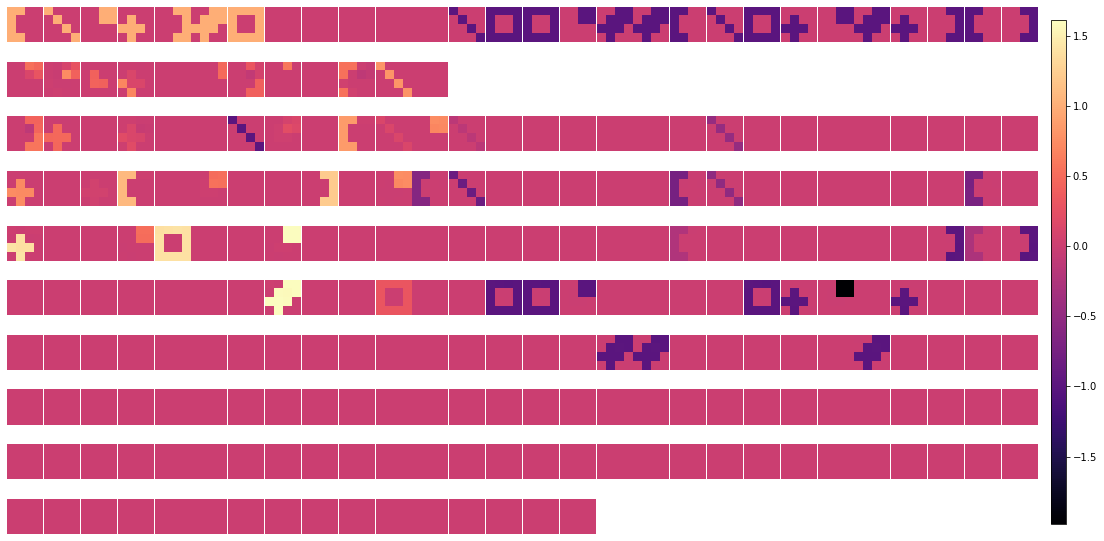

In [12]:
show_rinn(weights, layer_size)

### Conclusions for this RINN model
- 100% recall for hidden and input node patterns, but lower precision because of false positives for hidden node mappings, i.e. there are some hidden nodes that map to a non-ground truth pattern.

<a id='patterns'></a>

## Ground Truth Structure in Simulated Data---looking to see if the RINN above (and autoencoders below) learned these patterns in the hidden nodes.  See https://arxiv.org/abs/2003.13135 for more information.

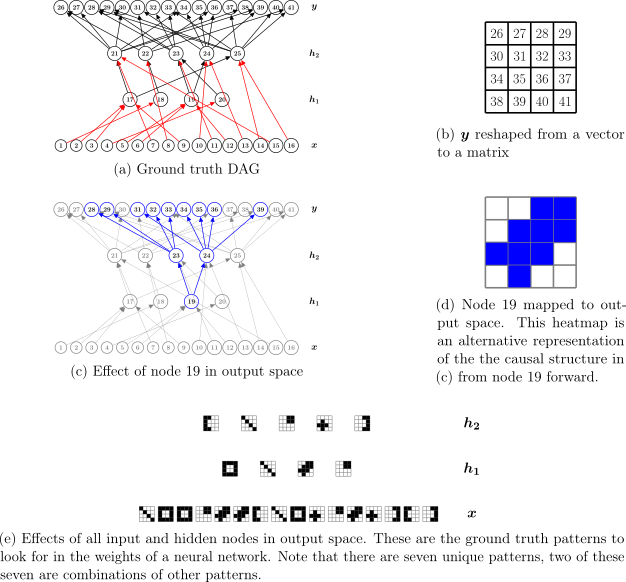

In [13]:
from IPython.display import Image
Image(filename='ground_truth_big.png') 

## Visualize Autoencoder
- only showing ground truth hidden node patterns in top row of visualization since no longer training with inputs as autoencoders on only trained on outputs (i.e., y-values or the 'labels')

In [14]:
def show_ae(weights):
    '''weights must be a list of numpy arrays.'''
    hid_list = []
    for i in weights[1:]:
        hid_list.append(i.shape[0])
        
    max_hid = max(hid_list)
    
    '''ground_truth_input = np.asarray([[-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1],
                      [-1,-1,-1,-1,-1,0,0,-1,-1,0,0,-1,-1,-1,-1,-1],
                      [-1,-1,-1,-1,-1,0,0,-1,-1,0,0,-1,-1,-1,-1,-1],
                      [0,0,-1,-1,0,0,-1,-1,0,0,0,0,0,0,0,0],
                      [0,0,-1,-1,0,-1,-1,-1,-1,-1,-1,0,0,-1,0,0],
                      [0,0,-1,-1,0,-1,-1,-1,-1,-1,-1,0,0,-1,0,0],
                      [-1,-1,0,0,-1,0,0,0,-1,0,0,0,-1,-1,0,0],
                      [-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1],
                      [-1,-1,-1,-1,-1,0,0,-1,-1,0,0,-1,-1,-1,-1,-1],
                      [0,0,0,0,0,-1,0,0,-1,-1,-1,0,0,-1,0,0],
                      [0,0,-1,-1,0,0,-1,-1,0,0,0,0,0,0,0,0],
                      [0,0,-1,-1,0,-1,-1,-1,-1,-1,-1,0,0,-1,0,0],
                      [0,0,0,0,0,-1,0,0,-1,-1,-1,0,0,-1,0,0],
                      [0,0,-1,-1,0,0,0,-1,0,0,0,-1,0,0,-1,-1],
                      [-1,-1,0,0,-1,0,0,0,-1,0,0,0,-1,-1,0,0],
                      [0,0,-1,-1,0,0,0,-1,0,0,0,-1,0,0,-1,-1]])'''
    
    '''ground_truth_hid = np.asarray([[0,0,1,1,0,1,1,1,1,1,1,0,0,1,0,0],
                     [1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1],
                     [1,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0],
                     [0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1],
                     [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1],
                     [0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0],
                     [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])'''
    
    ground_truth_hid = np.asarray([[0,0,-1,-1,0,-1,-1,-1,-1,-1,-1,0,0,-1,0,0],
                     [-1,-1,-1,-1,-1,0,0,-1,-1,0,0,-1,-1,-1,-1,-1],
                     [-1,-1,0,0,-1,0,0,0,-1,0,0,0,-1,-1,0,0],
                     [0,0,-1,-1,0,0,0,-1,0,0,0,-1,0,0,-1,-1],
                     [-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1],
                     [0,0,-1,-1,0,0,-1,-1,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,-1,0,0,-1,-1,-1,0,0,-1,0,0],
                     [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])
    
    ### blank grids after ground truth hidden
    if max_hid < 16:
        blanks = np.ones((8,16))
    else:
        blanks = np.ones((max_hid-8,16))
    

    ptemp = np.concatenate((ground_truth_hid,blanks),axis=0)
    #ptemp = np.concatenate((ground_truth_input,ground_truth_hid,blanks),axis=0)
    pad = ptemp

    # all_gt = np.concatenate((gt_vis,pad),axis=0)
    # print(all_gt.shape)

    # don't include relu because trying to see how weights relate to each other. relu will remove influence of
    # negative weights, so that those nodes that control neg weights won't be visualized.

    ### calculate experimental visulizations with matrix multiply
    exp_vis = []
    for i in range(len(weights)):
        vis = weights[i]
        for j in range(i+1, len(weights)):
            vis = np.matmul(vis, weights[j])
        exp_vis.append(vis)
        #exp_vis.append(expit(vis))
    
    w = pad
    
    if hid_list[-1] < 16:
        for i in reversed(range(len(weights))):
            if i != 0:
                w = np.vstack([w, exp_vis[i], np.ones((16-hid_list[i-1],16))])
            else:
                w = np.vstack([w, exp_vis[i]])
    else:
        for i in reversed(range(len(weights))):
            w = np.vstack([w, exp_vis[i]])


    print(w.shape)

    fig = plt.figure(figsize=(20, 10))  ### size of plot in inches
    gs = gridspec.GridSpec(max(10,len(weights)+1), max(16,max_hid))   ### subplot dimensionality (number of rows and columns of subplots) 
    #gs = gridspec.GridSpec(len(dnn)+1, max(16,hid))
    gs.update(wspace=0.05, hspace=0.05)

    mi = np.min(w)
    ma = np.max(w)

    for i, sample in enumerate(w):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        begin = (2*max_hid)+16
        end = begin+16
        ### CHANGE ARRAY BELOW 8+16+8 --> 8+16+8+16
        #if i not in range(begin,end):  ### how i get blank spaces in middel of plot
        im = plt.imshow(w[i].reshape(get_image_dims(w.shape[1])), vmin=mi, vmax=ma, cmap='magma') #'Greys_r','magma' #image_dims returns shpe of image

    fig.subplots_adjust(right=0.84)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #if save_name:
        #plt.savefig(save_name + '.eps', format='eps', dpi=1000)
        #plt.savefig(save_name + '.svg', format='svg', dpi=1000)
    plt.show()


<a id='ae'></a>

# Stacked Autoencoder
- only train using train_dataset.labels (y-values)

In [15]:
rr = 0.002 #regularization rate
lr = 0.0001  #learning rate
e = 200
bs = 150
activ = 'relu'

tf.random.set_seed(19)
# np.random.seed(18)

stacked_encoder = keras.models.Sequential([
#     keras.layers.Dense(6, activation=activ, input_shape=[16]),
#     keras.layers.Dense(5, activation=activ)
    keras.layers.Dense(6, activation=activ, kernel_regularizer=keras.regularizers.l1(rr)),
    keras.layers.Dense(5, activation=activ, kernel_regularizer=keras.regularizers.l1(rr))
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(6, activation=activ, kernel_regularizer=keras.regularizers.l1(rr)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l1(rr))
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='mse', optimizer='adam')
# stacked_ae.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=lr))

### only train using labels (i.e., y-values) as autoencoders are unsupervised.
history = stacked_ae.fit(train_dataset.labels, train_dataset.labels, 
                    epochs=e, batch_size=bs, verbose=0, callbacks=[PrintEvery50Epochs(), early_stopping],
                    validation_data=(validation_dataset.labels, validation_dataset.labels))


Epoch:  1 , Loss:  1.5484628677368164 , Val Loss:  1.50584876537323
Epoch:  50 , Loss:  0.13600300252437592 , Val Loss:  0.14089028537273407
Epoch:  100 , Loss:  0.11505787819623947 , Val Loss:  0.12045174092054367
Epoch:  150 , Loss:  0.07329106330871582 , Val Loss:  0.07653817534446716
Epoch:  200 , Loss:  0.06877005845308304 , Val Loss:  0.07149291038513184


In [16]:
weights_ae = []
for layer in stacked_encoder.layers:
    weights_ae.append(layer.get_weights()[0])
for layer in stacked_decoder.layers:
    weights_ae.append(layer.get_weights()[0])

In [17]:
for i in weights_ae:
    print(i.shape)

(16, 6)
(6, 5)
(5, 6)
(6, 16)


### top row: black ground truth hidden node patterns that should be present somewhere in hidden nodes
- bottom row: what inputs to autoencoder (i.e., labels or y-values) map to in output space (i.e., a reconstruction of the labels or a reconstruction of y).
- middle layers: what encoder and decoder hidden layers map to in output space.
- all ones heatmaps (i.e., completely yellow boxes/heatmaps in this example) represent blanks or spacing for visualization purposes and are not part of the neural networks---just ignore these boxes---should update visualization code to remove these in future.

(80, 16)


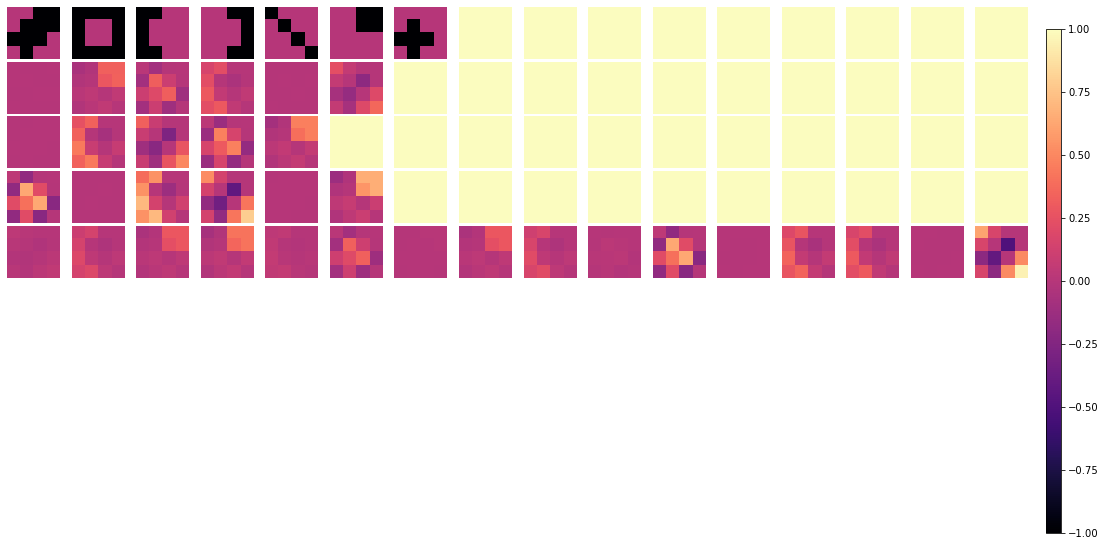

In [18]:
show_ae(weights_ae)

### more versatile code for autoencoder including easier changing of architecture and regularization 

In [19]:
rr = 0.0005 #regularization rate
lr = 0.0001  #learning rate
e = 200
bs = 150
activ = 'relu'
arch = [16,14,12,10,8,6,4,6,8,10,12,14,16]
seed = 19
encoder_reg = False
decoder_reg = False


tf.random.set_seed(seed)
mid_index = int(len(arch)/2)

### ENCODER
stacked_encoder = keras.Sequential()
for i in range(1, mid_index+1):
    if encoder_reg:
        stacked_encoder.add(keras.layers.Dense(arch[i], activation=activ, 
                                               kernel_regularizer=keras.regularizers.l1(rr)))
    else:
        stacked_encoder.add(keras.layers.Dense(arch[i], activation=activ))
        
### DECODER    
stacked_decoder = keras.Sequential()
for i in range(mid_index+1, len(arch)-1):
    if decoder_reg:
        stacked_decoder.add(keras.layers.Dense(arch[i], activation=activ, 
                                               kernel_regularizer=keras.regularizers.l1(rr)))
    else:
        stacked_decoder.add(keras.layers.Dense(arch[i], activation=activ))
if decoder_reg:       
    stacked_decoder.add(keras.layers.Dense(arch[-1], kernel_regularizer=keras.regularizers.l1(rr)))
else:
    stacked_decoder.add(keras.layers.Dense(arch[-1]))

### BOTH
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='mse', optimizer='adam')
# stacked_ae.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=lr))
history = stacked_ae.fit(train_dataset.labels, train_dataset.labels, 
                    epochs=e, batch_size=bs, verbose=0, callbacks=[PrintEvery50Epochs(), early_stopping],
                    validation_data=(validation_dataset.labels, validation_dataset.labels))

Epoch:  1 , Loss:  1.368966817855835 , Val Loss:  1.239698886871338
Epoch:  50 , Loss:  0.10929802805185318 , Val Loss:  0.11365336924791336
Epoch:  100 , Loss:  0.0365394651889801 , Val Loss:  0.04169454053044319
Epoch:  150 , Loss:  0.030162297189235687 , Val Loss:  0.03480493277311325
Epoch:  200 , Loss:  0.02908150479197502 , Val Loss:  0.0329076312482357


In [20]:
def get_ae_weights(stacked_encoder, stacked_decoder):
    weights_ae = []
    for layer in stacked_encoder.layers:
        weights_ae.append(layer.get_weights()[0])
    for layer in stacked_decoder.layers:
        weights_ae.append(layer.get_weights()[0])
    for i in weights_ae:
        print(i.shape)
    print()
    return weights_ae

(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


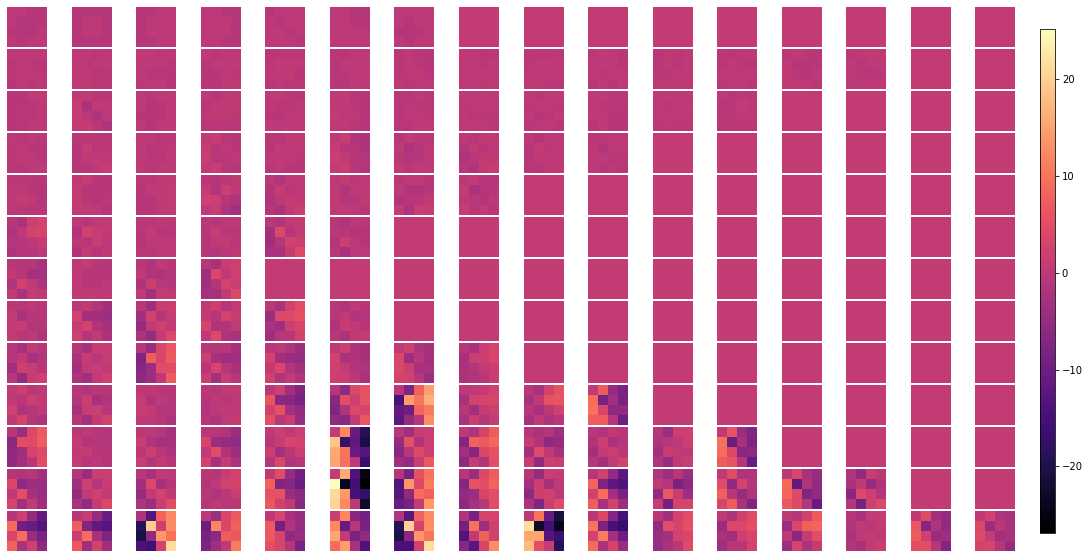

In [21]:
weights_ae = get_ae_weights(stacked_encoder, stacked_decoder)
show_ae(weights_ae)

In [22]:
import random

def run_stacked_autoencoder(arch = [16,8,4,8,16],
                            rr = 0.001,
                            seed = random.randint(0,999999999999),
                            encoder_reg = False,
                            decoder_reg = False,
                            activ = 'relu',
                            e = 200,
                            bs = 150
                            ):
    
    hyperparams = [arch,rr,seed,encoder_reg,decoder_reg,activ,e,bs]
    tf.random.set_seed(seed)
    mid_index = int(len(arch)/2)

    ### ENCODER
    stacked_encoder = keras.Sequential()
    for i in range(1, mid_index+1):
        if encoder_reg:
            stacked_encoder.add(keras.layers.Dense(arch[i], activation=activ, 
                                                   kernel_regularizer=keras.regularizers.l1(rr)))
        else:
            stacked_encoder.add(keras.layers.Dense(arch[i], activation=activ))

    ### DECODER    
    stacked_decoder = keras.Sequential()
    for i in range(mid_index+1, len(arch)-1):
        if decoder_reg:
            stacked_decoder.add(keras.layers.Dense(arch[i], activation=activ, 
                                                   kernel_regularizer=keras.regularizers.l1(rr)))
        else:
            stacked_decoder.add(keras.layers.Dense(arch[i], activation=activ))
    if decoder_reg:       
        stacked_decoder.add(keras.layers.Dense(arch[-1], kernel_regularizer=keras.regularizers.l1(rr)))
    else:
        stacked_decoder.add(keras.layers.Dense(arch[-1]))

    ### BOTH
    stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss='mse', optimizer='adam')
    # stacked_ae.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=lr))
    history = stacked_ae.fit(train_dataset.labels, train_dataset.labels, 
                        epochs=e, batch_size=bs, verbose=0, callbacks=[PrintEvery50Epochs(), early_stopping],
                        validation_data=(validation_dataset.labels, validation_dataset.labels))
    
    return stacked_encoder, stacked_decoder, hyperparams

In [23]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, rr=0.00001,
                                                          seed=19)

Epoch:  1 , Loss:  1.3708910942077637 , Val Loss:  1.2421091794967651
Epoch:  50 , Loss:  0.08864160627126694 , Val Loss:  0.0951349064707756
Epoch:  100 , Loss:  0.07234907895326614 , Val Loss:  0.07900656014680862
Epoch:  150 , Loss:  0.06584036350250244 , Val Loss:  0.0706656202673912
Epoch:  200 , Loss:  0.053737543523311615 , Val Loss:  0.05943703278899193


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


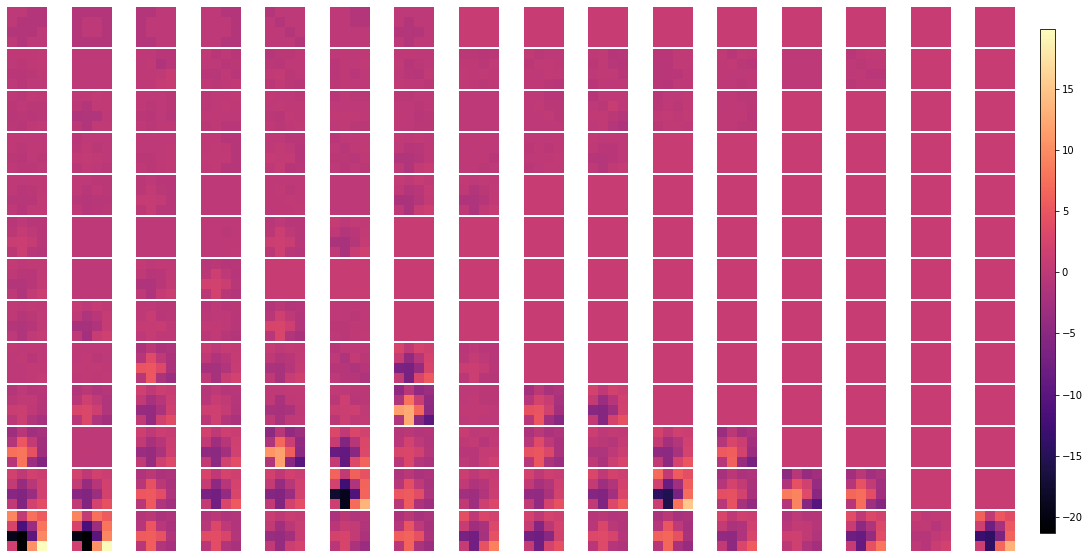

In [24]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [25]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, rr=0.0001,
                                                          seed=19)

Epoch:  1 , Loss:  1.386847734451294 , Val Loss:  1.260182499885559
Epoch:  50 , Loss:  0.10722403973340988 , Val Loss:  0.11535722017288208
Epoch:  100 , Loss:  0.09002833068370819 , Val Loss:  0.09936662018299103
Epoch:  150 , Loss:  0.08741836249828339 , Val Loss:  0.09296058863401413
Epoch:  200 , Loss:  0.0834290087223053 , Val Loss:  0.09122015535831451


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


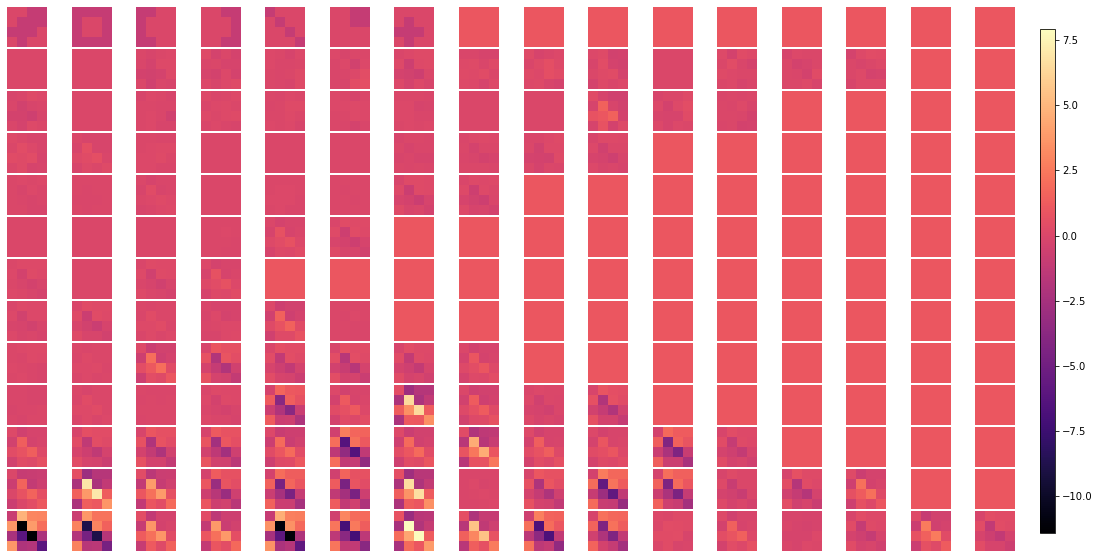

In [26]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [27]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, rr=0.0005,
                                                          seed=19)

Epoch:  1 , Loss:  1.4573979377746582 , Val Loss:  1.3399837017059326
Epoch:  50 , Loss:  0.1542811393737793 , Val Loss:  0.16199536621570587
Epoch:  100 , Loss:  0.13184495270252228 , Val Loss:  0.14100804924964905
Epoch:  150 , Loss:  0.12730935215950012 , Val Loss:  0.1341908723115921
Epoch:  200 , Loss:  0.12367688119411469 , Val Loss:  0.1320813000202179


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


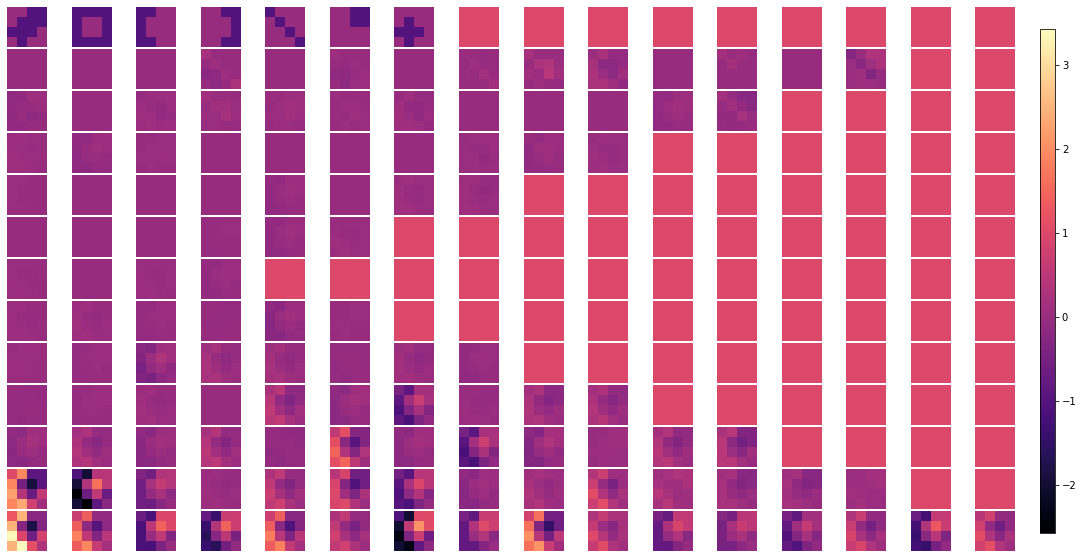

In [28]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [29]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.0001,
                                                          seed=19)

Epoch:  1 , Loss:  1.4051789045333862 , Val Loss:  1.2846482992172241
Epoch:  50 , Loss:  0.12630517780780792 , Val Loss:  0.13584160804748535
Epoch:  100 , Loss:  0.11546099931001663 , Val Loss:  0.12228916585445404
Epoch:  150 , Loss:  0.10368917137384415 , Val Loss:  0.10923675447702408
Epoch:  200 , Loss:  0.09914427995681763 , Val Loss:  0.10613546520471573


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


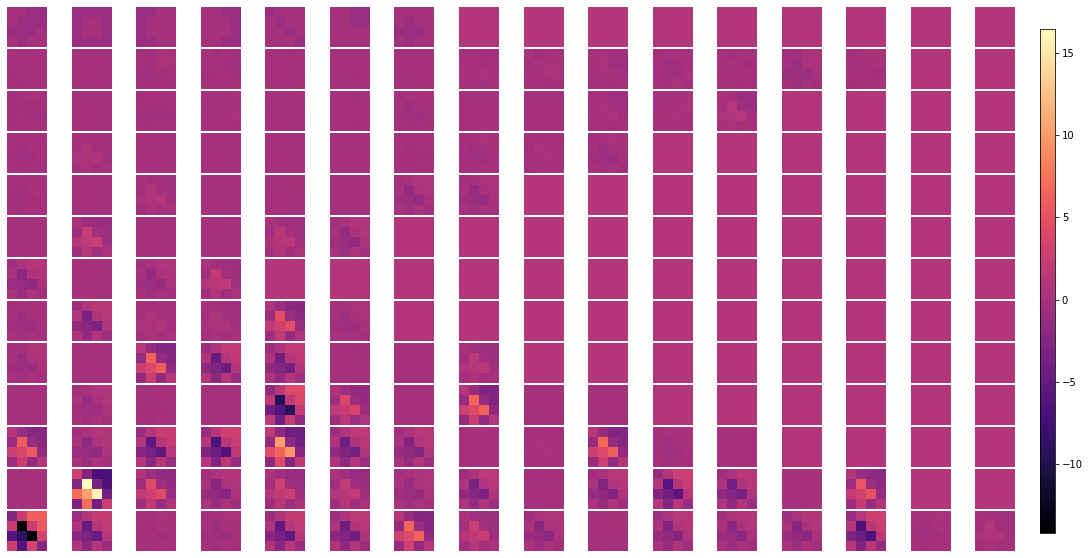

In [30]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [31]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.0005,
                                                          seed=19)

Epoch:  1 , Loss:  1.5436699390411377 , Val Loss:  1.4426149129867554
Epoch:  50 , Loss:  0.2633904814720154 , Val Loss:  0.2727689743041992
Epoch:  100 , Loss:  0.24811163544654846 , Val Loss:  0.25678348541259766
Epoch:  150 , Loss:  0.2407895177602768 , Val Loss:  0.2497611939907074
Epoch:  200 , Loss:  0.23676837980747223 , Val Loss:  0.24637241661548615


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


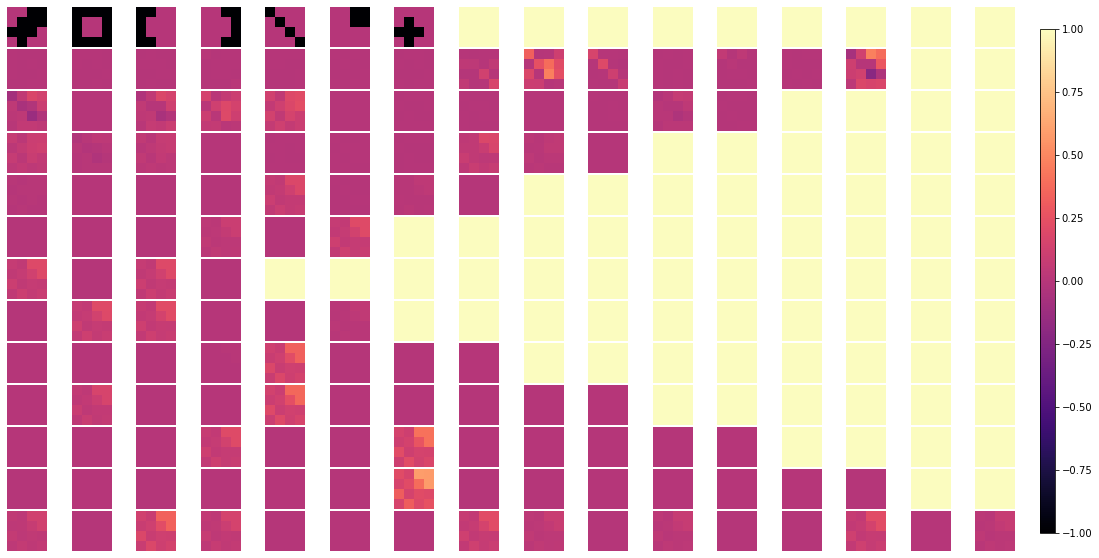

In [32]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [33]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.0003,
                                                          seed=19)

Epoch:  1 , Loss:  1.4746865034103394 , Val Loss:  1.3643020391464233
Epoch:  50 , Loss:  0.16535425186157227 , Val Loss:  0.17302480340003967
Epoch:  100 , Loss:  0.15457260608673096 , Val Loss:  0.16074484586715698
Epoch:  150 , Loss:  0.13858704268932343 , Val Loss:  0.14656192064285278
Epoch:  200 , Loss:  0.1296333521604538 , Val Loss:  0.14043520390987396


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


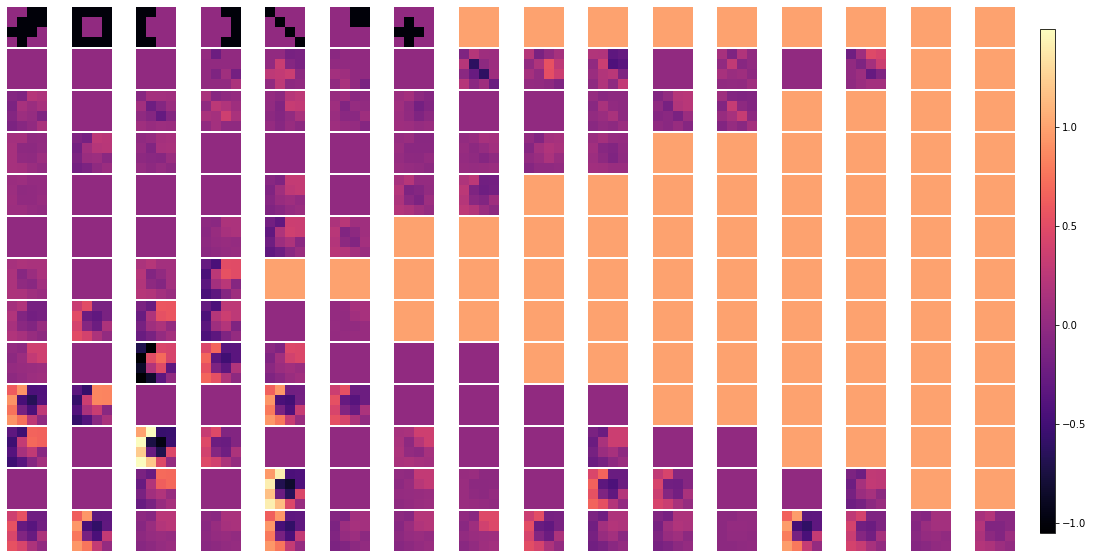

In [34]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [35]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.0002,
                                                          seed=19)

Epoch:  1 , Loss:  1.4401978254318237 , Val Loss:  1.3256622552871704
Epoch:  50 , Loss:  0.1426931917667389 , Val Loss:  0.15231440961360931
Epoch:  100 , Loss:  0.10256712883710861 , Val Loss:  0.10984189808368683
Epoch:  150 , Loss:  0.0937788113951683 , Val Loss:  0.09821152687072754
Epoch:  200 , Loss:  0.08972485363483429 , Val Loss:  0.09576171636581421


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


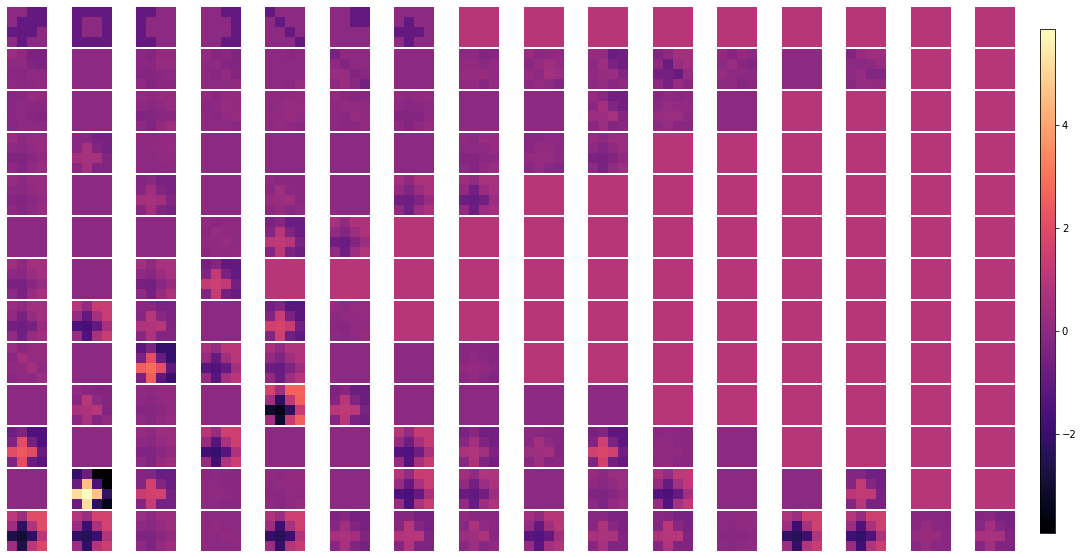

In [36]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [37]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=False, rr=0.0003,
                                                          seed=19)

Epoch:  1 , Loss:  1.4221898317337036 , Val Loss:  1.3001459836959839
Epoch:  50 , Loss:  0.14579713344573975 , Val Loss:  0.15387070178985596
Epoch:  100 , Loss:  0.07278236746788025 , Val Loss:  0.07911375164985657
Epoch:  150 , Loss:  0.054268162697553635 , Val Loss:  0.0585976205766201
Epoch:  200 , Loss:  0.04794095829129219 , Val Loss:  0.05112485587596893


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


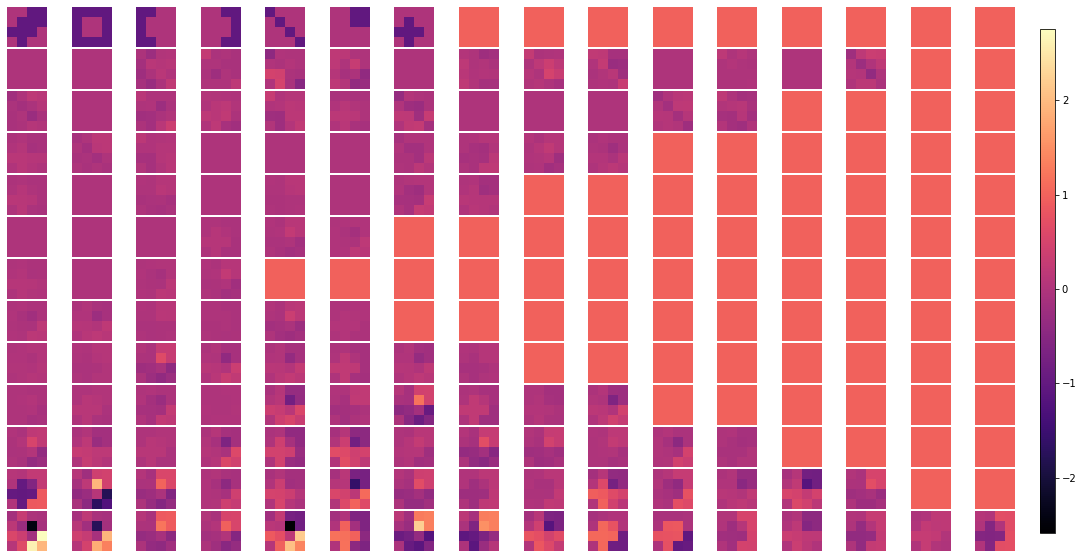

In [38]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [39]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=False, rr=0.0003,
                                                          seed=19,activ='selu')

Epoch:  1 , Loss:  1.6463847160339355 , Val Loss:  1.168209195137024
Epoch:  50 , Loss:  0.06861292570829391 , Val Loss:  0.0713520273566246
Epoch:  100 , Loss:  0.04494960606098175 , Val Loss:  0.046338606625795364
Epoch:  150 , Loss:  0.03563801571726799 , Val Loss:  0.036246150732040405
Epoch:  200 , Loss:  0.028332121670246124 , Val Loss:  0.028390048071742058


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


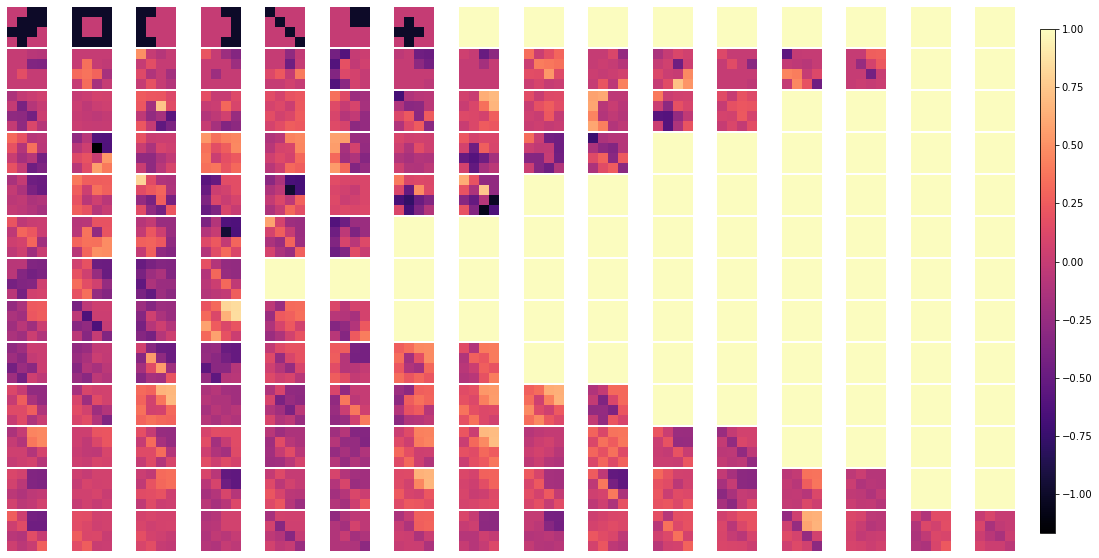

In [40]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

## Thoughts
- selu gives better results than relu

In [41]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.0003,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  1.6972341537475586 , Val Loss:  1.218786597251892
Epoch:  50 , Loss:  0.11157864332199097 , Val Loss:  0.11405234783887863
Epoch:  100 , Loss:  0.0810493677854538 , Val Loss:  0.08249016106128693
Epoch:  150 , Loss:  0.06446092575788498 , Val Loss:  0.06436003744602203
Epoch:  200 , Loss:  0.05320804938673973 , Val Loss:  0.053120847791433334


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


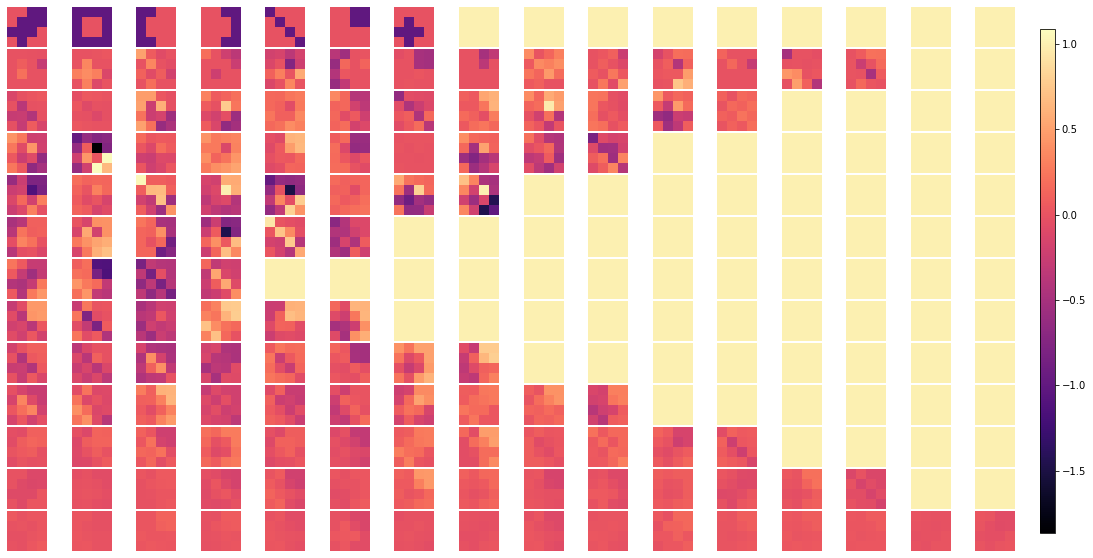

In [42]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [43]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.0005,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  1.7648296356201172 , Val Loss:  1.2871086597442627
Epoch:  50 , Loss:  0.16006948053836823 , Val Loss:  0.16233259439468384
Epoch:  100 , Loss:  0.1169188991189003 , Val Loss:  0.11870483309030533
Epoch:  150 , Loss:  0.08784658461809158 , Val Loss:  0.08852186799049377
Epoch:  200 , Loss:  0.0728711187839508 , Val Loss:  0.07303028553724289


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


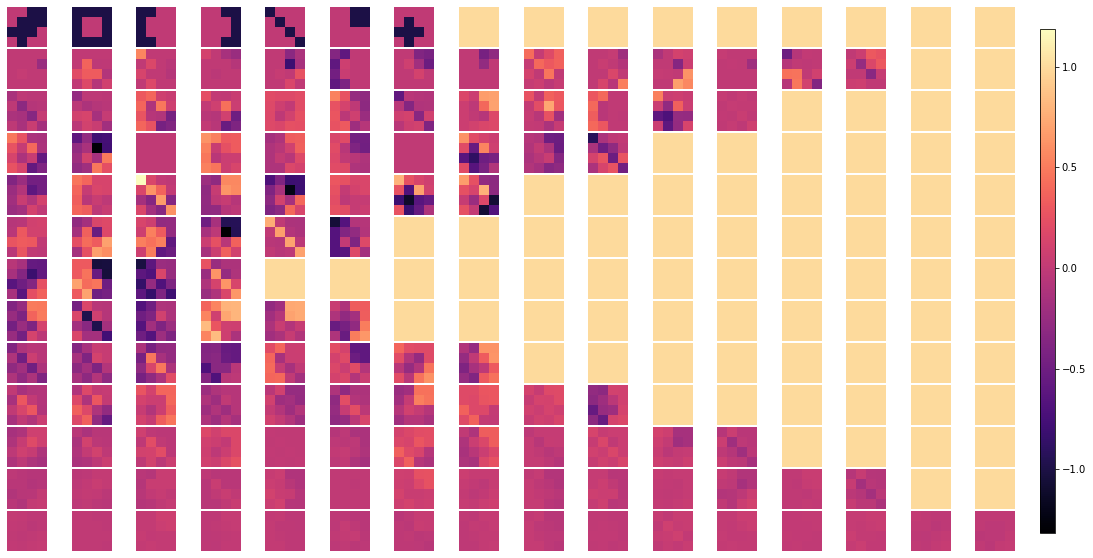

In [44]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [45]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=False, rr=0.0005,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  1.6804496049880981 , Val Loss:  1.2021024227142334
Epoch:  50 , Loss:  0.09462801367044449 , Val Loss:  0.09724540263414383
Epoch:  100 , Loss:  0.06415192037820816 , Val Loss:  0.06645980477333069
Epoch:  150 , Loss:  0.04869716241955757 , Val Loss:  0.049711018800735474
Epoch:  200 , Loss:  0.0369710698723793 , Val Loss:  0.03714490681886673


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


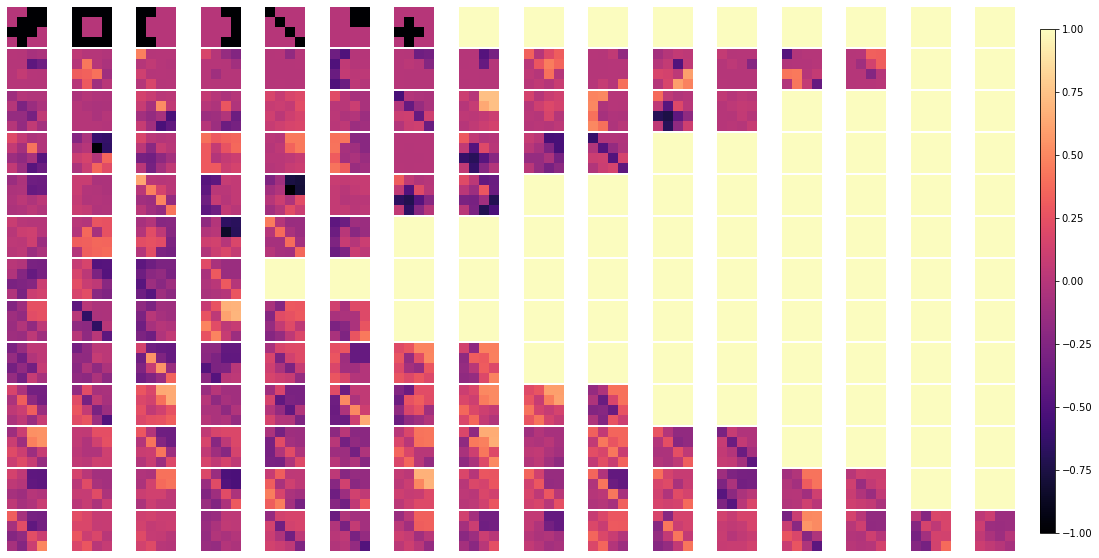

In [46]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [47]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.0008,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  1.8663080930709839 , Val Loss:  1.3880075216293335
Epoch:  50 , Loss:  0.21966426074504852 , Val Loss:  0.22152787446975708
Epoch:  100 , Loss:  0.15431906282901764 , Val Loss:  0.1564221978187561
Epoch:  150 , Loss:  0.11528881639242172 , Val Loss:  0.11591224372386932
Epoch:  200 , Loss:  0.08747022598981857 , Val Loss:  0.08739680051803589


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


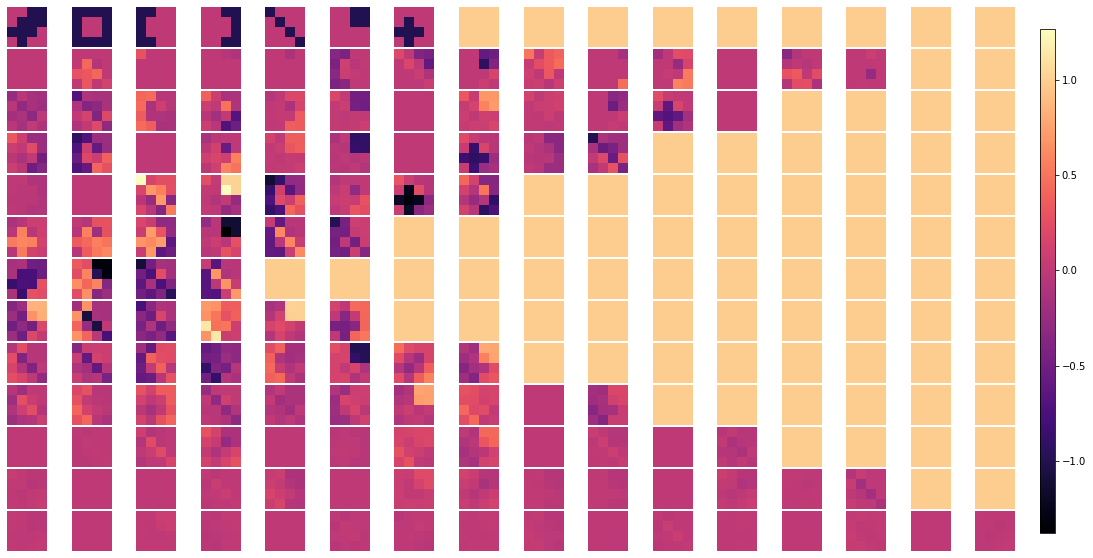

In [48]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [49]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=False, rr=0.0008,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  1.7315131425857544 , Val Loss:  1.2525054216384888
Epoch:  50 , Loss:  0.1275029480457306 , Val Loss:  0.1299571990966797
Epoch:  100 , Loss:  0.09153515100479126 , Val Loss:  0.09404400736093521
Epoch:  150 , Loss:  0.06623189896345139 , Val Loss:  0.06834175437688828
Epoch:  200 , Loss:  0.046887267380952835 , Val Loss:  0.047271501272916794


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


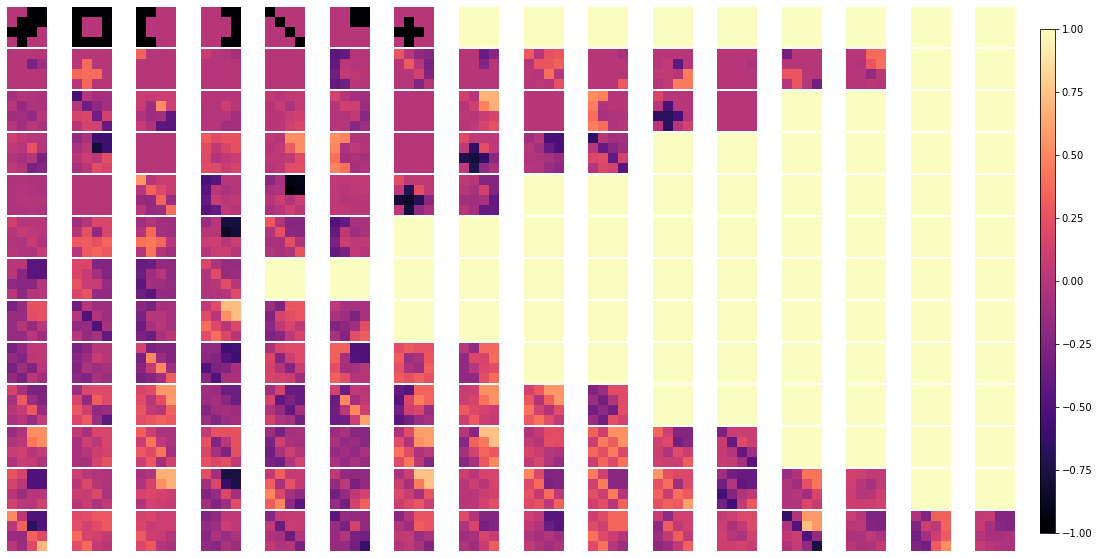

In [50]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

## Thoughts
- nice result. look at smallest layer.

In [51]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=False, rr=0.001,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  1.765551209449768 , Val Loss:  1.286250352859497
Epoch:  50 , Loss:  0.1758519411087036 , Val Loss:  0.18080021440982819
Epoch:  100 , Loss:  0.10777193307876587 , Val Loss:  0.11044882237911224
Epoch:  150 , Loss:  0.08515141904354095 , Val Loss:  0.0875508114695549
Epoch:  200 , Loss:  0.06621309369802475 , Val Loss:  0.06815337389707565


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


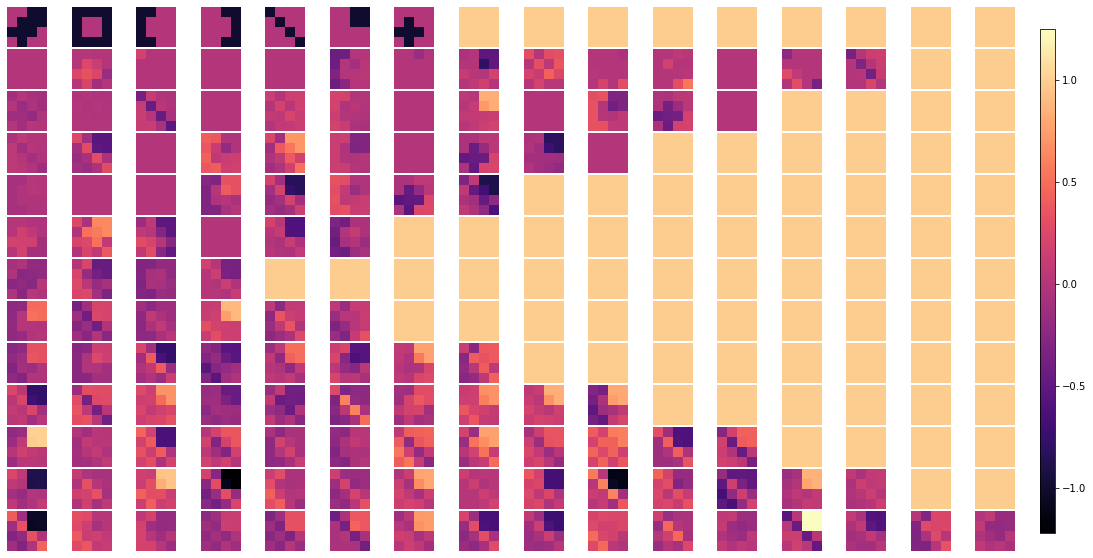

In [52]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

# Conclusions so far
- this one also looks good. look at the smallest layer---probably 2 combo nodes in there and then diagonal plus small block node. pretty good. 
- so this means using selu and only regularizing the decoder seems to work better

## Next
- try shallower network, other activation functions
- move on to other autoencoders

In [53]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.001,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  1.9335607290267944 , Val Loss:  1.4542701244354248
Epoch:  50 , Loss:  0.25352394580841064 , Val Loss:  0.25515902042388916
Epoch:  100 , Loss:  0.17420928180217743 , Val Loss:  0.17608186602592468
Epoch:  150 , Loss:  0.13152438402175903 , Val Loss:  0.13348662853240967
Epoch:  200 , Loss:  0.10414998978376389 , Val Loss:  0.10633520781993866


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


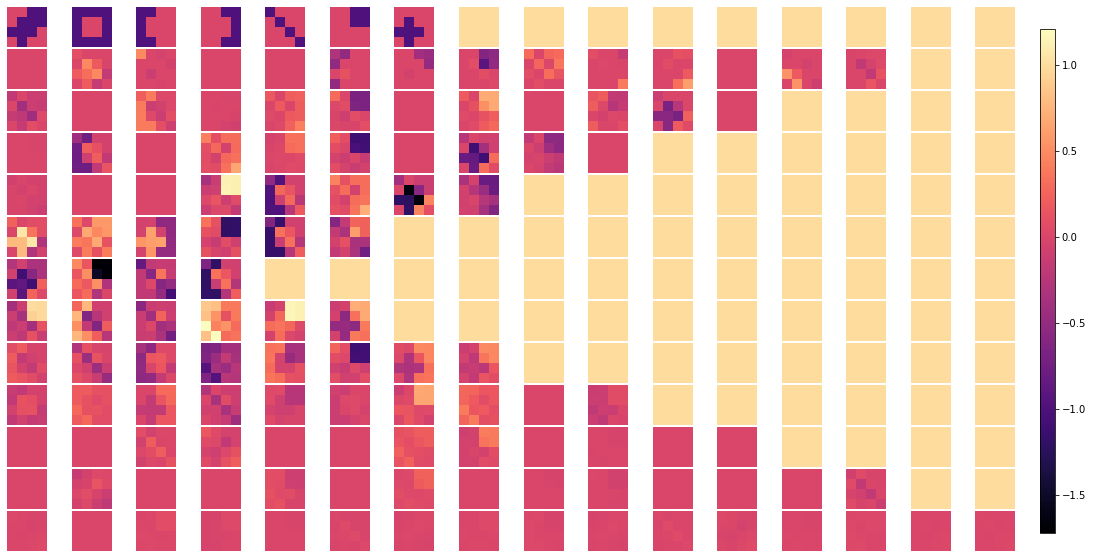

In [54]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [55]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=False, rr=0.0012,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  1.7996810674667358 , Val Loss:  1.3205852508544922
Epoch:  50 , Loss:  0.163320854306221 , Val Loss:  0.16546779870986938
Epoch:  100 , Loss:  0.11914625018835068 , Val Loss:  0.12180308252573013
Epoch:  150 , Loss:  0.0886785238981247 , Val Loss:  0.09044309705495834
Epoch:  200 , Loss:  0.06328500062227249 , Val Loss:  0.06465218961238861


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


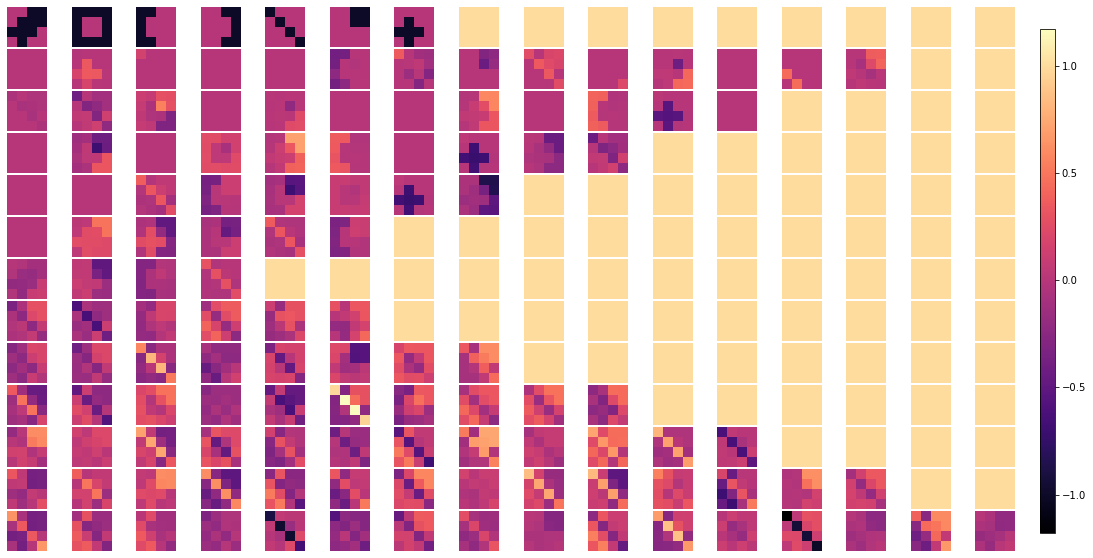

In [56]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

In [57]:
encoder_ae, decoder_ae, hparams = run_stacked_autoencoder(arch=[16,14,12,10,8,6,4,6,8,10,12,14,16],
                                                          decoder_reg=True, encoder_reg=True, rr=0.0012,
                                                          seed=19, activ='selu')

Epoch:  1 , Loss:  2.0012357234954834 , Val Loss:  1.5217963457107544
Epoch:  50 , Loss:  0.312112033367157 , Val Loss:  0.31695181131362915
Epoch:  100 , Loss:  0.21356984972953796 , Val Loss:  0.21864743530750275
Epoch:  150 , Loss:  0.15568038821220398 , Val Loss:  0.16071806848049164
Epoch:  200 , Loss:  0.11940543353557587 , Val Loss:  0.12068179994821548


(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

(208, 16)


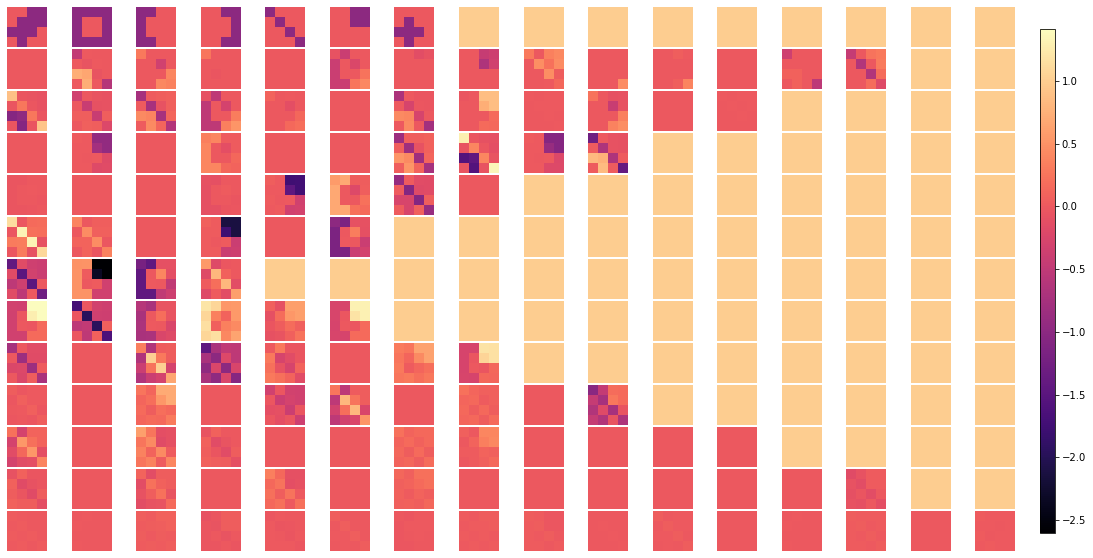

In [58]:
weights_ae = get_ae_weights(encoder_ae, decoder_ae)
show_ae(weights_ae)

# Denoising Autoencoder
- Dropout layer or Gaussian Noise layer

### Add option for denoising autoencoder 

In [74]:
import random

def run_autoencoder(arch = [16,8,4,8,16],
                    rr = 0.001,
                    seed = random.randint(0,999999999999),
                    encoder_reg = False,
                    decoder_reg = False,
                    activ = 'relu',
                    e = 200,
                    bs = 150,
                    dropout = False,
                    drop_rate = 0.5,
                    noise = False,
                    stdev = 1
                    ):
    
    if dropout and noise:
        print('Error! Choose either dropout or gaussian noise, but not both.')
        return False
    
    hyperparams = [arch,rr,seed,encoder_reg,decoder_reg,activ,e,bs]
    tf.random.set_seed(seed)
    mid_index = int(len(arch)/2)

    ### ENCODER
    stacked_encoder = keras.Sequential()
    if dropout:
        stacked_encoder.add(keras.layers.Dropout(drop_rate))
    elif noise:
        stacked_encoder.add(keras.layers.GaussianNoise(stdev))
    for i in range(1, mid_index+1):
        if encoder_reg:
            stacked_encoder.add(keras.layers.Dense(arch[i], activation=activ, 
                                                   kernel_regularizer=keras.regularizers.l1(rr)))
        else:
            stacked_encoder.add(keras.layers.Dense(arch[i], activation=activ))

    ### DECODER    
    stacked_decoder = keras.Sequential()
    for i in range(mid_index+1, len(arch)-1):
        if decoder_reg:
            stacked_decoder.add(keras.layers.Dense(arch[i], activation=activ, 
                                                   kernel_regularizer=keras.regularizers.l1(rr)))
        else:
            stacked_decoder.add(keras.layers.Dense(arch[i], activation=activ))
    if decoder_reg:       
        stacked_decoder.add(keras.layers.Dense(arch[-1], kernel_regularizer=keras.regularizers.l1(rr)))
    else:
        stacked_decoder.add(keras.layers.Dense(arch[-1]))

    ### BOTH
    stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss='mse', optimizer='adam')
    # stacked_ae.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=lr))
    history = stacked_ae.fit(train_dataset.labels, train_dataset.labels, 
                        epochs=e, batch_size=bs, verbose=0, callbacks=[PrintEvery50Epochs(), early_stopping],
                        validation_data=(validation_dataset.labels, validation_dataset.labels))
    
    return stacked_encoder, stacked_decoder, hyperparams

<a id='drop_ae'></a>

## Dropout

In [75]:
def get_ae_weights(stacked_encoder, stacked_decoder):
    weights_ae = []
    for layer in stacked_encoder.layers:
        str_layer = str(layer)
        if 'Dropout' in str_layer or 'Gaussian' in str_layer:
            pass
        else:
            weights_ae.append(layer.get_weights()[0])
    for layer in stacked_decoder.layers:
        weights_ae.append(layer.get_weights()[0])
    for i in weights_ae:
        print(i.shape)
    print()
    return weights_ae

Epoch:  1 , Loss:  2.0780599117279053 , Val Loss:  1.5777007341384888
Epoch:  50 , Loss:  0.4088483452796936 , Val Loss:  0.5503047704696655
Epoch:  100 , Loss:  0.31390753388404846 , Val Loss:  0.4375307559967041
Epoch:  150 , Loss:  0.2778831422328949 , Val Loss:  0.44604989886283875
Epoch:  200 , Loss:  0.25319528579711914 , Val Loss:  0.3926748037338257
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.001, 19, True, True, 'selu', 200, 150]
(208, 16)


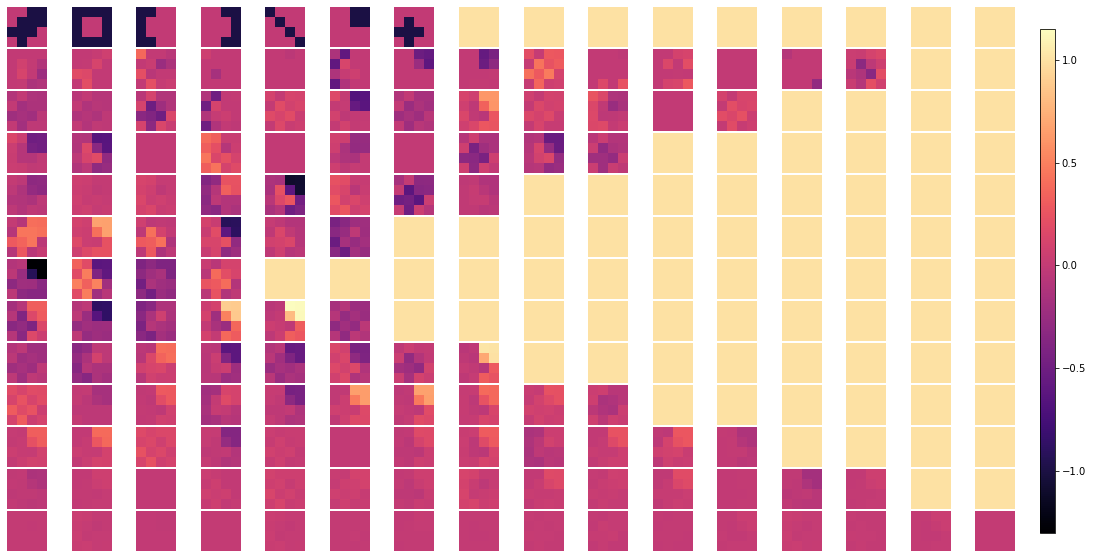

Epoch:  1 , Loss:  1.9106405973434448 , Val Loss:  1.4132992029190063
Epoch:  50 , Loss:  0.29703980684280396 , Val Loss:  0.43130502104759216
Epoch:  100 , Loss:  0.22547535598278046 , Val Loss:  0.3779737651348114
Epoch:  150 , Loss:  0.19868172705173492 , Val Loss:  0.3466219902038574
Epoch:  200 , Loss:  0.18007339537143707 , Val Loss:  0.3081986606121063
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.001, 19, False, True, 'selu', 200, 150]
(208, 16)


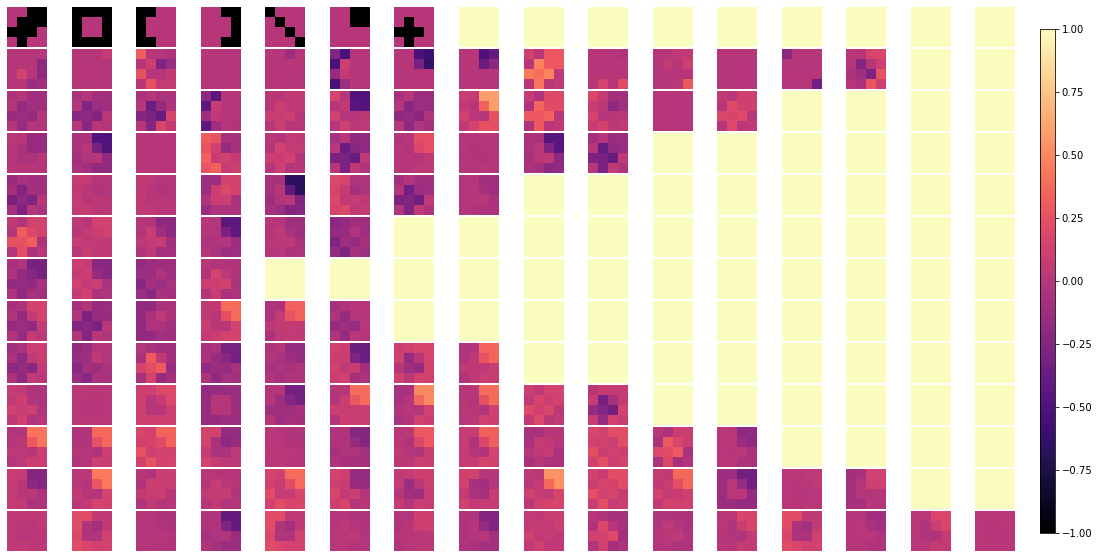

Epoch:  1 , Loss:  1.9076728820800781 , Val Loss:  1.4082170724868774
Epoch:  50 , Loss:  0.2876661419868469 , Val Loss:  0.4532928764820099
Epoch:  100 , Loss:  0.2270246148109436 , Val Loss:  0.36631420254707336
Epoch:  150 , Loss:  0.2047574520111084 , Val Loss:  0.3977615535259247
Epoch:  200 , Loss:  0.18700572848320007 , Val Loss:  0.3522668480873108
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.001, 19, True, False, 'selu', 200, 150]
(208, 16)


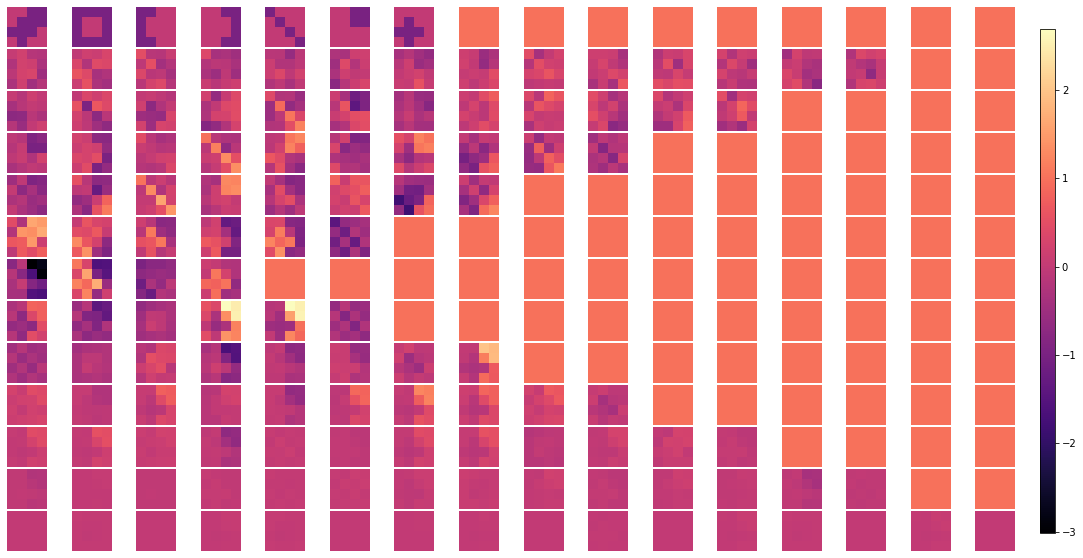

Epoch:  1 , Loss:  1.7402795553207397 , Val Loss:  1.2441433668136597
Epoch:  50 , Loss:  0.1786123514175415 , Val Loss:  0.38073593378067017
Epoch:  100 , Loss:  0.1360291838645935 , Val Loss:  0.2769066095352173
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.001, 19, False, False, 'selu', 200, 150]
(208, 16)


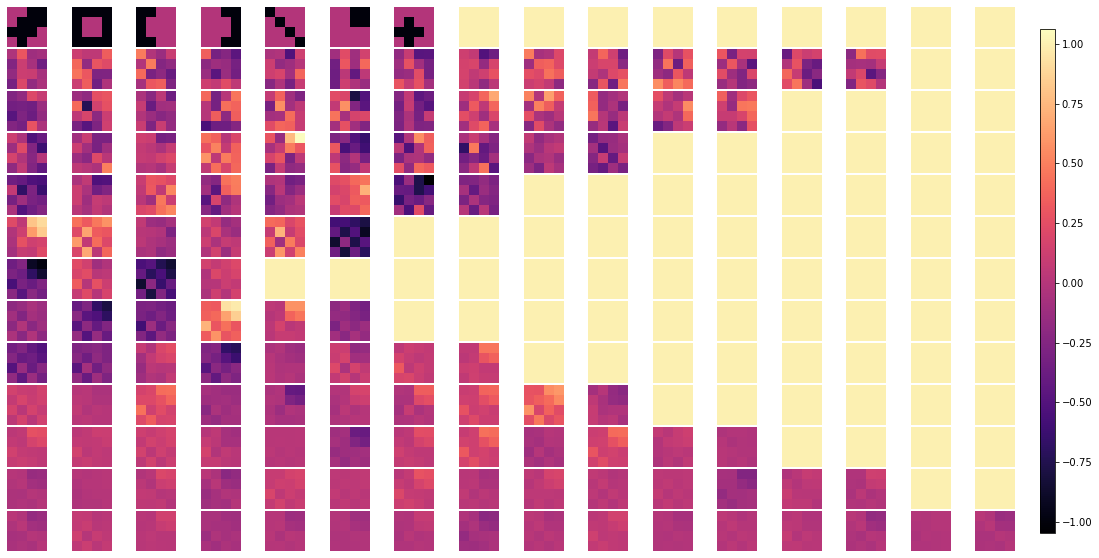

Epoch:  1 , Loss:  1.909232497215271 , Val Loss:  1.4111168384552002
Epoch:  50 , Loss:  0.3086325228214264 , Val Loss:  0.48117733001708984
Epoch:  100 , Loss:  0.24902594089508057 , Val Loss:  0.37444353103637695
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.0005, 19, True, True, 'selu', 200, 150]
(208, 16)


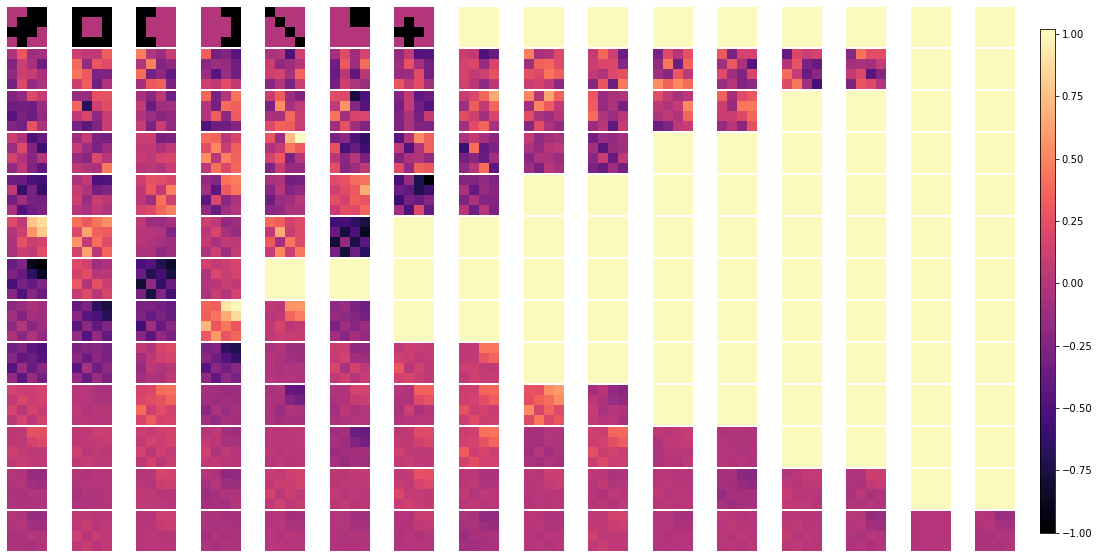

Epoch:  1 , Loss:  1.8254942893981934 , Val Loss:  1.328662633895874
Epoch:  50 , Loss:  0.24939864873886108 , Val Loss:  0.4210743010044098
Epoch:  100 , Loss:  0.1946672648191452 , Val Loss:  0.3338181674480438
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.0005, 19, False, True, 'selu', 200, 150]
(208, 16)


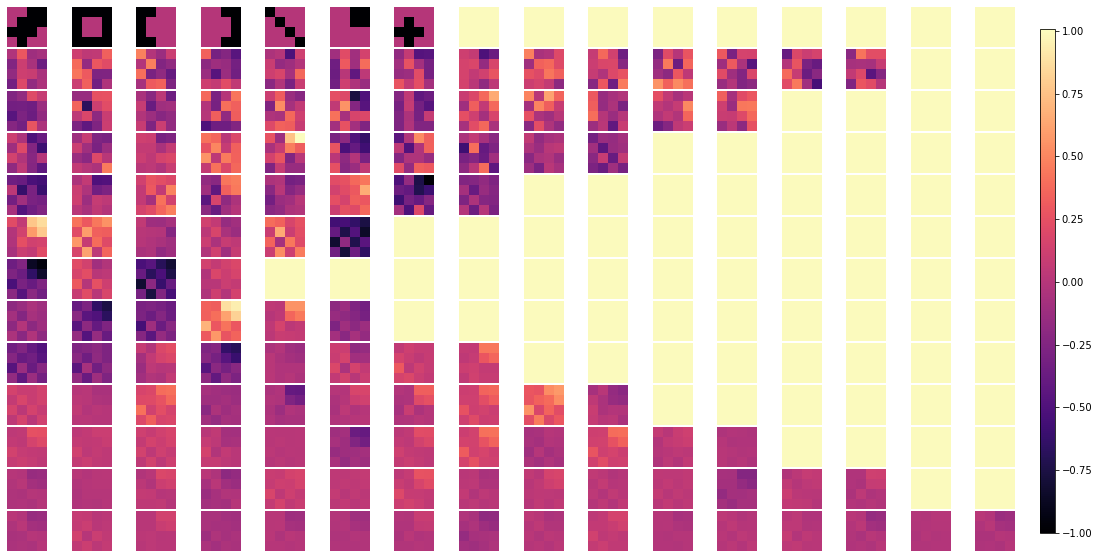

Epoch:  1 , Loss:  1.8240097761154175 , Val Loss:  1.327236294746399
Epoch:  50 , Loss:  0.24046464264392853 , Val Loss:  0.43192997574806213
Epoch:  100 , Loss:  0.18957802653312683 , Val Loss:  0.3111894726753235
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.0005, 19, True, False, 'selu', 200, 150]
(208, 16)


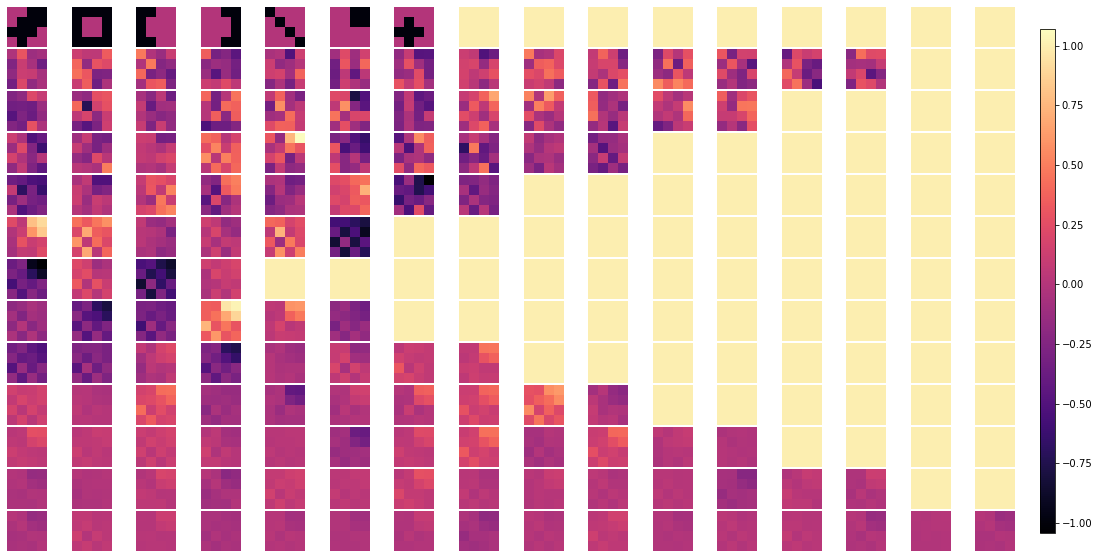

Epoch:  1 , Loss:  1.7402795553207397 , Val Loss:  1.2441433668136597
Epoch:  50 , Loss:  0.1786123514175415 , Val Loss:  0.38073593378067017
Epoch:  100 , Loss:  0.1360291838645935 , Val Loss:  0.2769066095352173
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.0005, 19, False, False, 'selu', 200, 150]
(208, 16)


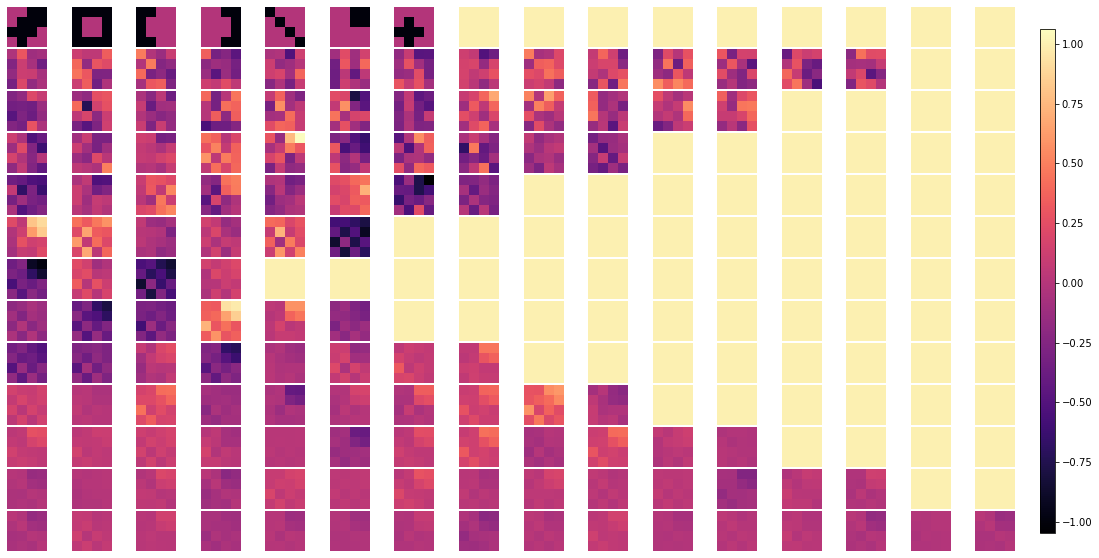

Epoch:  1 , Loss:  2.668422222137451 , Val Loss:  1.4408409595489502
Epoch:  50 , Loss:  0.28016483783721924 , Val Loss:  0.21285338699817657
Epoch:  100 , Loss:  0.23888733983039856 , Val Loss:  0.19272640347480774
Epoch:  150 , Loss:  0.20793984830379486 , Val Loss:  0.2763217091560364
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.001, 19, True, True, 'selu', 200, 150]
(80, 16)


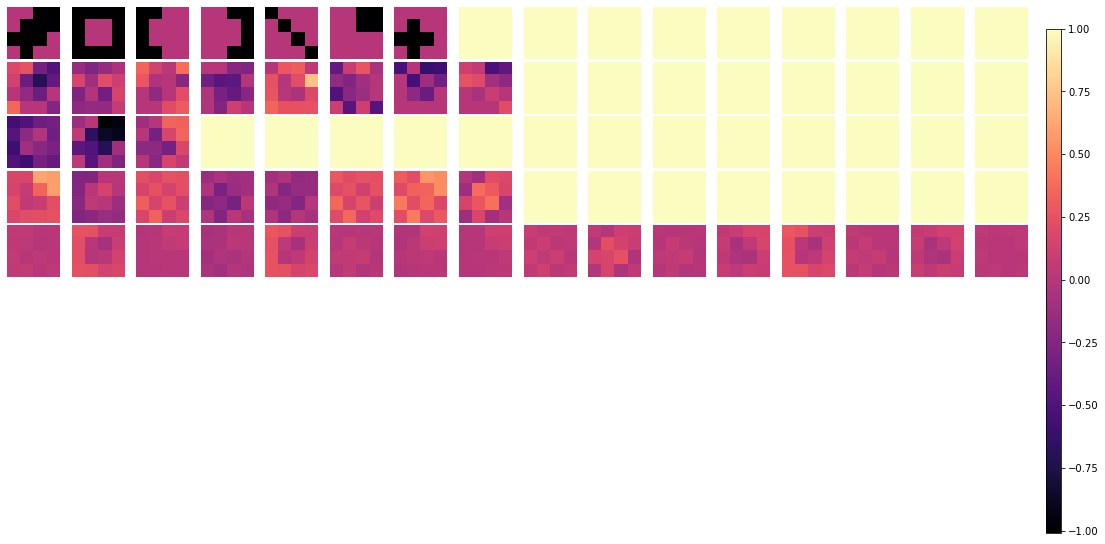

Epoch:  1 , Loss:  2.6306447982788086 , Val Loss:  1.4032325744628906
Epoch:  50 , Loss:  0.2536255717277527 , Val Loss:  0.1836770623922348
Epoch:  100 , Loss:  0.21650153398513794 , Val Loss:  0.16195179522037506
Epoch:  150 , Loss:  0.19148346781730652 , Val Loss:  0.20177148282527924
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.001, 19, False, True, 'selu', 200, 150]
(80, 16)


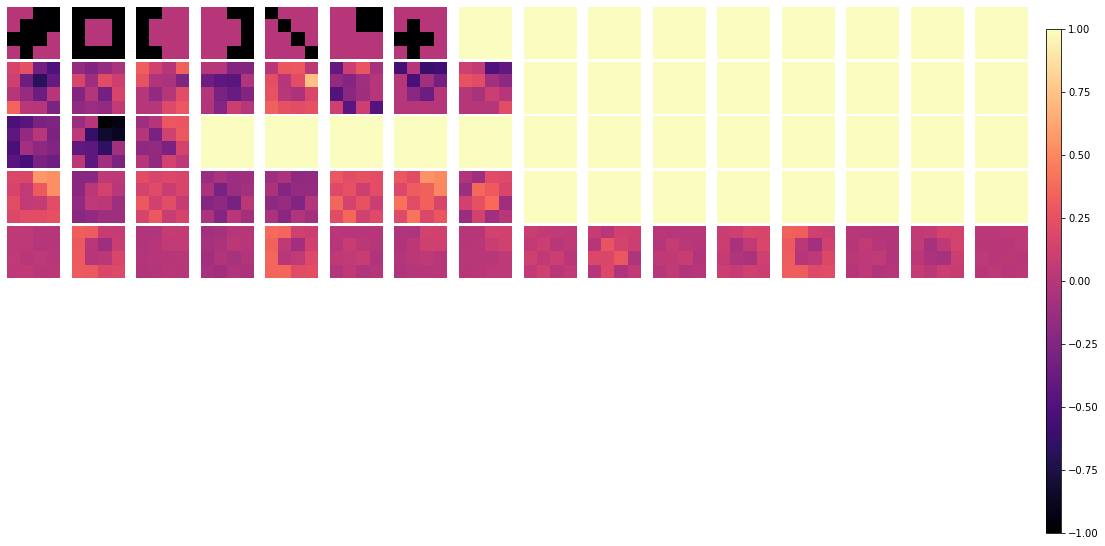

Epoch:  1 , Loss:  2.6259233951568604 , Val Loss:  1.3987284898757935
Epoch:  50 , Loss:  0.24224863946437836 , Val Loss:  0.17369112372398376
Epoch:  100 , Loss:  0.20049943029880524 , Val Loss:  0.16762572526931763
Epoch:  150 , Loss:  0.17284172773361206 , Val Loss:  0.2907034158706665
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.001, 19, True, False, 'selu', 200, 150]
(80, 16)


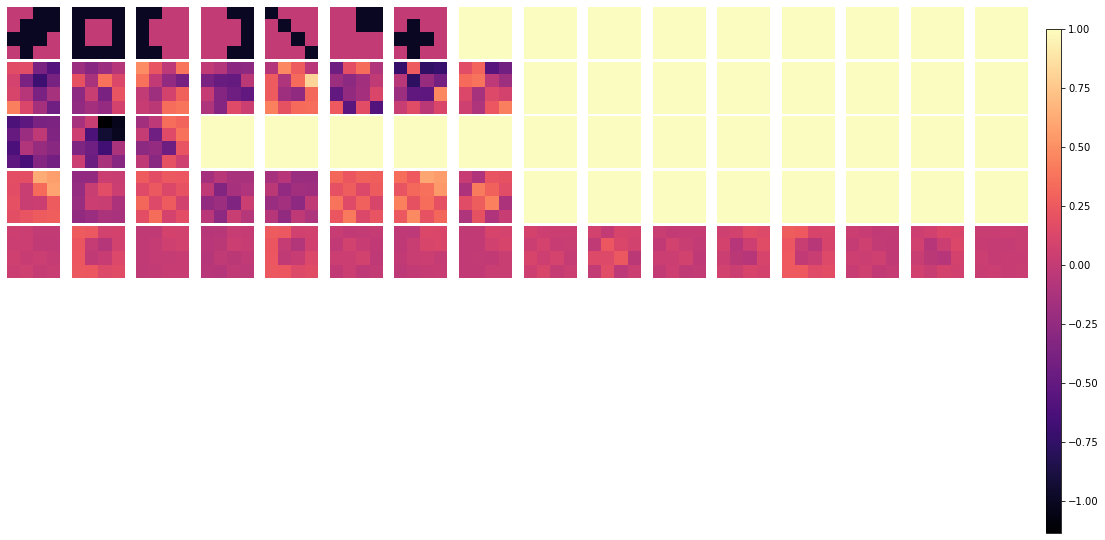

Epoch:  1 , Loss:  2.588146686553955 , Val Loss:  1.3611199855804443
Epoch:  50 , Loss:  0.21609994769096375 , Val Loss:  0.1445482224225998
Epoch:  100 , Loss:  0.18200983107089996 , Val Loss:  0.1334591954946518
Epoch:  150 , Loss:  0.15927137434482574 , Val Loss:  0.20833522081375122
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.001, 19, False, False, 'selu', 200, 150]
(80, 16)


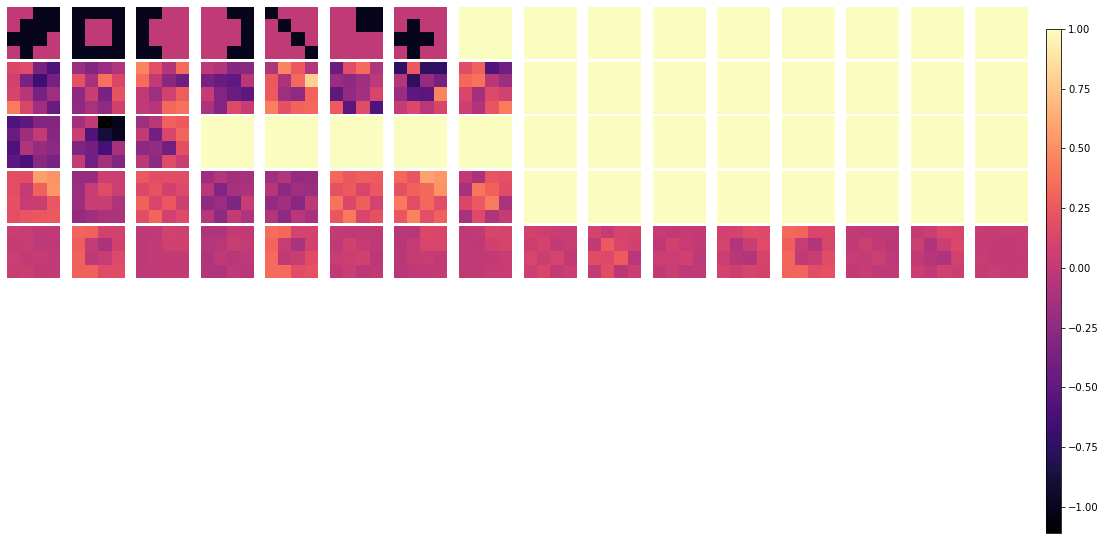

Epoch:  1 , Loss:  2.628286361694336 , Val Loss:  1.4009863138198853
Epoch:  50 , Loss:  0.2497301697731018 , Val Loss:  0.17987117171287537
Epoch:  100 , Loss:  0.2128274291753769 , Val Loss:  0.16805297136306763
Epoch:  150 , Loss:  0.18553201854228973 , Val Loss:  0.2568668723106384
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.0005, 19, True, True, 'selu', 200, 150]
(80, 16)


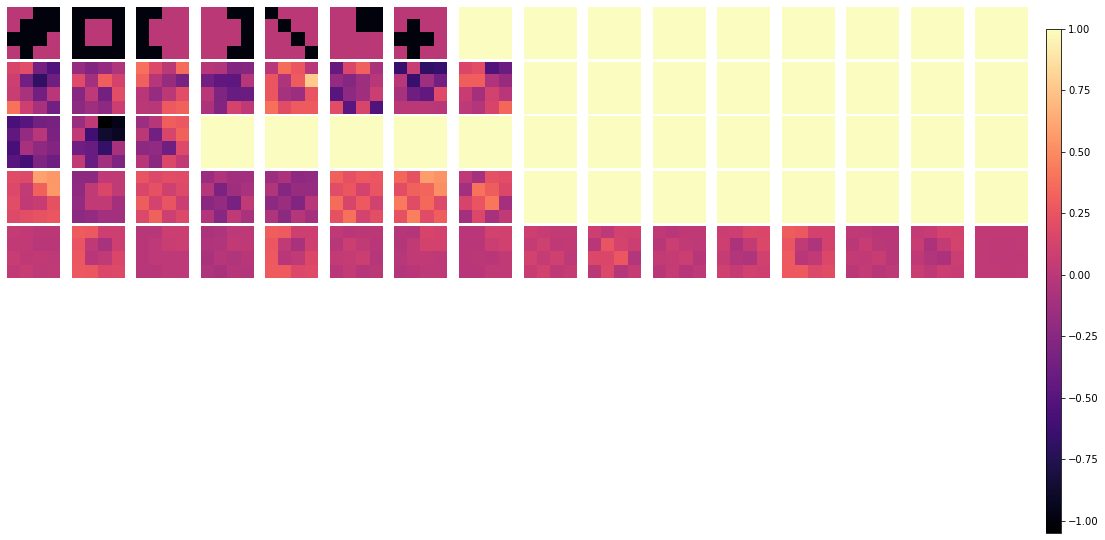

Epoch:  1 , Loss:  2.6093969345092773 , Val Loss:  1.3821806907653809
Epoch:  50 , Loss:  0.2360561490058899 , Val Loss:  0.1649792641401291
Epoch:  100 , Loss:  0.2011951357126236 , Val Loss:  0.14887000620365143
Epoch:  150 , Loss:  0.1775413155555725 , Val Loss:  0.20853234827518463
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.0005, 19, False, True, 'selu', 200, 150]
(80, 16)


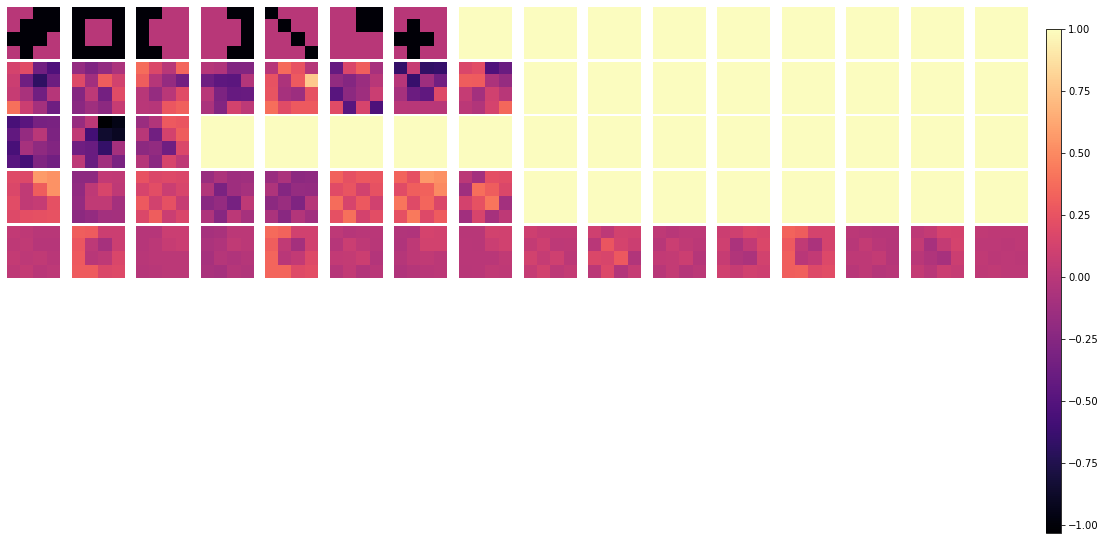

Epoch:  1 , Loss:  2.607034683227539 , Val Loss:  1.3799254894256592
Epoch:  50 , Loss:  0.22969165444374084 , Val Loss:  0.15954001247882843
Epoch:  100 , Loss:  0.19292914867401123 , Val Loss:  0.15321651101112366
Epoch:  150 , Loss:  0.16681194305419922 , Val Loss:  0.25773757696151733
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.0005, 19, True, False, 'selu', 200, 150]
(80, 16)


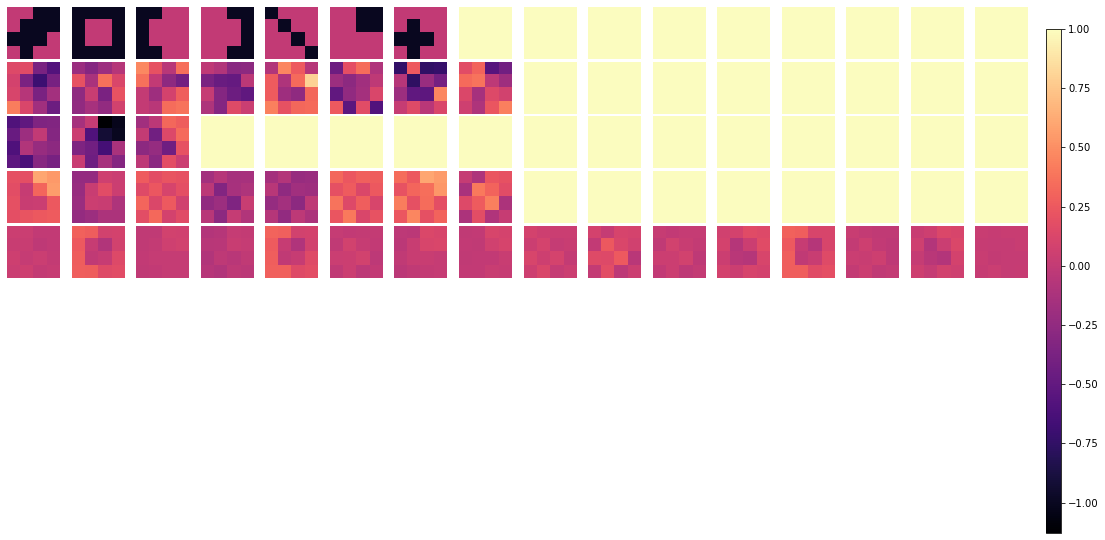

Epoch:  1 , Loss:  2.588146686553955 , Val Loss:  1.3611199855804443
Epoch:  50 , Loss:  0.21609994769096375 , Val Loss:  0.1445482224225998
Epoch:  100 , Loss:  0.18200983107089996 , Val Loss:  0.1334591954946518
Epoch:  150 , Loss:  0.15927137434482574 , Val Loss:  0.20833522081375122
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.0005, 19, False, False, 'selu', 200, 150]
(80, 16)


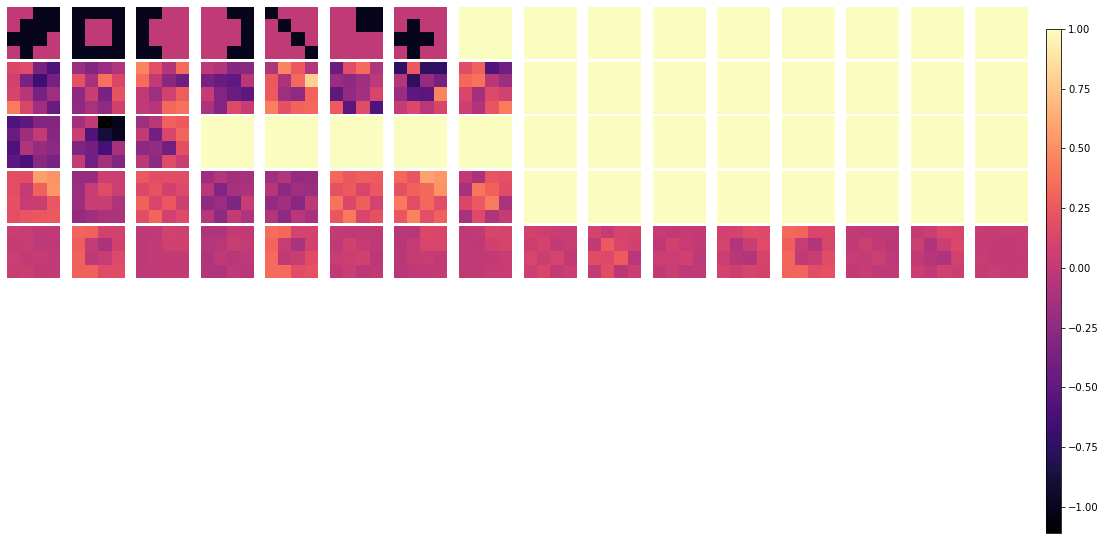

Epoch:  1 , Loss:  2.2541282176971436 , Val Loss:  1.5481152534484863
Epoch:  50 , Loss:  0.30017712712287903 , Val Loss:  0.23186641931533813
Epoch:  100 , Loss:  0.2284812033176422 , Val Loss:  0.3484814167022705
Epoch:  150 , Loss:  0.2061968296766281 , Val Loss:  0.3202434480190277
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.001, 19, True, True, 'selu', 200, 150]
(112, 16)


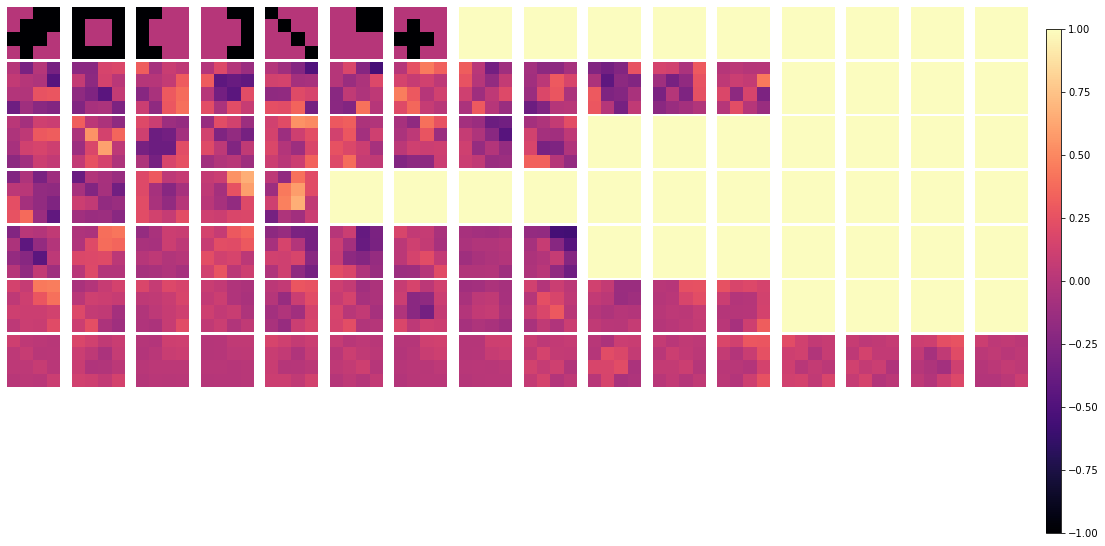

Epoch:  1 , Loss:  2.169113874435425 , Val Loss:  1.4636881351470947
Epoch:  50 , Loss:  0.2506488263607025 , Val Loss:  0.18033184111118317
Epoch:  100 , Loss:  0.2010834962129593 , Val Loss:  0.1435369849205017
Epoch:  150 , Loss:  0.16904325783252716 , Val Loss:  0.24829353392124176
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.001, 19, False, True, 'selu', 200, 150]
(112, 16)


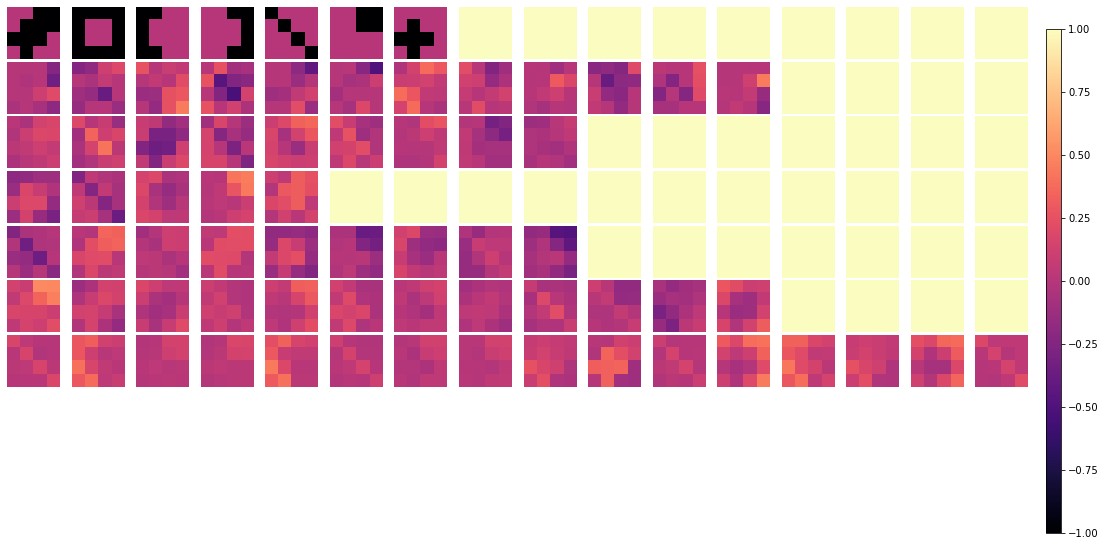

Epoch:  1 , Loss:  2.1638872623443604 , Val Loss:  1.458439826965332
Epoch:  50 , Loss:  0.2346605807542801 , Val Loss:  0.1750689148902893
Epoch:  100 , Loss:  0.16781733930110931 , Val Loss:  0.27197009325027466
Epoch:  150 , Loss:  0.14925704896450043 , Val Loss:  0.25997811555862427
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.001, 19, True, False, 'selu', 200, 150]
(112, 16)


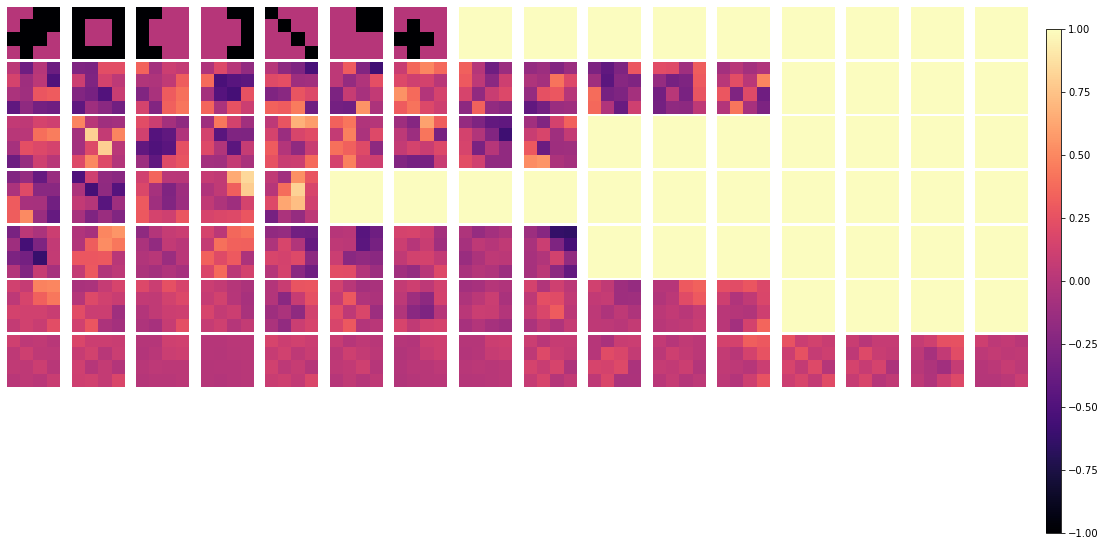

Epoch:  1 , Loss:  2.0788745880126953 , Val Loss:  1.3740651607513428
Epoch:  50 , Loss:  0.18396593630313873 , Val Loss:  0.11466902494430542
Epoch:  100 , Loss:  0.14613118767738342 , Val Loss:  0.08646930009126663
Epoch:  150 , Loss:  0.12444926798343658 , Val Loss:  0.201975017786026
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.001, 19, False, False, 'selu', 200, 150]
(112, 16)


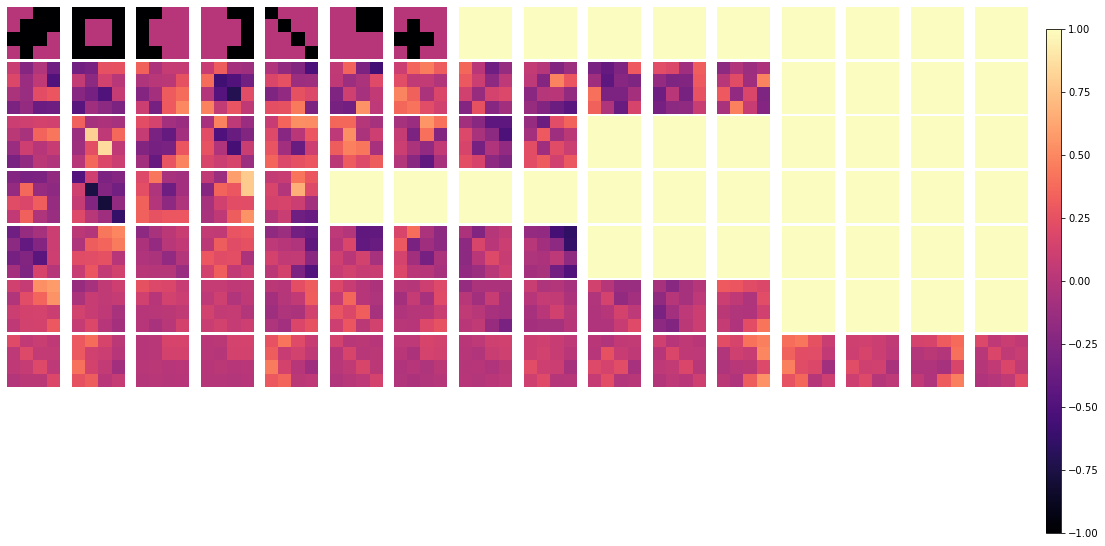

Epoch:  1 , Loss:  2.1664254665374756 , Val Loss:  1.4607934951782227
Epoch:  50 , Loss:  0.2544456124305725 , Val Loss:  0.1800907999277115
Epoch:  100 , Loss:  0.19567613303661346 , Val Loss:  0.2803502678871155
Epoch:  150 , Loss:  0.171291321516037 , Val Loss:  0.2695312201976776
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, True, True, 'selu', 200, 150]
(112, 16)


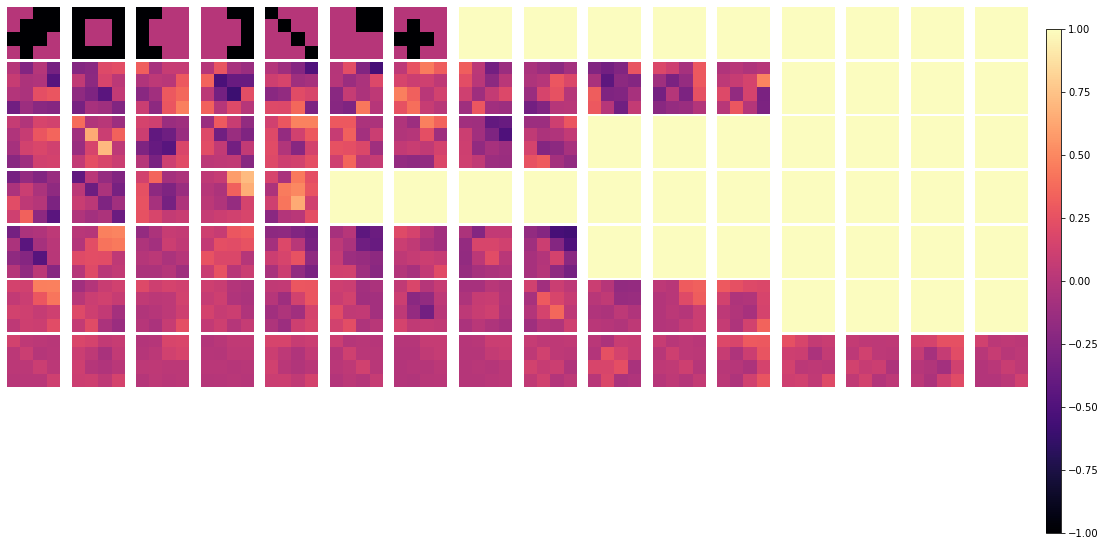

Epoch:  1 , Loss:  2.124002456665039 , Val Loss:  1.4188770055770874
Epoch:  50 , Loss:  0.22109529376029968 , Val Loss:  0.15027260780334473
Epoch:  100 , Loss:  0.1760255992412567 , Val Loss:  0.11706902831792831
Epoch:  150 , Loss:  0.1491355448961258 , Val Loss:  0.21026650071144104
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, False, True, 'selu', 200, 150]
(112, 16)


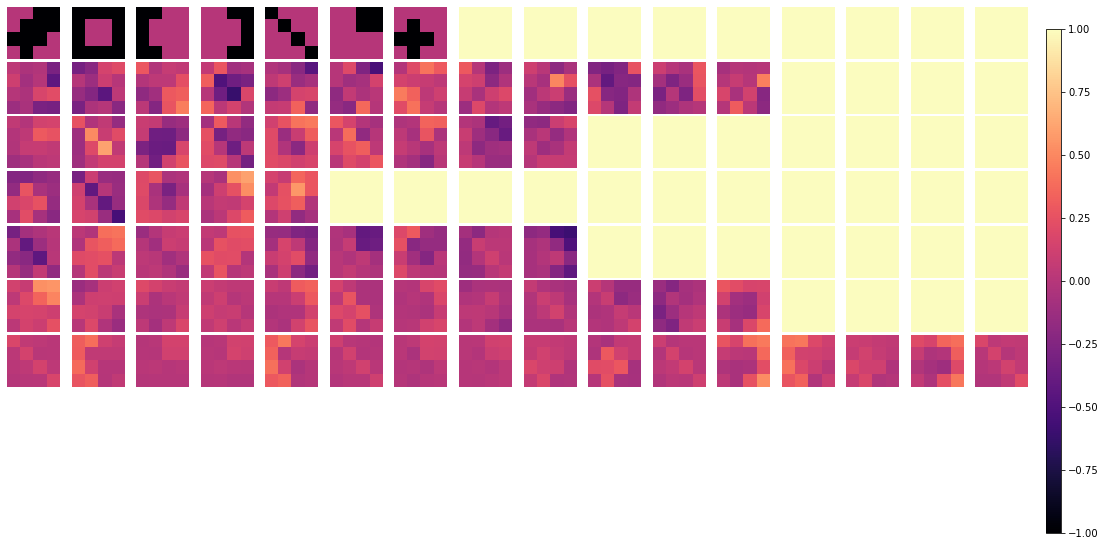

Epoch:  1 , Loss:  2.1212923526763916 , Val Loss:  1.4158600568771362
Epoch:  50 , Loss:  0.21827472746372223 , Val Loss:  0.14884896576404572
Epoch:  100 , Loss:  0.16363032162189484 , Val Loss:  0.24003039300441742
Epoch:  150 , Loss:  0.14798571169376373 , Val Loss:  0.23584775626659393
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, True, False, 'selu', 200, 150]
(112, 16)


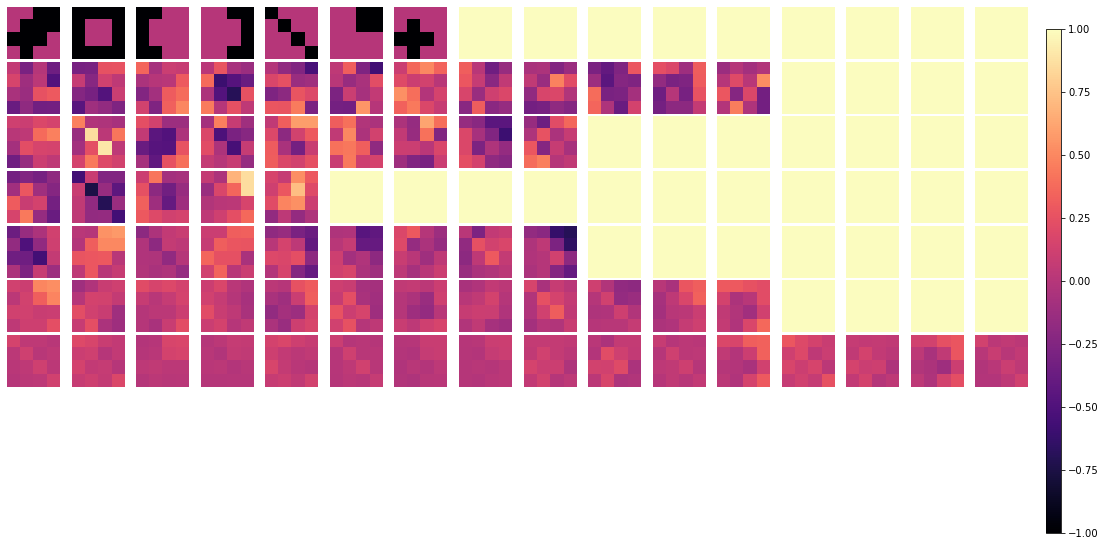

Epoch:  1 , Loss:  2.0788745880126953 , Val Loss:  1.3740651607513428
Epoch:  50 , Loss:  0.18396593630313873 , Val Loss:  0.11466902494430542
Epoch:  100 , Loss:  0.14613118767738342 , Val Loss:  0.08646930009126663
Epoch:  150 , Loss:  0.12444926798343658 , Val Loss:  0.201975017786026
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, False, False, 'selu', 200, 150]
(112, 16)


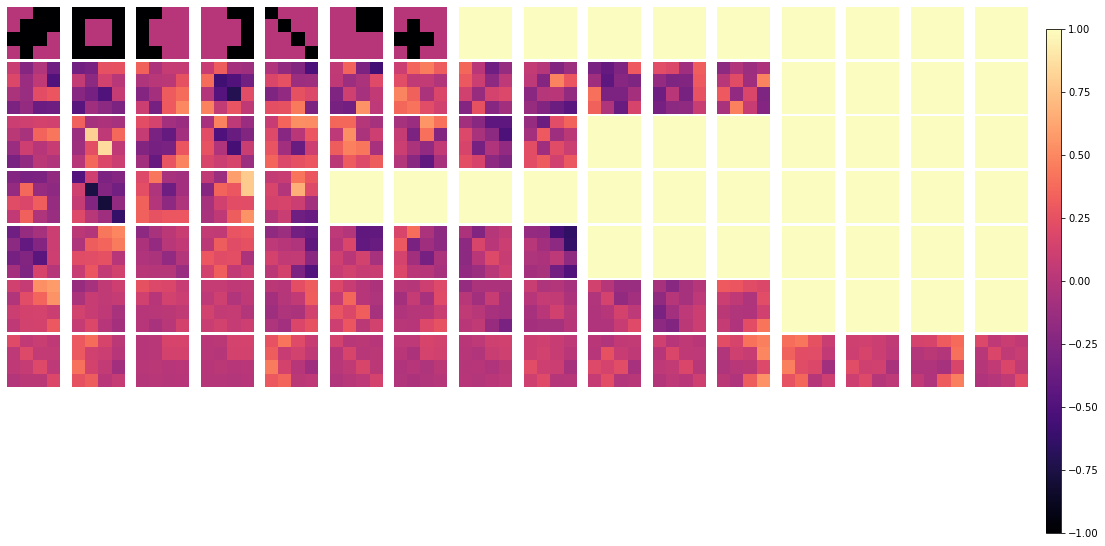

In [76]:
### Model Selection...kinda :)
arches = [[16,14,12,10,8,6,4,6,8,10,12,14,16], [16, 8, 3, 8, 16], [16, 12, 9, 5, 9, 12, 16]]
rrs = [0.001, 0.0005]
encoder_regs = [True, False]
decoder_regs = [True, False]

for arch in arches:
    for rr in rrs:
        for decoder_reg in decoder_regs:
            for encoder_reg in encoder_regs:
                encoder_ae, decoder_ae, hparams = run_autoencoder(dropout=True, arch=arch, 
                                                                  decoder_reg=decoder_reg, 
                                                                  encoder_reg=encoder_reg, 
                                                                  rr=rr, seed=19, activ='selu')
                weights_ae = get_ae_weights(encoder_ae, decoder_ae)
                print(hparams)
                show_ae(weights_ae)

Epoch:  1 , Loss:  2.787827491760254 , Val Loss:  2.21982741355896
Epoch:  50 , Loss:  0.5522945523262024 , Val Loss:  0.5161505341529846
Epoch:  100 , Loss:  0.3351646661758423 , Val Loss:  0.3378492295742035
Epoch:  150 , Loss:  0.2624261975288391 , Val Loss:  0.2821429371833801
Epoch:  200 , Loss:  0.24976328015327454 , Val Loss:  0.2764059603214264
Epoch:  250 , Loss:  0.24992892146110535 , Val Loss:  0.27781420946121216
Epoch:  300 , Loss:  0.24876618385314941 , Val Loss:  0.28795912861824036
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.004, 19, True, True, 'selu', 300, 150]
(176, 16)


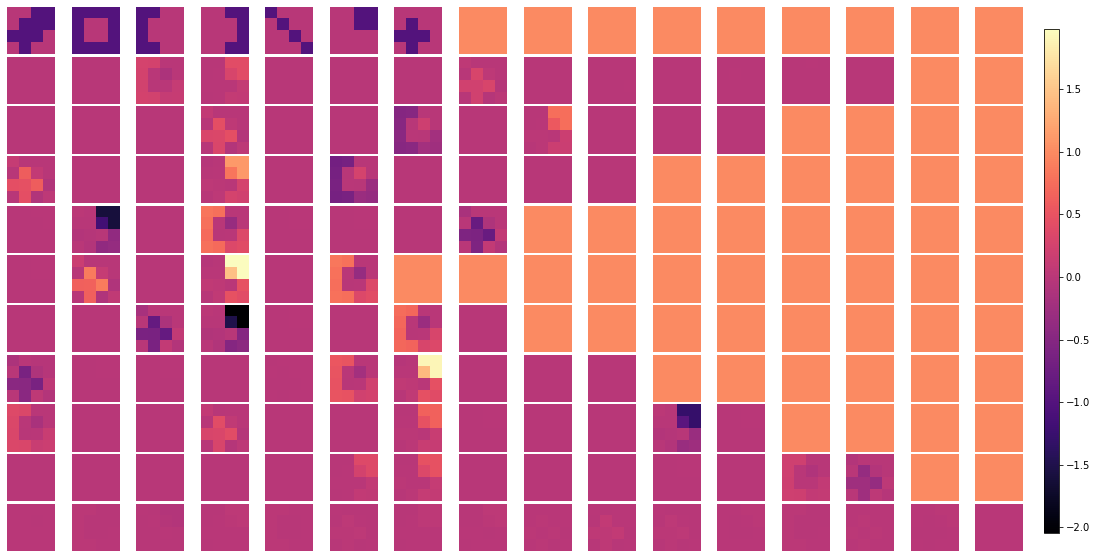

Epoch:  1 , Loss:  2.1545746326446533 , Val Loss:  1.5909132957458496
Epoch:  50 , Loss:  0.3421119749546051 , Val Loss:  0.3526430130004883
Epoch:  100 , Loss:  0.19689777493476868 , Val Loss:  0.24037675559520721
Epoch:  150 , Loss:  0.1572643667459488 , Val Loss:  0.21113623678684235
Epoch:  200 , Loss:  0.14183396100997925 , Val Loss:  0.2174079418182373
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.004, 19, False, True, 'selu', 300, 150]
(176, 16)


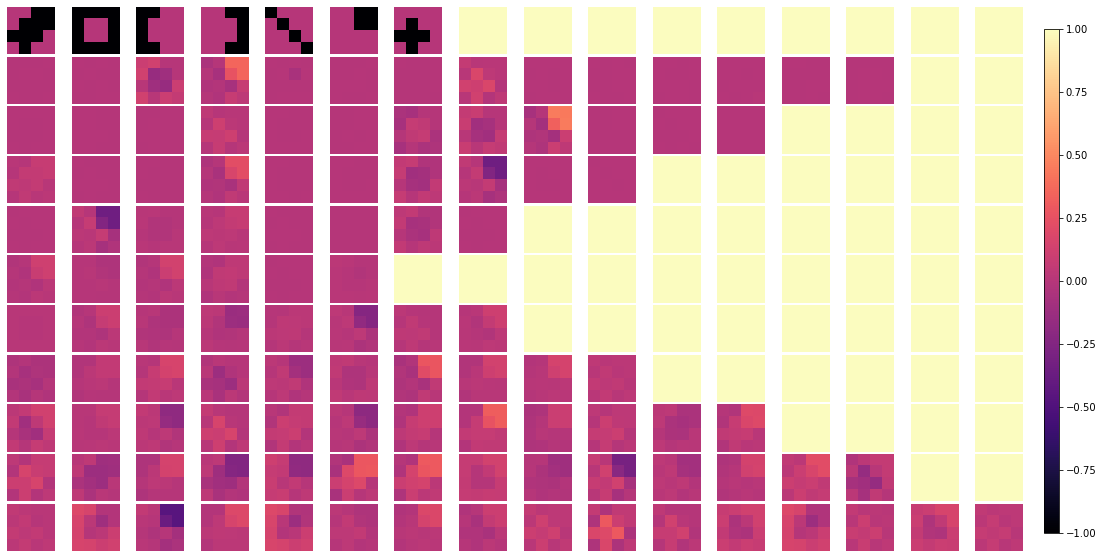

Epoch:  1 , Loss:  2.1406431198120117 , Val Loss:  1.5747318267822266
Epoch:  50 , Loss:  0.24180538952350616 , Val Loss:  0.24641597270965576
Epoch:  100 , Loss:  0.16659365594387054 , Val Loss:  0.17845755815505981
Epoch:  150 , Loss:  0.14561428129673004 , Val Loss:  0.15741829574108124
Epoch:  200 , Loss:  0.12416331470012665 , Val Loss:  0.12876786291599274
Epoch:  250 , Loss:  0.10697301477193832 , Val Loss:  0.09571665525436401
Epoch:  300 , Loss:  0.10044568032026291 , Val Loss:  0.08907182514667511
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.004, 19, True, False, 'selu', 300, 150]
(176, 16)


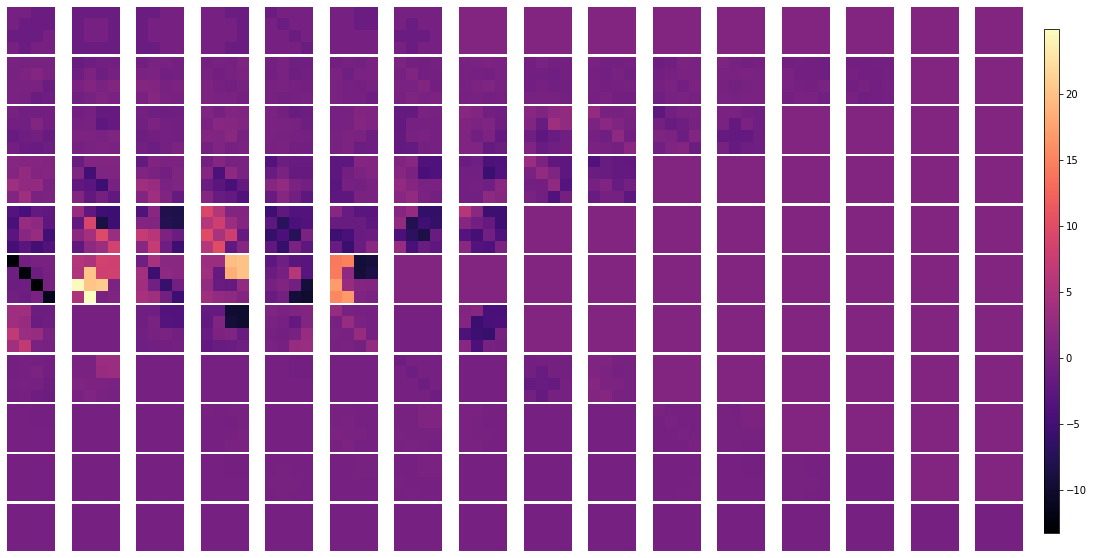

Epoch:  1 , Loss:  1.5073572397232056 , Val Loss:  0.9458754658699036
Epoch:  50 , Loss:  0.10544927418231964 , Val Loss:  0.10991183668375015
Epoch:  100 , Loss:  0.06630932539701462 , Val Loss:  0.11412296444177628
Epoch:  150 , Loss:  0.04332651197910309 , Val Loss:  0.10162270814180374
Epoch:  200 , Loss:  0.03393152356147766 , Val Loss:  0.10405230522155762
Epoch:  250 , Loss:  0.029258476570248604 , Val Loss:  0.09020966291427612
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.004, 19, False, False, 'selu', 300, 150]
(176, 16)


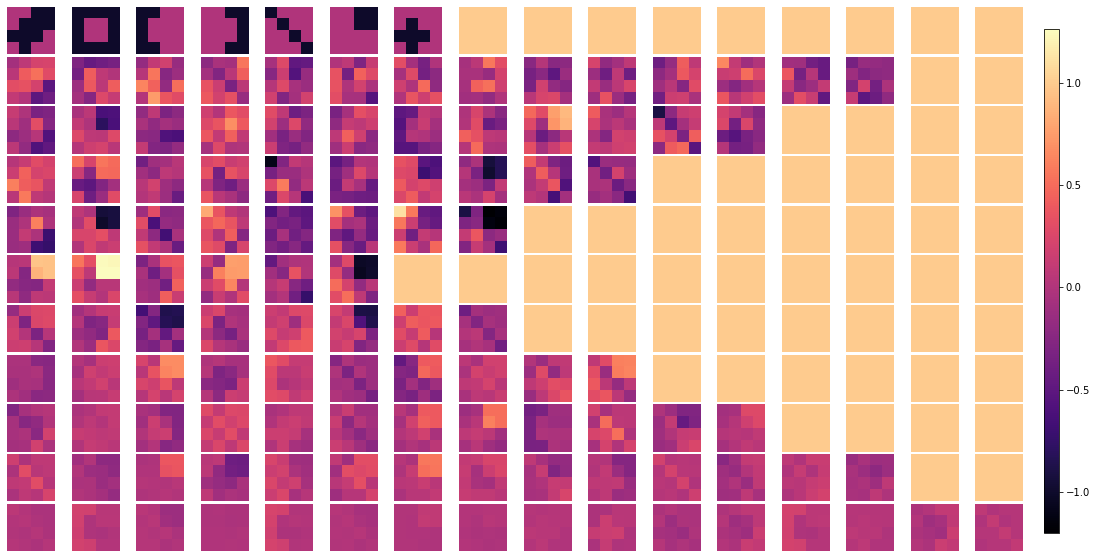

Epoch:  1 , Loss:  2.1484222412109375 , Val Loss:  1.5850962400436401
Epoch:  50 , Loss:  0.43038395047187805 , Val Loss:  0.41805559396743774
Epoch:  100 , Loss:  0.28912457823753357 , Val Loss:  0.3110211491584778
Epoch:  150 , Loss:  0.22713513672351837 , Val Loss:  0.24624520540237427
Epoch:  200 , Loss:  0.19481182098388672 , Val Loss:  0.22565747797489166
Epoch:  250 , Loss:  0.18752723932266235 , Val Loss:  0.21116097271442413
Epoch:  300 , Loss:  0.18358685076236725 , Val Loss:  0.23414023220539093
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.002, 19, True, True, 'selu', 300, 150]
(176, 16)


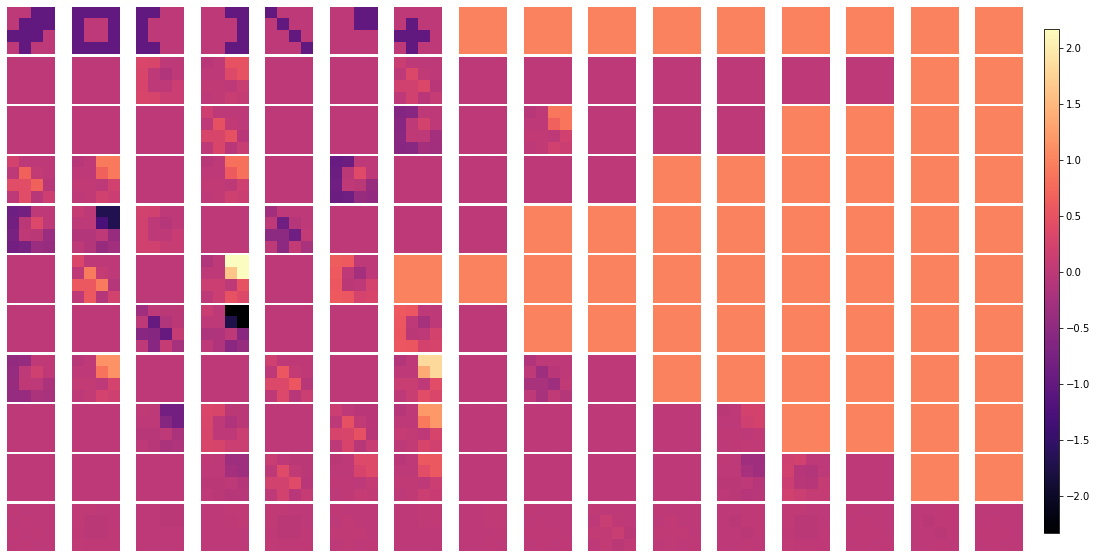

Epoch:  1 , Loss:  1.8312649726867676 , Val Loss:  1.2691426277160645
Epoch:  50 , Loss:  0.28355690836906433 , Val Loss:  0.2950385808944702
Epoch:  100 , Loss:  0.18412500619888306 , Val Loss:  0.2198495715856552
Epoch:  150 , Loss:  0.143117755651474 , Val Loss:  0.21172815561294556
Epoch:  200 , Loss:  0.1278109848499298 , Val Loss:  0.2105638086795807
Epoch:  250 , Loss:  0.12267541140317917 , Val Loss:  0.21317309141159058
Epoch:  300 , Loss:  0.11884688585996628 , Val Loss:  0.20096494257450104
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.002, 19, False, True, 'selu', 300, 150]
(176, 16)


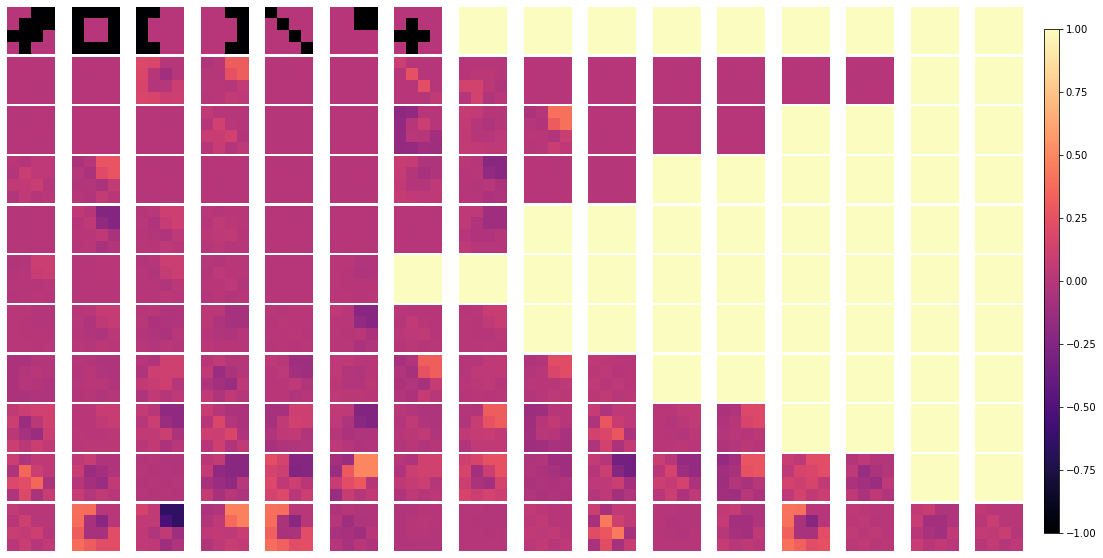

Epoch:  1 , Loss:  1.8245114088058472 , Val Loss:  1.2619513273239136
Epoch:  50 , Loss:  0.2202543467283249 , Val Loss:  0.24823811650276184
Epoch:  100 , Loss:  0.15690019726753235 , Val Loss:  0.20820090174674988
Epoch:  150 , Loss:  0.13194052875041962 , Val Loss:  0.17951548099517822
Epoch:  200 , Loss:  0.11329470574855804 , Val Loss:  0.1529558300971985
Epoch:  250 , Loss:  0.10356888920068741 , Val Loss:  0.12191048264503479
Epoch:  300 , Loss:  0.09827663749456406 , Val Loss:  0.12884628772735596
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.002, 19, True, False, 'selu', 300, 150]
(176, 16)


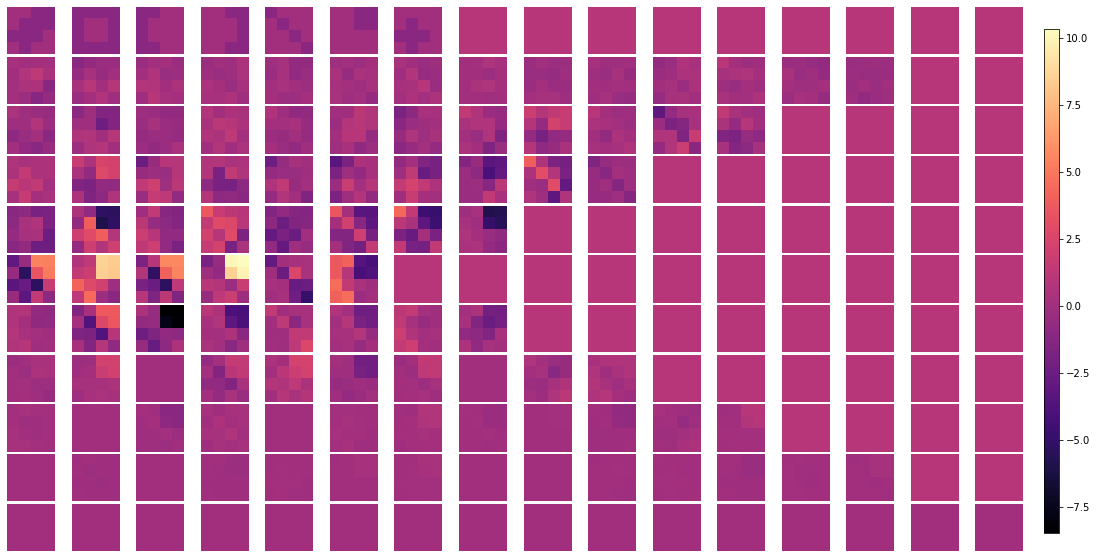

Epoch:  1 , Loss:  1.5073572397232056 , Val Loss:  0.9458754658699036
Epoch:  50 , Loss:  0.10544927418231964 , Val Loss:  0.10991183668375015
Epoch:  100 , Loss:  0.06630932539701462 , Val Loss:  0.11412296444177628
Epoch:  150 , Loss:  0.04332651197910309 , Val Loss:  0.10162270814180374
Epoch:  200 , Loss:  0.03393152356147766 , Val Loss:  0.10405230522155762
Epoch:  250 , Loss:  0.029258476570248604 , Val Loss:  0.09020966291427612
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.002, 19, False, False, 'selu', 300, 150]
(176, 16)


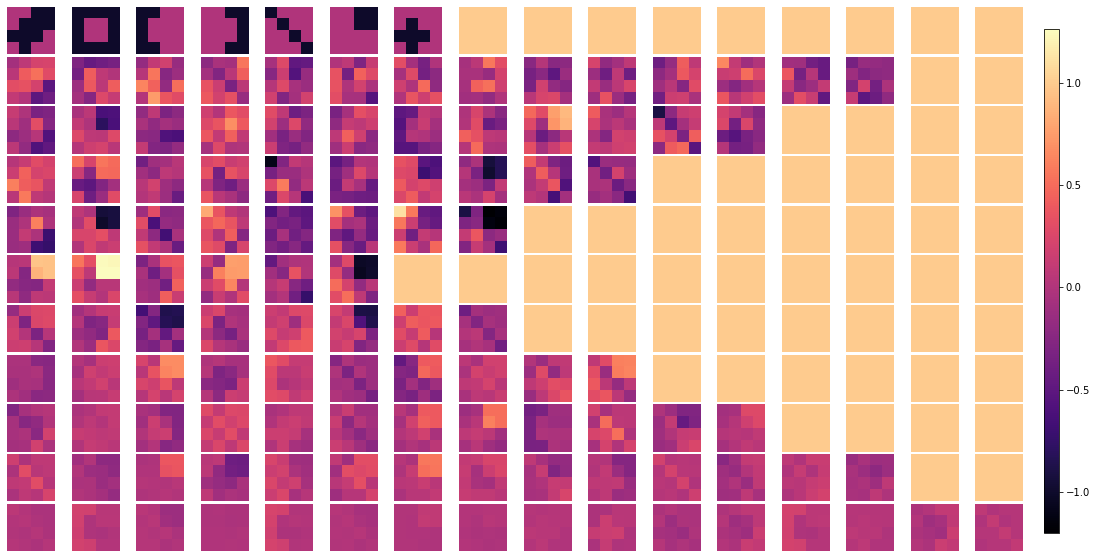

Epoch:  1 , Loss:  1.7962778806686401 , Val Loss:  1.2342153787612915
Epoch:  50 , Loss:  0.2875837981700897 , Val Loss:  0.2841031551361084
Epoch:  100 , Loss:  0.22660301625728607 , Val Loss:  0.25454530119895935
Epoch:  150 , Loss:  0.19176949560642242 , Val Loss:  0.21390195190906525
Epoch:  200 , Loss:  0.16261015832424164 , Val Loss:  0.20644834637641907
Epoch:  250 , Loss:  0.1478569358587265 , Val Loss:  0.16521349549293518
Epoch:  300 , Loss:  0.1355419009923935 , Val Loss:  0.1747310310602188
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0009, 19, True, True, 'selu', 300, 150]
(176, 16)


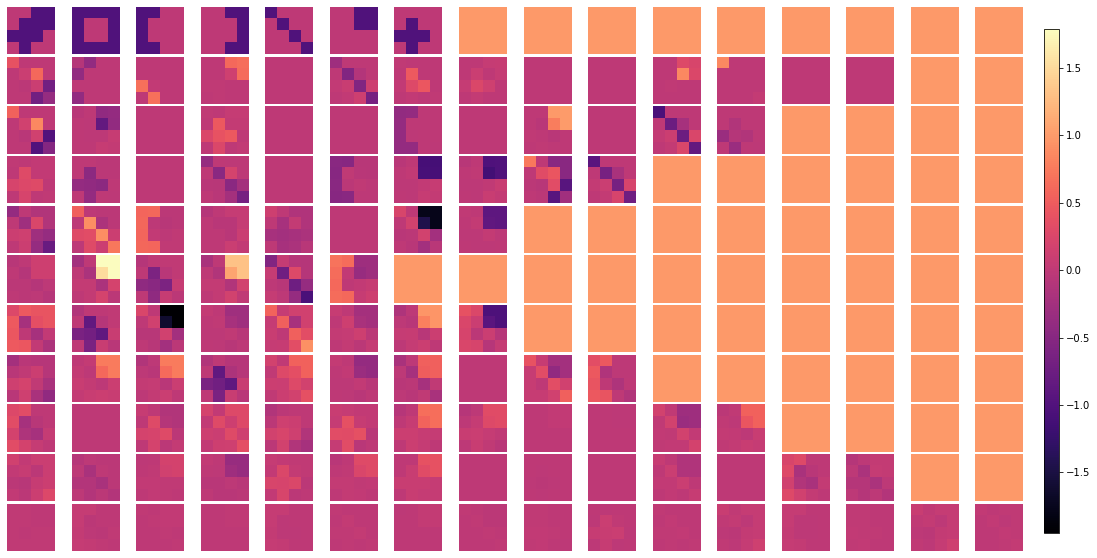

Epoch:  1 , Loss:  1.653387188911438 , Val Loss:  1.0918608903884888
Epoch:  50 , Loss:  0.2133588194847107 , Val Loss:  0.22720637917518616
Epoch:  100 , Loss:  0.14559774100780487 , Val Loss:  0.17724353075027466
Epoch:  150 , Loss:  0.11103053390979767 , Val Loss:  0.1568206548690796
Epoch:  200 , Loss:  0.09256424754858017 , Val Loss:  0.1439841091632843
Epoch:  250 , Loss:  0.08010394871234894 , Val Loss:  0.14068128168582916
Epoch:  300 , Loss:  0.07313444465398788 , Val Loss:  0.1235652044415474
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0009, 19, False, True, 'selu', 300, 150]
(176, 16)


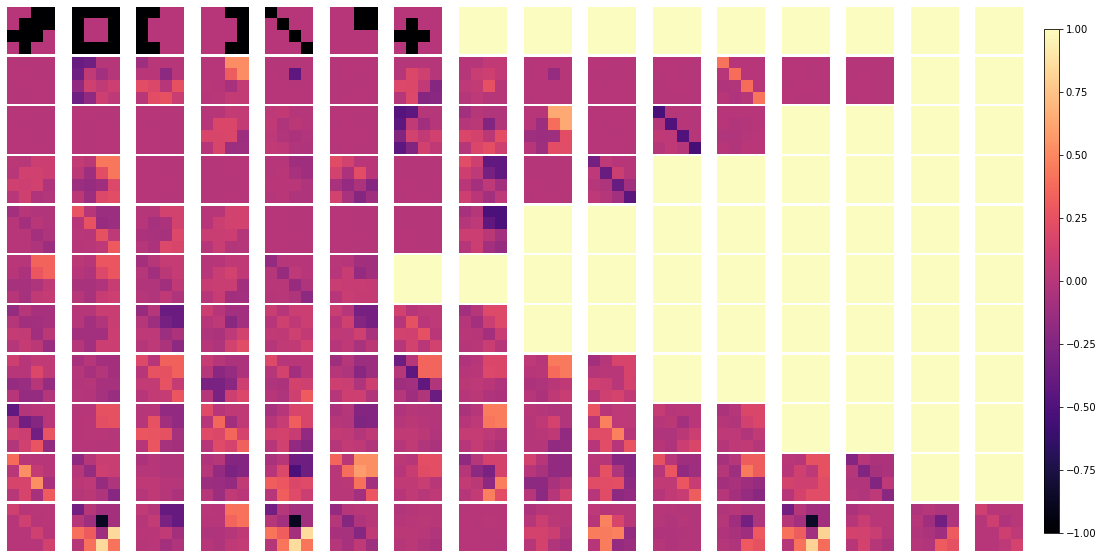

Epoch:  1 , Loss:  1.650217056274414 , Val Loss:  1.0883501768112183
Epoch:  50 , Loss:  0.17279408872127533 , Val Loss:  0.17867541313171387
Epoch:  100 , Loss:  0.1329083889722824 , Val Loss:  0.14904335141181946
Epoch:  150 , Loss:  0.1088225245475769 , Val Loss:  0.14374054968357086
Epoch:  200 , Loss:  0.08951952308416367 , Val Loss:  0.1494103968143463
Epoch:  250 , Loss:  0.08037581294775009 , Val Loss:  0.11280477046966553
Epoch:  300 , Loss:  0.07304073870182037 , Val Loss:  0.11497016251087189
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0009, 19, True, False, 'selu', 300, 150]
(176, 16)


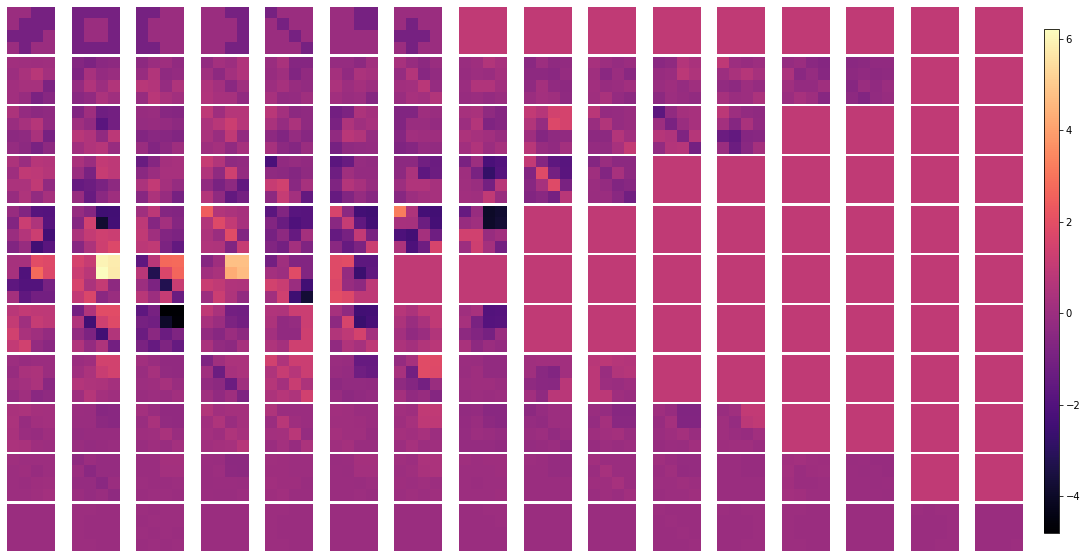

Epoch:  1 , Loss:  1.5073572397232056 , Val Loss:  0.9458754658699036
Epoch:  50 , Loss:  0.10544927418231964 , Val Loss:  0.10991183668375015
Epoch:  100 , Loss:  0.06630932539701462 , Val Loss:  0.11412296444177628
Epoch:  150 , Loss:  0.04332651197910309 , Val Loss:  0.10162270814180374
Epoch:  200 , Loss:  0.03393152356147766 , Val Loss:  0.10405230522155762
Epoch:  250 , Loss:  0.029258476570248604 , Val Loss:  0.09020966291427612
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0009, 19, False, False, 'selu', 300, 150]
(176, 16)


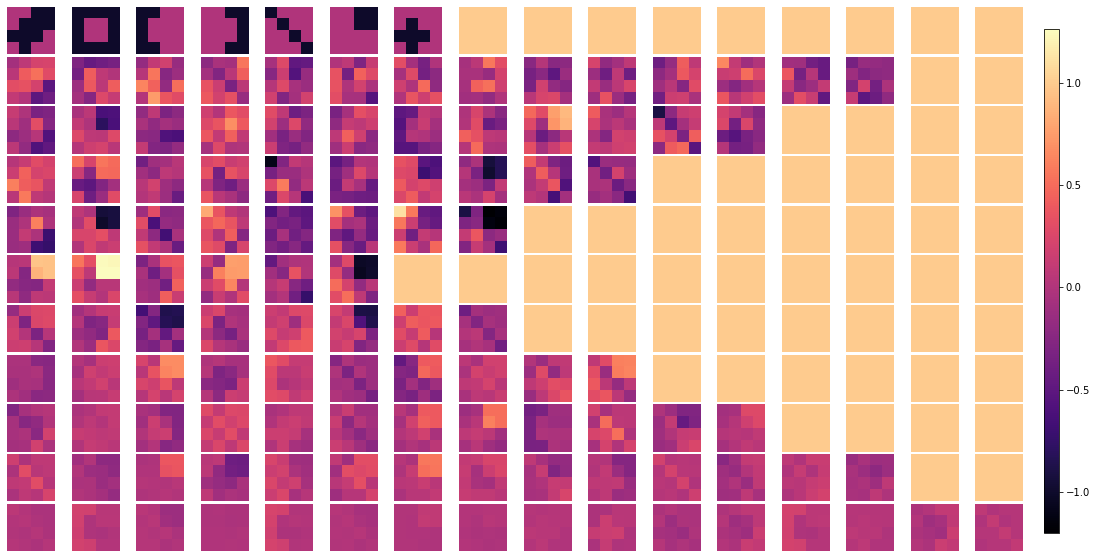

Epoch:  1 , Loss:  2.682551622390747 , Val Loss:  2.033292531967163
Epoch:  50 , Loss:  0.4323102831840515 , Val Loss:  0.3795532286167145
Epoch:  100 , Loss:  0.31907376646995544 , Val Loss:  0.2709515690803528
Epoch:  150 , Loss:  0.2691737115383148 , Val Loss:  0.224164679646492
Epoch:  200 , Loss:  0.24635158479213715 , Val Loss:  0.2073601931333542
Epoch:  250 , Loss:  0.22549651563167572 , Val Loss:  0.1842675358057022
Epoch:  300 , Loss:  0.22471673786640167 , Val Loss:  0.18212471902370453
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.004, 19, True, True, 'selu', 300, 150]
(112, 16)


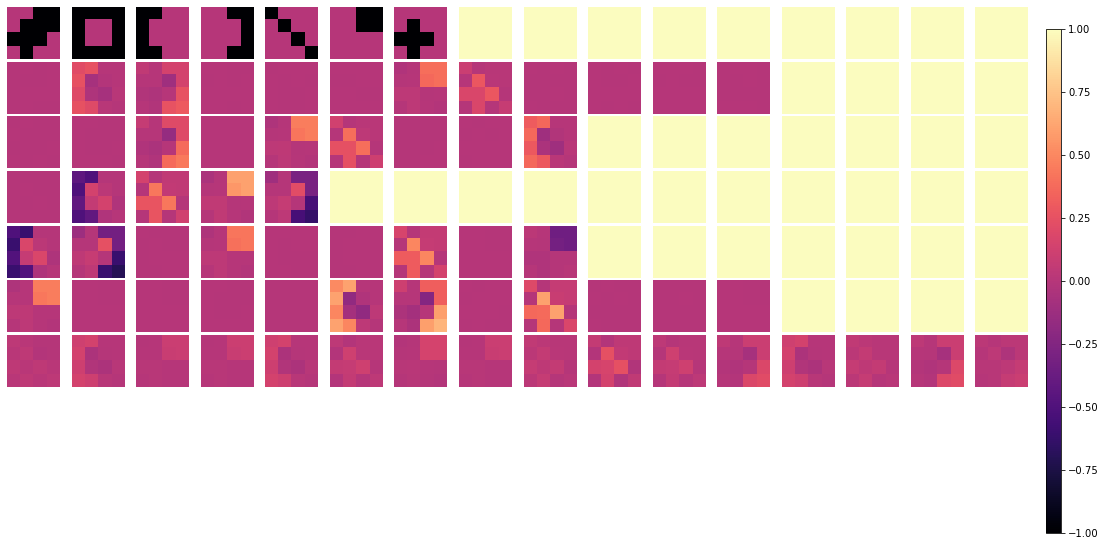

Epoch:  1 , Loss:  2.342406749725342 , Val Loss:  1.6967021226882935
Epoch:  50 , Loss:  0.26393556594848633 , Val Loss:  0.21157149970531464
Epoch:  100 , Loss:  0.17983175814151764 , Val Loss:  0.12865830957889557
Epoch:  150 , Loss:  0.14741913974285126 , Val Loss:  0.10263838618993759
Epoch:  200 , Loss:  0.12430890649557114 , Val Loss:  0.09736558049917221
Epoch:  250 , Loss:  0.10818381607532501 , Val Loss:  0.1045713722705841
Epoch:  300 , Loss:  0.1002548485994339 , Val Loss:  0.125276118516922
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.004, 19, False, True, 'selu', 300, 150]
(112, 16)


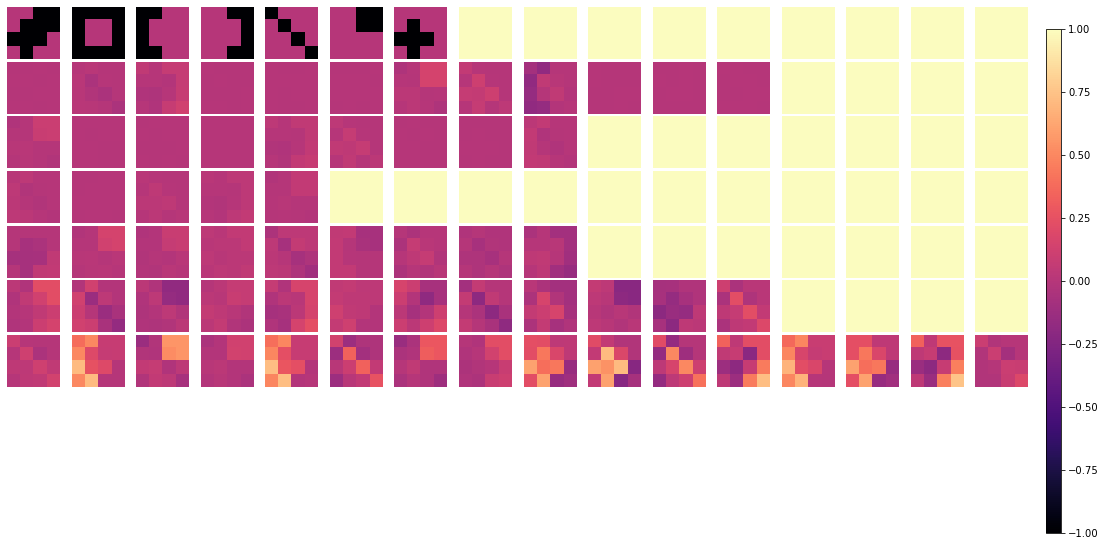

Epoch:  1 , Loss:  2.3219075202941895 , Val Loss:  1.6752300262451172
Epoch:  50 , Loss:  0.21955011785030365 , Val Loss:  0.16113360226154327
Epoch:  100 , Loss:  0.15153685212135315 , Val Loss:  0.1000070795416832
Epoch:  150 , Loss:  0.13394272327423096 , Val Loss:  0.08586173504590988
Epoch:  200 , Loss:  0.12413598597049713 , Val Loss:  0.07890689373016357
Epoch:  250 , Loss:  0.12120921164751053 , Val Loss:  0.07578811049461365
Epoch:  300 , Loss:  0.11984846740961075 , Val Loss:  0.07314655929803848
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.004, 19, True, False, 'selu', 300, 150]
(112, 16)


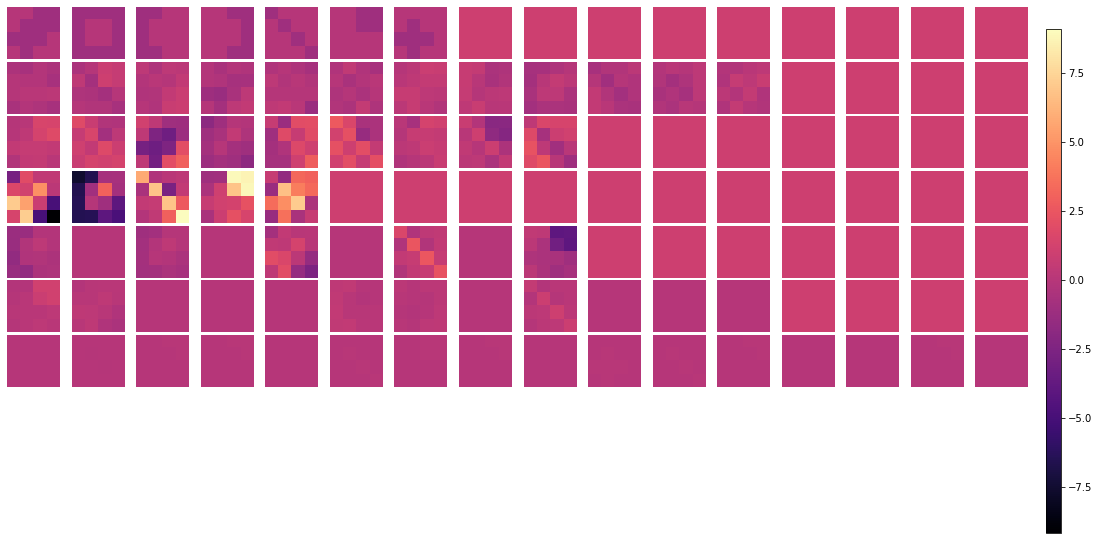

Epoch:  1 , Loss:  1.9817538261413574 , Val Loss:  1.338645100593567
Epoch:  50 , Loss:  0.10366662591695786 , Val Loss:  0.05033526569604874
Epoch:  100 , Loss:  0.08144011348485947 , Val Loss:  0.03132835775613785
Epoch:  150 , Loss:  0.06780790537595749 , Val Loss:  0.024818364530801773
Epoch:  200 , Loss:  0.05216100439429283 , Val Loss:  0.03127894178032875
Epoch:  250 , Loss:  0.04348120465874672 , Val Loss:  0.0467165932059288
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.004, 19, False, False, 'selu', 300, 150]
(112, 16)


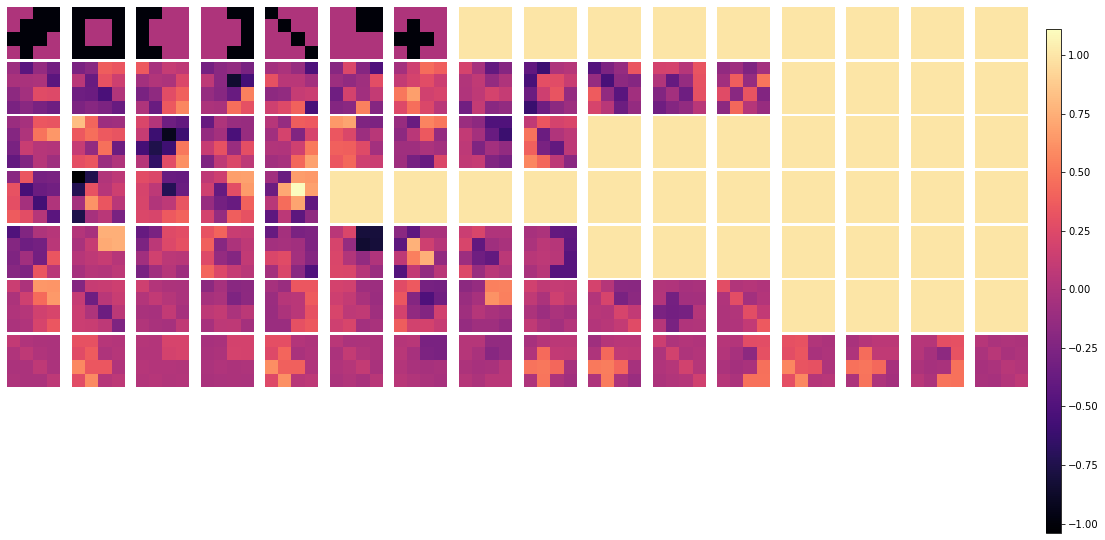

Epoch:  1 , Loss:  2.3322250843048096 , Val Loss:  1.6862428188323975
Epoch:  50 , Loss:  0.315456748008728 , Val Loss:  0.2592187225818634
Epoch:  100 , Loss:  0.24122241139411926 , Val Loss:  0.1959114372730255
Epoch:  150 , Loss:  0.198849156498909 , Val Loss:  0.1952887624502182
Epoch:  200 , Loss:  0.1727922260761261 , Val Loss:  0.17743200063705444
Epoch:  250 , Loss:  0.1631084531545639 , Val Loss:  0.16728100180625916
Epoch:  300 , Loss:  0.15030932426452637 , Val Loss:  0.15790008008480072
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.002, 19, True, True, 'selu', 300, 150]
(112, 16)


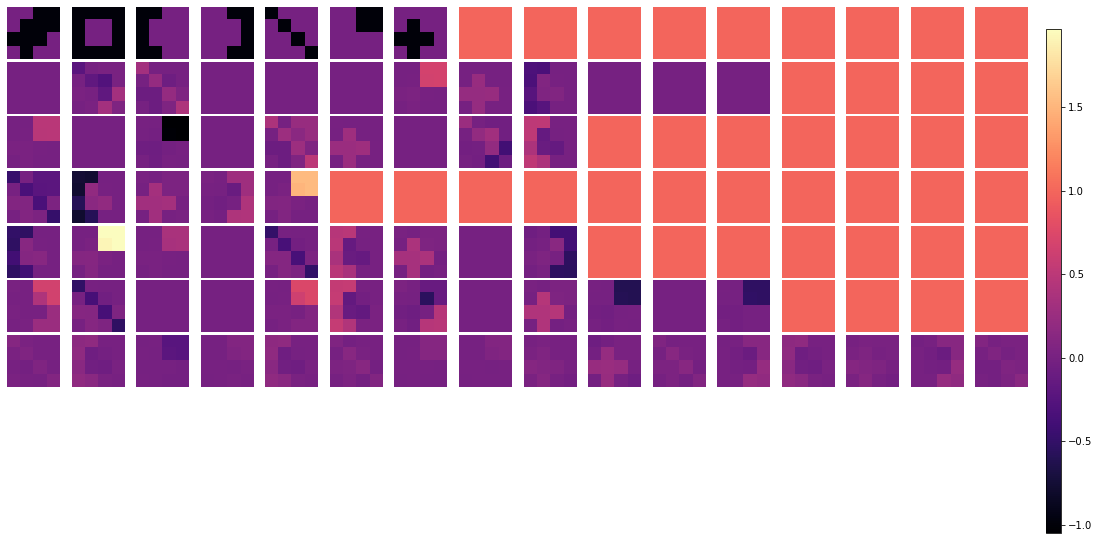

Epoch:  1 , Loss:  2.162078619003296 , Val Loss:  1.5177690982818604
Epoch:  50 , Loss:  0.2147648185491562 , Val Loss:  0.1629335880279541
Epoch:  100 , Loss:  0.15767456591129303 , Val Loss:  0.11356447637081146
Epoch:  150 , Loss:  0.12793856859207153 , Val Loss:  0.09408602863550186
Epoch:  200 , Loss:  0.10332243889570236 , Val Loss:  0.11544130742549896
Epoch:  250 , Loss:  0.0922931432723999 , Val Loss:  0.11475276947021484
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.002, 19, False, True, 'selu', 300, 150]
(112, 16)


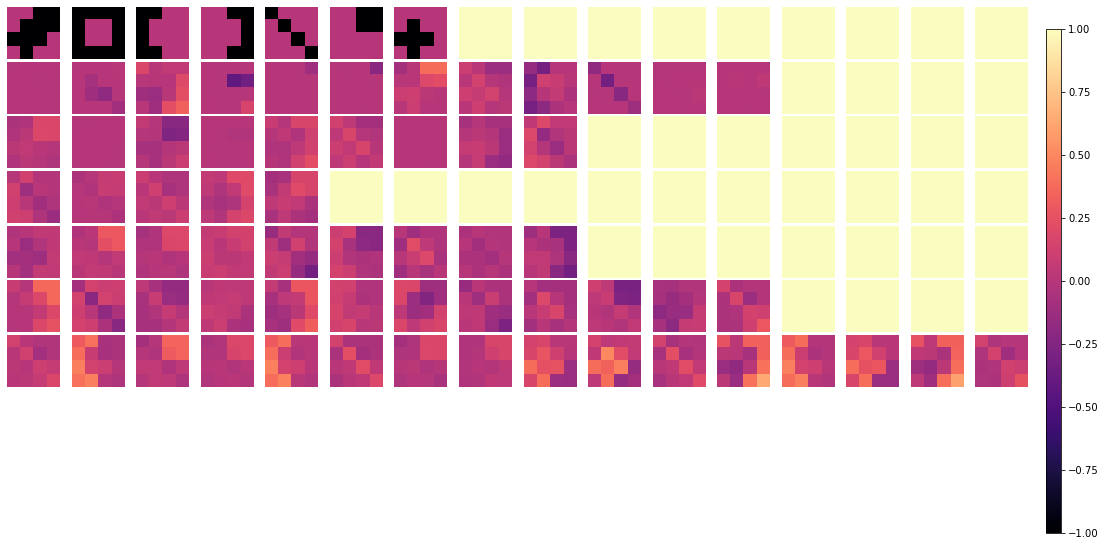

Epoch:  1 , Loss:  2.1518821716308594 , Val Loss:  1.5068763494491577
Epoch:  50 , Loss:  0.18995803594589233 , Val Loss:  0.1328943520784378
Epoch:  100 , Loss:  0.13153937458992004 , Val Loss:  0.14504258334636688
Epoch:  150 , Loss:  0.10954559594392776 , Val Loss:  0.13438664376735687
Epoch:  200 , Loss:  0.09806936234235764 , Val Loss:  0.12419239431619644
Epoch:  250 , Loss:  0.09252134710550308 , Val Loss:  0.11537700146436691
Epoch:  300 , Loss:  0.08650130033493042 , Val Loss:  0.11413948237895966
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.002, 19, True, False, 'selu', 300, 150]
(112, 16)


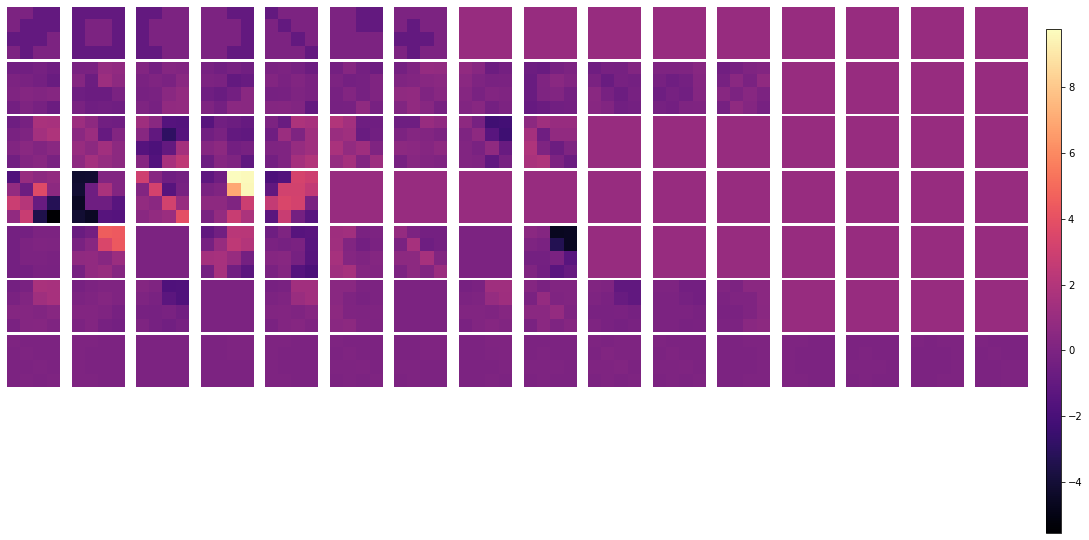

Epoch:  1 , Loss:  1.9817538261413574 , Val Loss:  1.338645100593567
Epoch:  50 , Loss:  0.10366662591695786 , Val Loss:  0.05033526569604874
Epoch:  100 , Loss:  0.08144011348485947 , Val Loss:  0.03132835775613785
Epoch:  150 , Loss:  0.06780790537595749 , Val Loss:  0.024818364530801773
Epoch:  200 , Loss:  0.05216100439429283 , Val Loss:  0.03127894178032875
Epoch:  250 , Loss:  0.04348120465874672 , Val Loss:  0.0467165932059288
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.002, 19, False, False, 'selu', 300, 150]
(112, 16)


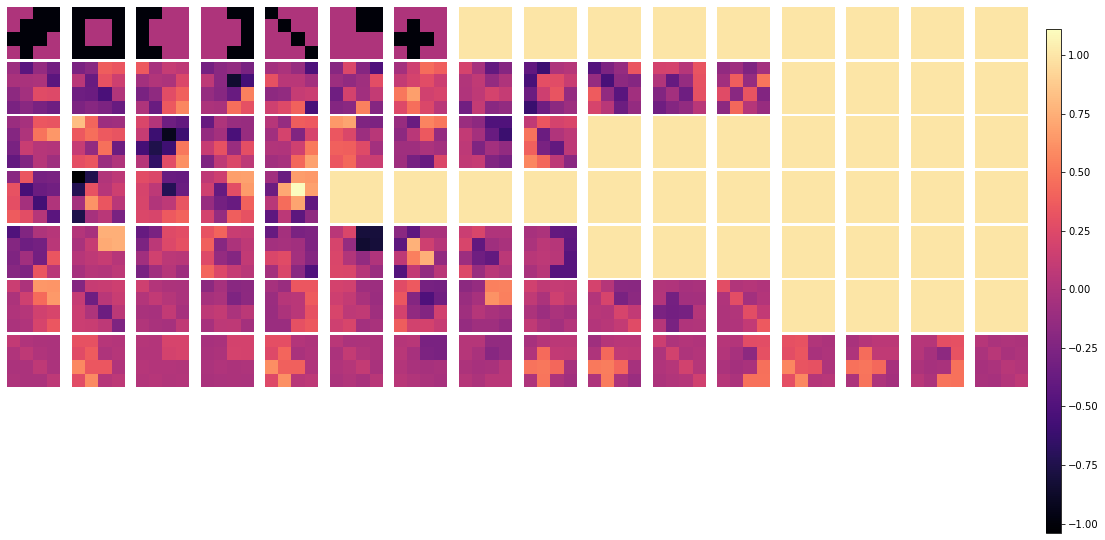

Epoch:  1 , Loss:  2.1395108699798584 , Val Loss:  1.4952483177185059
Epoch:  50 , Loss:  0.22234119474887848 , Val Loss:  0.16641061007976532
Epoch:  100 , Loss:  0.17400586605072021 , Val Loss:  0.1543882191181183
Epoch:  150 , Loss:  0.14947155117988586 , Val Loss:  0.1460190862417221
Epoch:  200 , Loss:  0.13200753927230835 , Val Loss:  0.1496264487504959
Epoch:  250 , Loss:  0.12296279519796371 , Val Loss:  0.1503070890903473
Epoch:  300 , Loss:  0.11161734908819199 , Val Loss:  0.13637714087963104
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0009, 19, True, True, 'selu', 300, 150]
(112, 16)


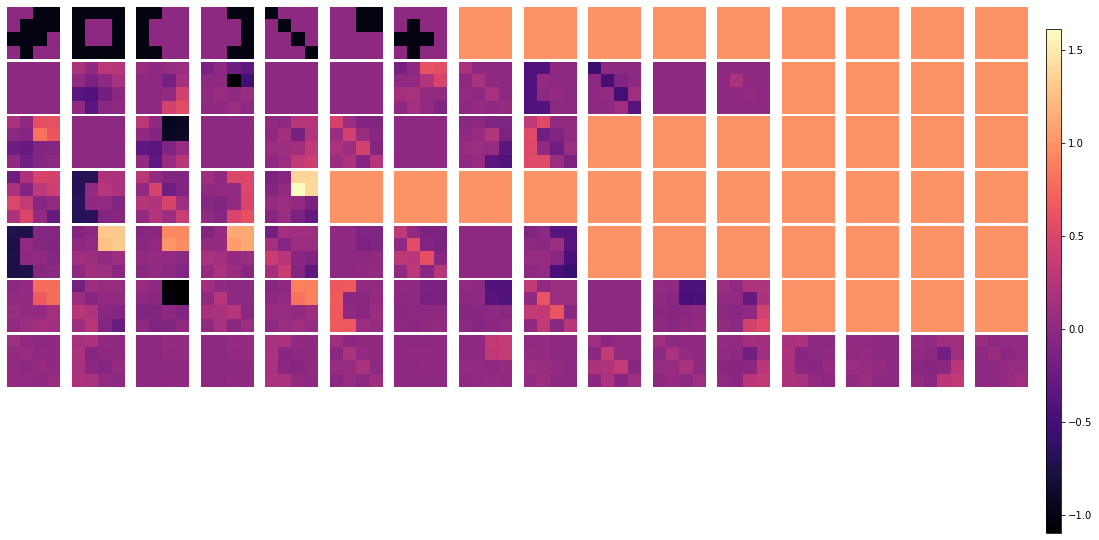

Epoch:  1 , Loss:  2.062877655029297 , Val Loss:  1.4192978143692017
Epoch:  50 , Loss:  0.16688372194766998 , Val Loss:  0.11371807008981705
Epoch:  100 , Loss:  0.12842120230197906 , Val Loss:  0.0780285969376564
Epoch:  150 , Loss:  0.10227266699075699 , Val Loss:  0.06460832804441452
Epoch:  200 , Loss:  0.07973240315914154 , Val Loss:  0.09254603087902069
Epoch:  250 , Loss:  0.07310285419225693 , Val Loss:  0.08994676917791367
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0009, 19, False, True, 'selu', 300, 150]
(112, 16)


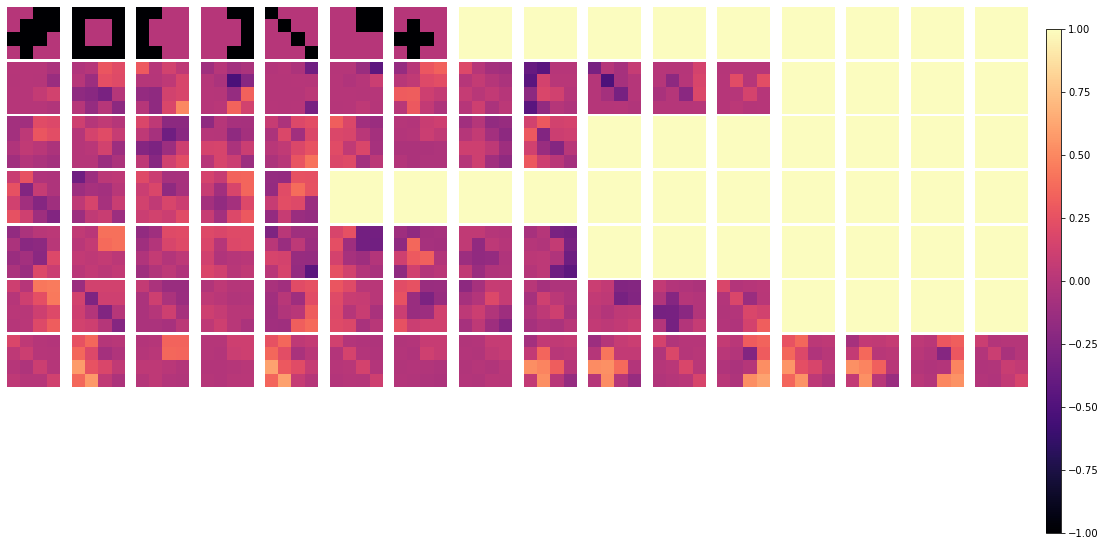

Epoch:  1 , Loss:  2.0583813190460205 , Val Loss:  1.4145539999008179
Epoch:  50 , Loss:  0.1561158299446106 , Val Loss:  0.10034558176994324
Epoch:  100 , Loss:  0.11184956133365631 , Val Loss:  0.09424594789743423
Epoch:  150 , Loss:  0.09407132863998413 , Val Loss:  0.07936525344848633
Epoch:  200 , Loss:  0.07972661405801773 , Val Loss:  0.0977397933602333
Epoch:  250 , Loss:  0.07529164850711823 , Val Loss:  0.09121065586805344
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0009, 19, True, False, 'selu', 300, 150]
(112, 16)


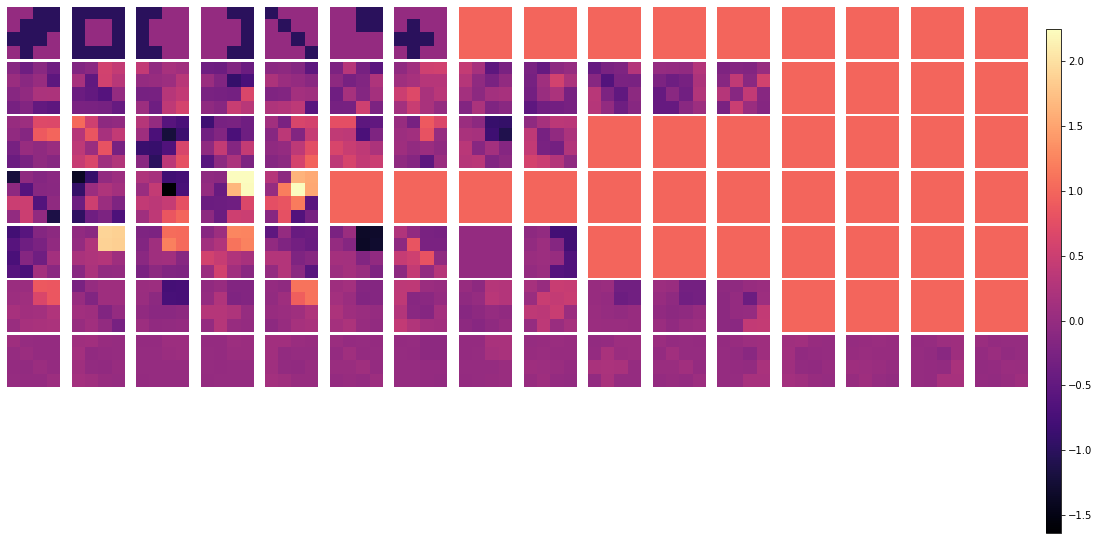

Epoch:  1 , Loss:  1.9817538261413574 , Val Loss:  1.338645100593567
Epoch:  50 , Loss:  0.10366662591695786 , Val Loss:  0.05033526569604874
Epoch:  100 , Loss:  0.08144011348485947 , Val Loss:  0.03132835775613785
Epoch:  150 , Loss:  0.06780790537595749 , Val Loss:  0.024818364530801773
Epoch:  200 , Loss:  0.05216100439429283 , Val Loss:  0.03127894178032875
Epoch:  250 , Loss:  0.04348120465874672 , Val Loss:  0.0467165932059288
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0009, 19, False, False, 'selu', 300, 150]
(112, 16)


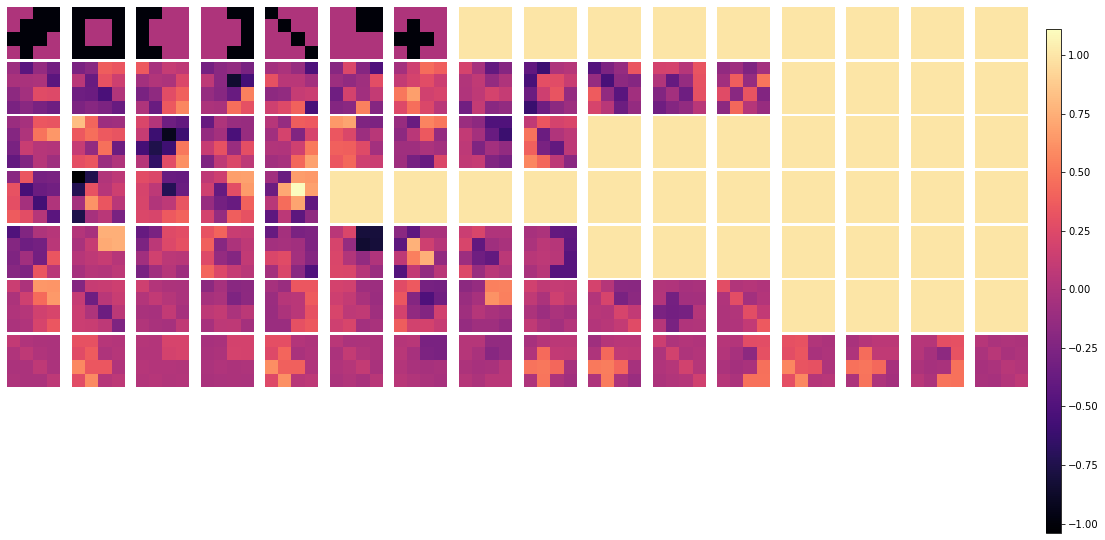

In [77]:
### Model Selection 2
arches = [[16,14,12,10,8,6,8,10,12,14,16], [16, 12, 9, 5, 9, 12, 16]]
rrs = [0.004, 0.002, 0.0009]
encoder_regs = [True, False]
decoder_regs = [True, False]
drop_rate = 0.3

for arch in arches:
    for rr in rrs:
        for decoder_reg in decoder_regs:
            for encoder_reg in encoder_regs:
                encoder_ae, decoder_ae, hparams = run_autoencoder(dropout=True, drop_rate=drop_rate, arch=arch, 
                                                                  decoder_reg=decoder_reg, 
                                                                  encoder_reg=encoder_reg, 
                                                                  e=300, rr=rr, seed=19, activ='selu')
                weights_ae = get_ae_weights(encoder_ae, decoder_ae)
                print(hparams)
                show_ae(weights_ae)

<a id='gaussian_ae'></a>

## Gaussian Noise

Epoch:  1 , Loss:  2.098851203918457 , Val Loss:  1.59125554561615
Epoch:  50 , Loss:  0.4072929620742798 , Val Loss:  0.3257441520690918
Epoch:  100 , Loss:  0.31836169958114624 , Val Loss:  0.24049800634384155
Epoch:  150 , Loss:  0.28311243653297424 , Val Loss:  0.20572957396507263
Epoch:  200 , Loss:  0.262743204832077 , Val Loss:  0.18499410152435303
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.001, 19, True, True, 'selu', 200, 150]
(208, 16)


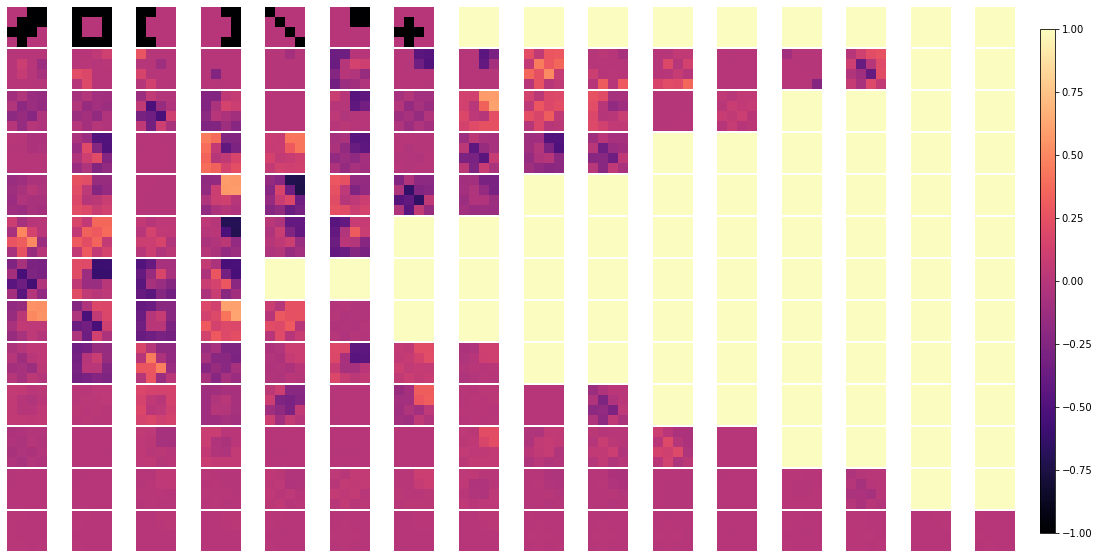

Epoch:  1 , Loss:  1.9532362222671509 , Val Loss:  1.4265886545181274
Epoch:  50 , Loss:  0.3069837689399719 , Val Loss:  0.23158174753189087
Epoch:  100 , Loss:  0.2573614716529846 , Val Loss:  0.17353007197380066
Epoch:  150 , Loss:  0.22974637150764465 , Val Loss:  0.1511019617319107
Epoch:  200 , Loss:  0.21427005529403687 , Val Loss:  0.1357019543647766
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.001, 19, False, True, 'selu', 200, 150]
(208, 16)


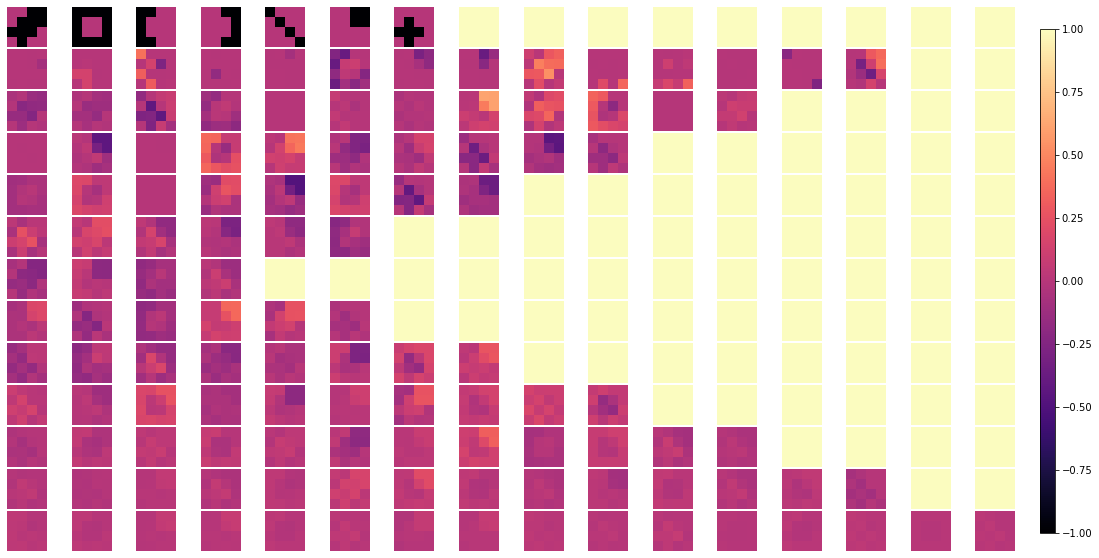

Epoch:  1 , Loss:  1.915709376335144 , Val Loss:  1.3801617622375488
Epoch:  50 , Loss:  0.27770349383354187 , Val Loss:  0.1959080547094345
Epoch:  100 , Loss:  0.2288656383752823 , Val Loss:  0.15238694846630096
Epoch:  150 , Loss:  0.20199225842952728 , Val Loss:  0.11014414578676224
Epoch:  200 , Loss:  0.18473175168037415 , Val Loss:  0.09315916150808334
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.001, 19, True, False, 'selu', 200, 150]
(208, 16)


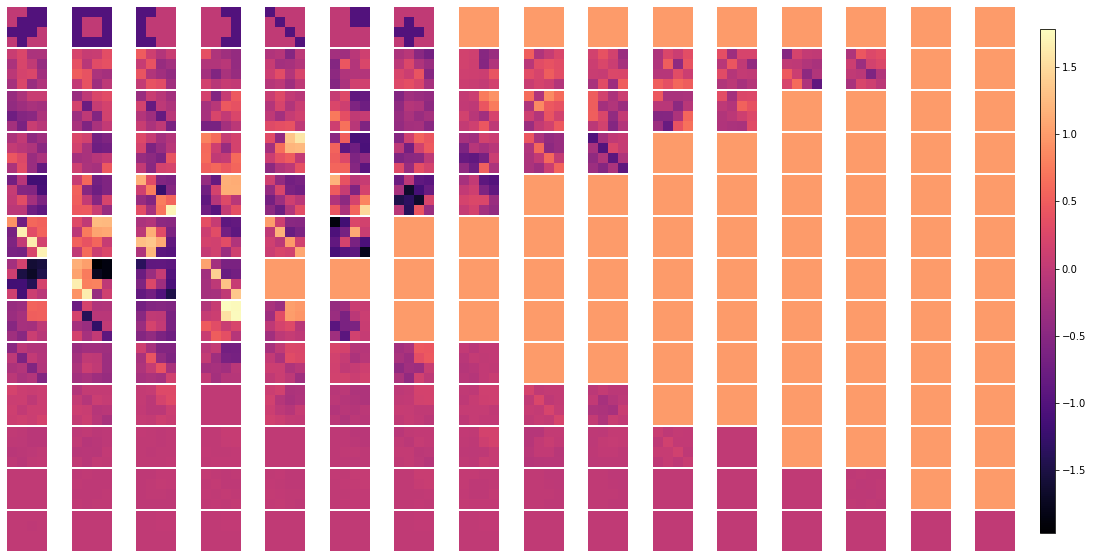

Epoch:  1 , Loss:  1.767926573753357 , Val Loss:  1.250011682510376
Epoch:  50 , Loss:  0.18935416638851166 , Val Loss:  0.10962618887424469
Epoch:  100 , Loss:  0.16422149538993835 , Val Loss:  0.07018514722585678
Epoch:  150 , Loss:  0.1526777148246765 , Val Loss:  0.05396315082907677
Epoch:  200 , Loss:  0.151791512966156 , Val Loss:  0.05634608119726181
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.001, 19, False, False, 'selu', 200, 150]
(208, 16)


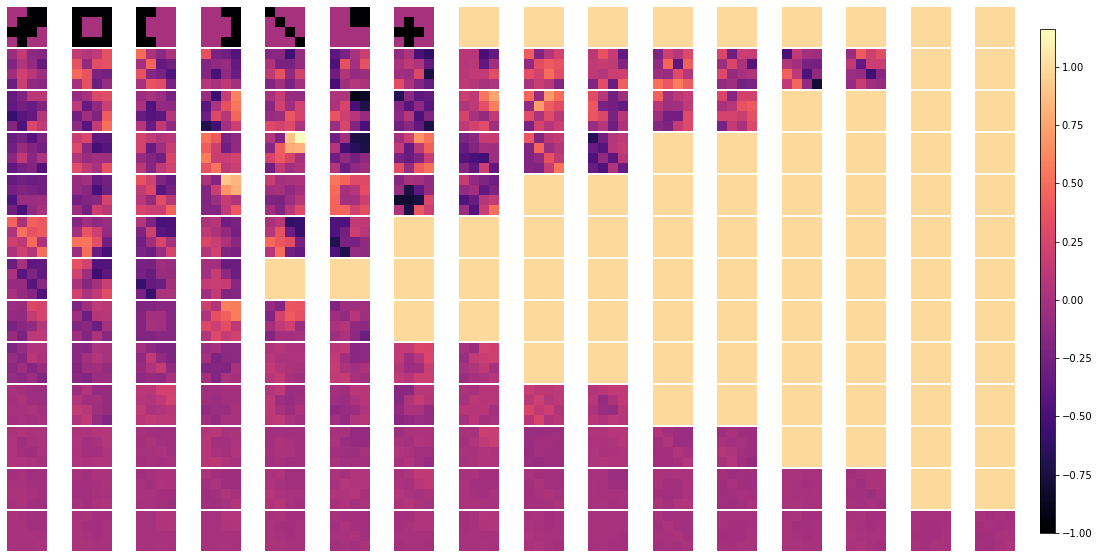

Epoch:  1 , Loss:  1.938410758972168 , Val Loss:  1.407415509223938
Epoch:  50 , Loss:  0.3160669505596161 , Val Loss:  0.2403469830751419
Epoch:  100 , Loss:  0.2754582464694977 , Val Loss:  0.1905650794506073
Epoch:  150 , Loss:  0.23853644728660583 , Val Loss:  0.14337114989757538
Epoch:  200 , Loss:  0.22222241759300232 , Val Loss:  0.1267162263393402
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.0005, 19, True, True, 'selu', 200, 150]
(208, 16)


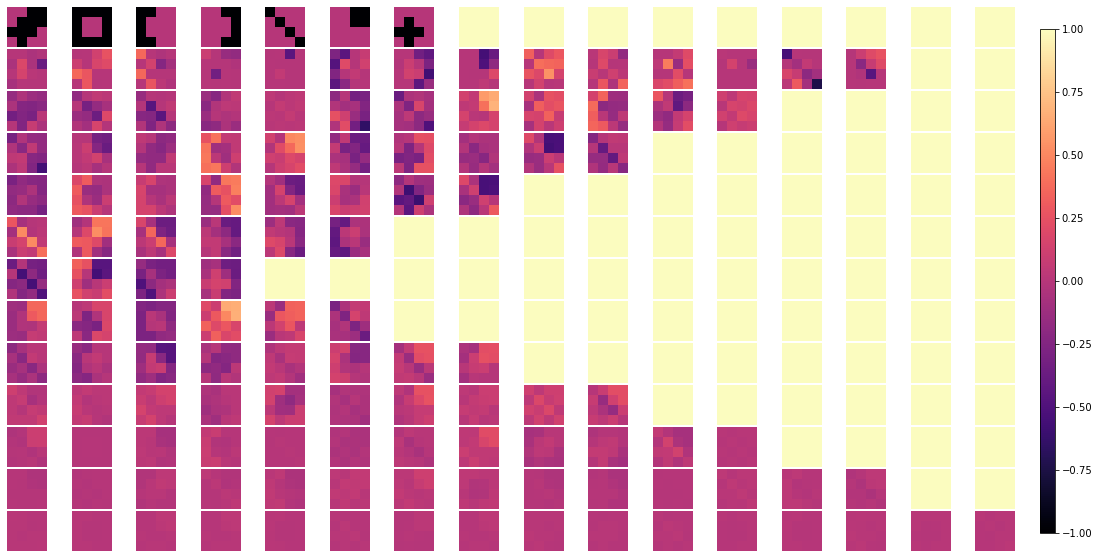

Epoch:  1 , Loss:  1.8515840768814087 , Val Loss:  1.3261610269546509
Epoch:  50 , Loss:  0.25583794713020325 , Val Loss:  0.17572017014026642
Epoch:  100 , Loss:  0.22558999061584473 , Val Loss:  0.14256076514720917
Epoch:  150 , Loss:  0.2000732421875 , Val Loss:  0.10500368475914001
Epoch:  200 , Loss:  0.19157934188842773 , Val Loss:  0.0935310497879982
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.0005, 19, False, True, 'selu', 200, 150]
(208, 16)


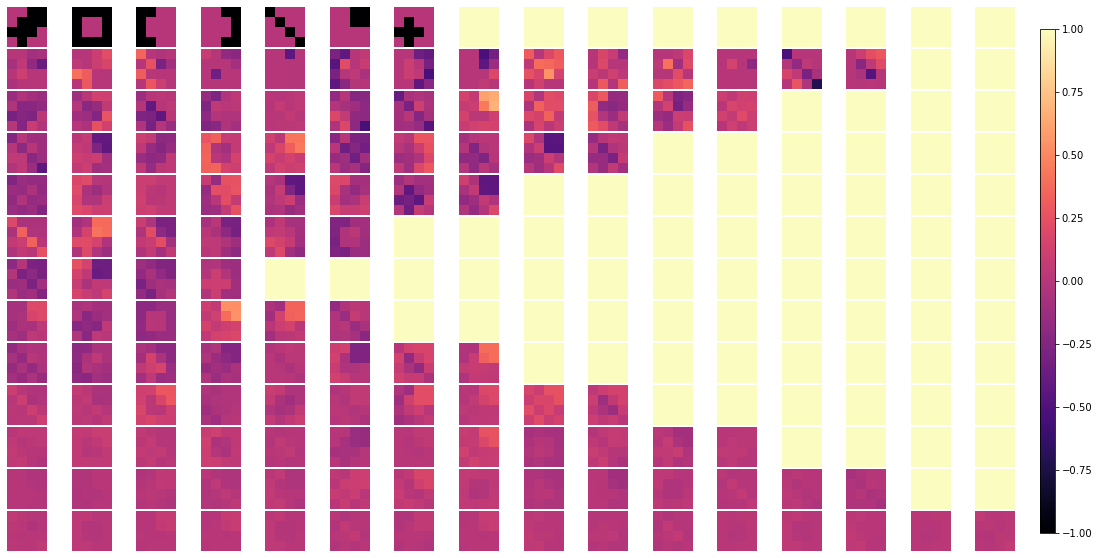

Epoch:  1 , Loss:  1.8310424089431763 , Val Loss:  1.318142294883728
Epoch:  50 , Loss:  0.24488739669322968 , Val Loss:  0.1627429574728012
Epoch:  100 , Loss:  0.1972505748271942 , Val Loss:  0.10659138858318329
Epoch:  150 , Loss:  0.18222136795520782 , Val Loss:  0.0893624946475029
Epoch:  200 , Loss:  0.17878520488739014 , Val Loss:  0.08469937741756439
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.0005, 19, True, False, 'selu', 200, 150]
(208, 16)


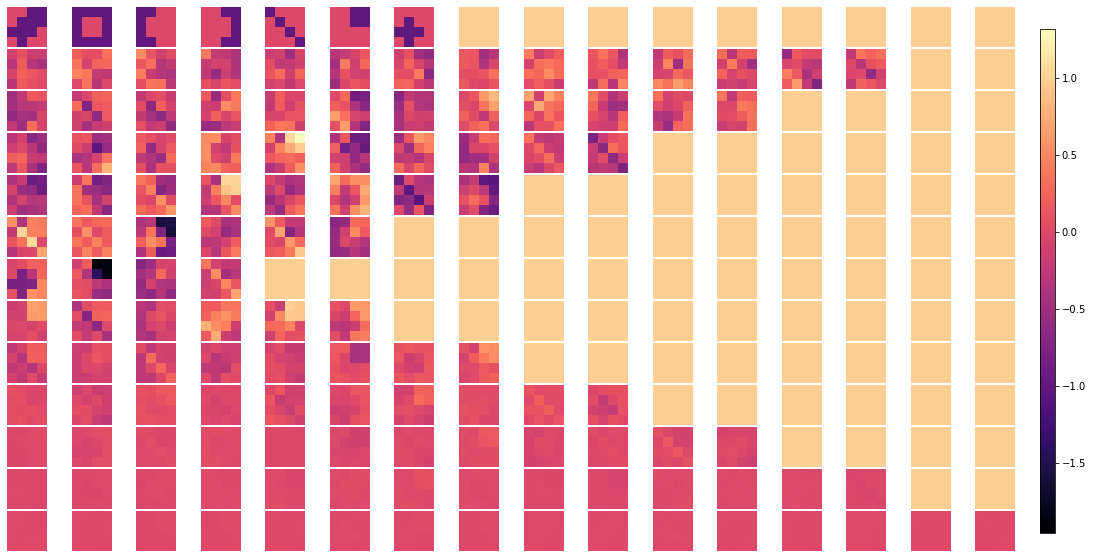

Epoch:  1 , Loss:  1.7589255571365356 , Val Loss:  1.2386542558670044
Epoch:  50 , Loss:  0.1868090033531189 , Val Loss:  0.10931797325611115
Epoch:  100 , Loss:  0.1690966933965683 , Val Loss:  0.0814955085515976
Epoch:  150 , Loss:  0.15557648241519928 , Val Loss:  0.057316023856401443
Epoch:  200 , Loss:  0.14864932000637054 , Val Loss:  0.05434024706482887
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 4)
(4, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 4, 6, 8, 10, 12, 14, 16], 0.0005, 19, False, False, 'selu', 200, 150]
(208, 16)


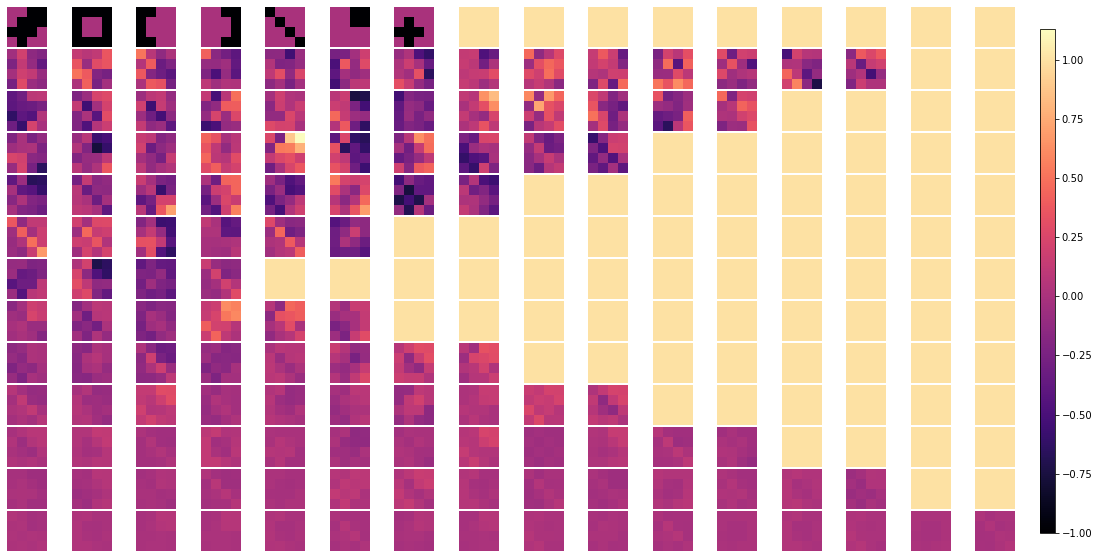

Epoch:  1 , Loss:  2.2558436393737793 , Val Loss:  1.4260404109954834
Epoch:  50 , Loss:  0.26231878995895386 , Val Loss:  0.18916597962379456
Epoch:  100 , Loss:  0.23329490423202515 , Val Loss:  0.15280328691005707
Epoch:  150 , Loss:  0.21726880967617035 , Val Loss:  0.1412404179573059
Epoch:  200 , Loss:  0.21258798241615295 , Val Loss:  0.13744278252124786
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.001, 19, True, True, 'selu', 200, 150]
(80, 16)


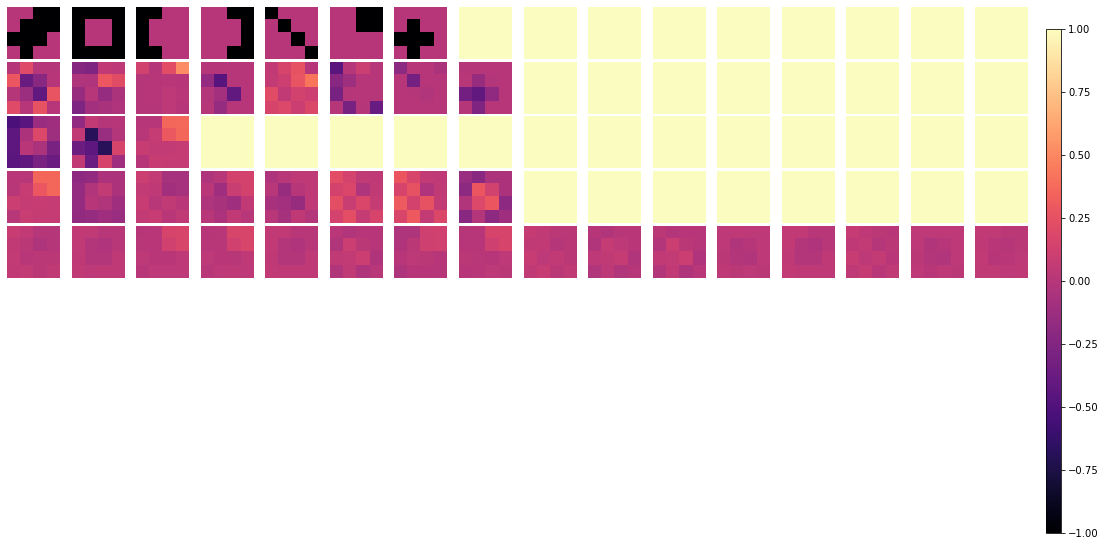

Epoch:  1 , Loss:  2.253477096557617 , Val Loss:  1.3940197229385376
Epoch:  50 , Loss:  0.24282731115818024 , Val Loss:  0.16419318318367004
Epoch:  100 , Loss:  0.2098923772573471 , Val Loss:  0.133560448884964
Epoch:  150 , Loss:  0.19841495156288147 , Val Loss:  0.12259078025817871
Epoch:  200 , Loss:  0.194096177816391 , Val Loss:  0.1178806945681572
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.001, 19, False, True, 'selu', 200, 150]
(80, 16)


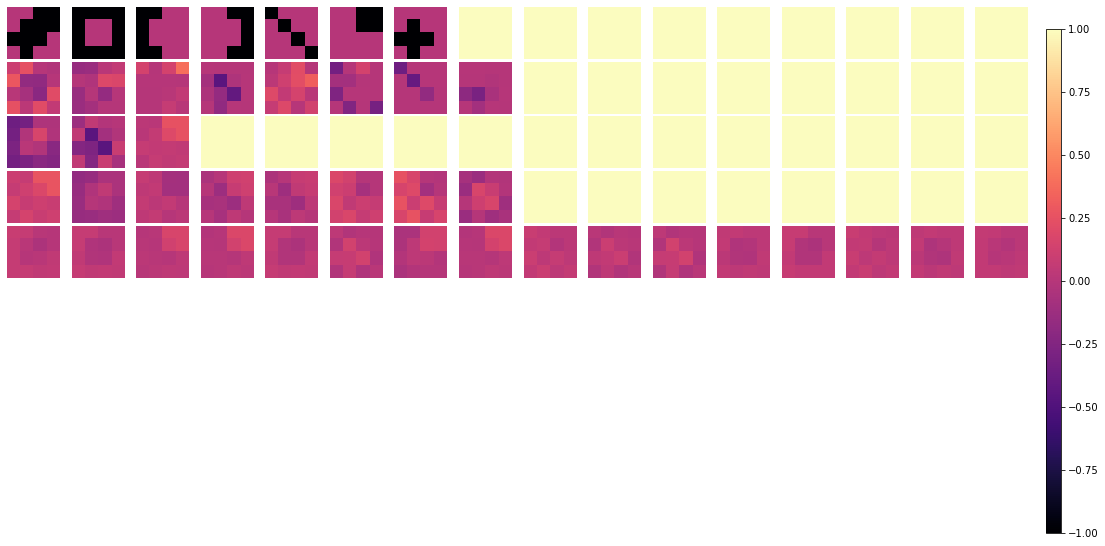

Epoch:  1 , Loss:  2.227778911590576 , Val Loss:  1.3847432136535645
Epoch:  50 , Loss:  0.22953173518180847 , Val Loss:  0.15085840225219727
Epoch:  100 , Loss:  0.19862987101078033 , Val Loss:  0.12073644250631332
Epoch:  150 , Loss:  0.18990971148014069 , Val Loss:  0.11530668288469315
Epoch:  200 , Loss:  0.18504272401332855 , Val Loss:  0.1100463792681694
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.001, 19, True, False, 'selu', 200, 150]
(80, 16)


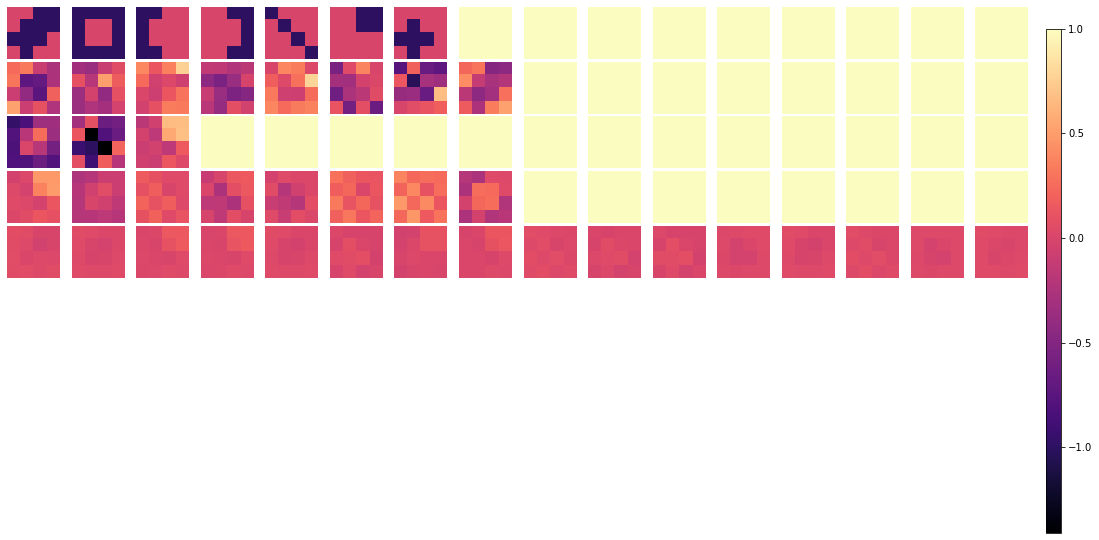

Epoch:  1 , Loss:  2.174426317214966 , Val Loss:  1.347946286201477
Epoch:  50 , Loss:  0.20575319230556488 , Val Loss:  0.12808488309383392
Epoch:  100 , Loss:  0.1819930374622345 , Val Loss:  0.10323628783226013
Epoch:  150 , Loss:  0.17997156083583832 , Val Loss:  0.10076843202114105
Epoch:  200 , Loss:  0.17492204904556274 , Val Loss:  0.09718607366085052
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.001, 19, False, False, 'selu', 200, 150]
(80, 16)


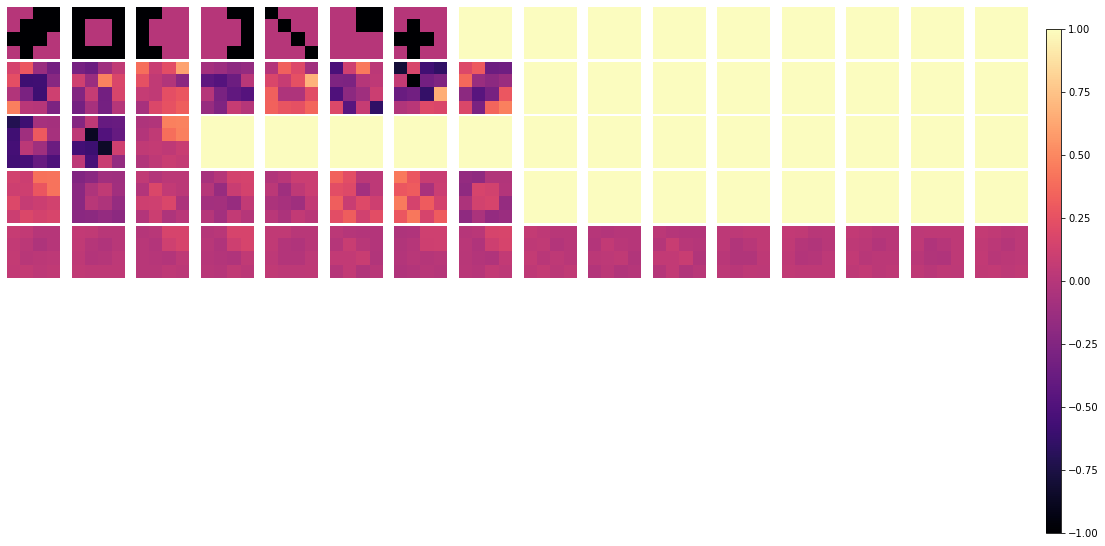

Epoch:  1 , Loss:  2.220174551010132 , Val Loss:  1.3878041505813599
Epoch:  50 , Loss:  0.23885594308376312 , Val Loss:  0.16031117737293243
Epoch:  100 , Loss:  0.20844557881355286 , Val Loss:  0.13368931412696838
Epoch:  150 , Loss:  0.20147959887981415 , Val Loss:  0.12517783045768738
Epoch:  200 , Loss:  0.19946768879890442 , Val Loss:  0.12180857360363007
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.0005, 19, True, True, 'selu', 200, 150]
(80, 16)


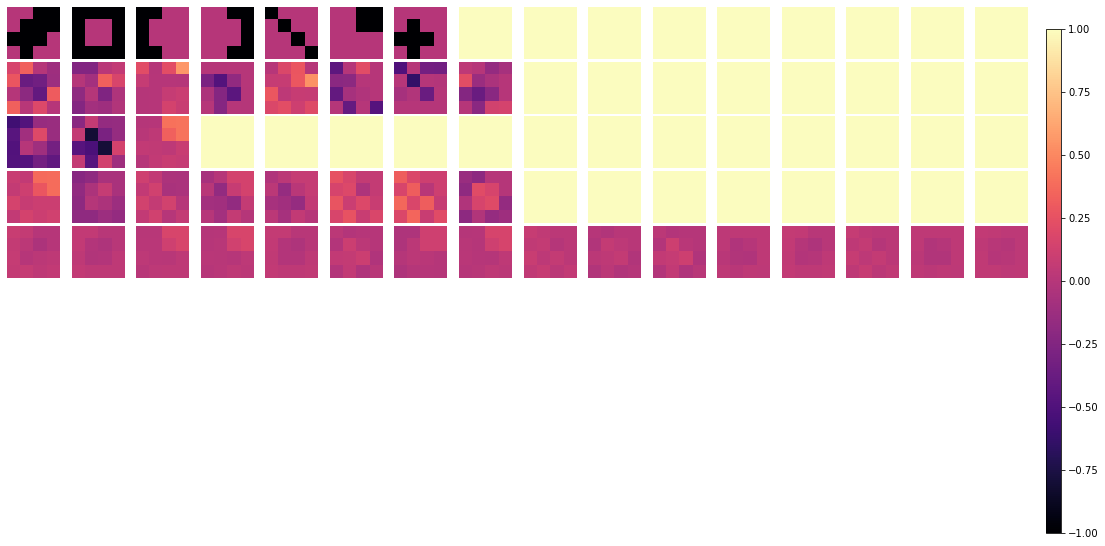

Epoch:  1 , Loss:  2.215947151184082 , Val Loss:  1.3670949935913086
Epoch:  50 , Loss:  0.22757290303707123 , Val Loss:  0.14532510936260223
Epoch:  100 , Loss:  0.19830535352230072 , Val Loss:  0.11850874125957489
Epoch:  150 , Loss:  0.19347773492336273 , Val Loss:  0.11391624808311462
Epoch:  200 , Loss:  0.1874750554561615 , Val Loss:  0.11173414438962936
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.0005, 19, False, True, 'selu', 200, 150]
(80, 16)


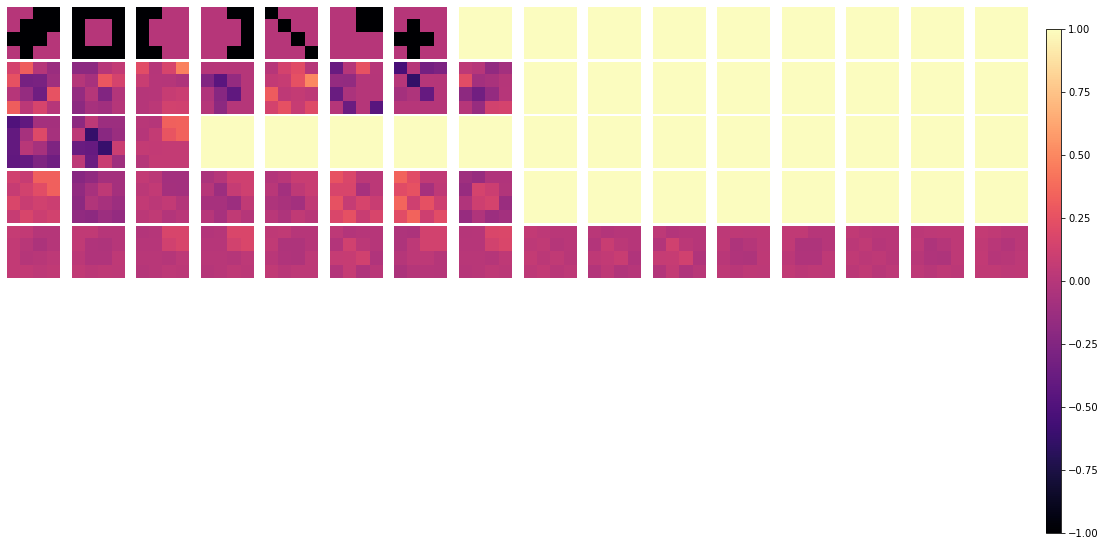

Epoch:  1 , Loss:  2.2260265350341797 , Val Loss:  1.3685466051101685
Epoch:  50 , Loss:  0.2192537635564804 , Val Loss:  0.14074836671352386
Epoch:  100 , Loss:  0.19189511239528656 , Val Loss:  0.11271875351667404
Epoch:  150 , Loss:  0.18199017643928528 , Val Loss:  0.10975933074951172
Epoch:  200 , Loss:  0.18376263976097107 , Val Loss:  0.107137531042099
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.0005, 19, True, False, 'selu', 200, 150]
(80, 16)


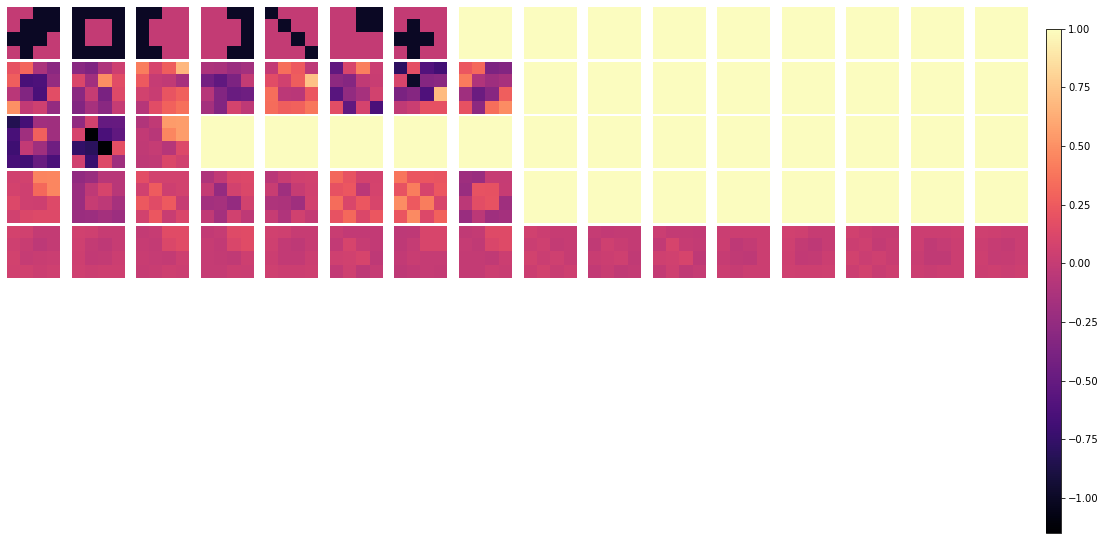

Epoch:  1 , Loss:  2.2127771377563477 , Val Loss:  1.3519210815429688
Epoch:  50 , Loss:  0.20681972801685333 , Val Loss:  0.12721595168113708
Epoch:  100 , Loss:  0.18046532571315765 , Val Loss:  0.10449162125587463
Epoch:  150 , Loss:  0.17970137298107147 , Val Loss:  0.09951937943696976
Epoch:  200 , Loss:  0.175612211227417 , Val Loss:  0.09886108338832855
(16, 8)
(8, 3)
(3, 8)
(8, 16)

[[16, 8, 3, 8, 16], 0.0005, 19, False, False, 'selu', 200, 150]
(80, 16)


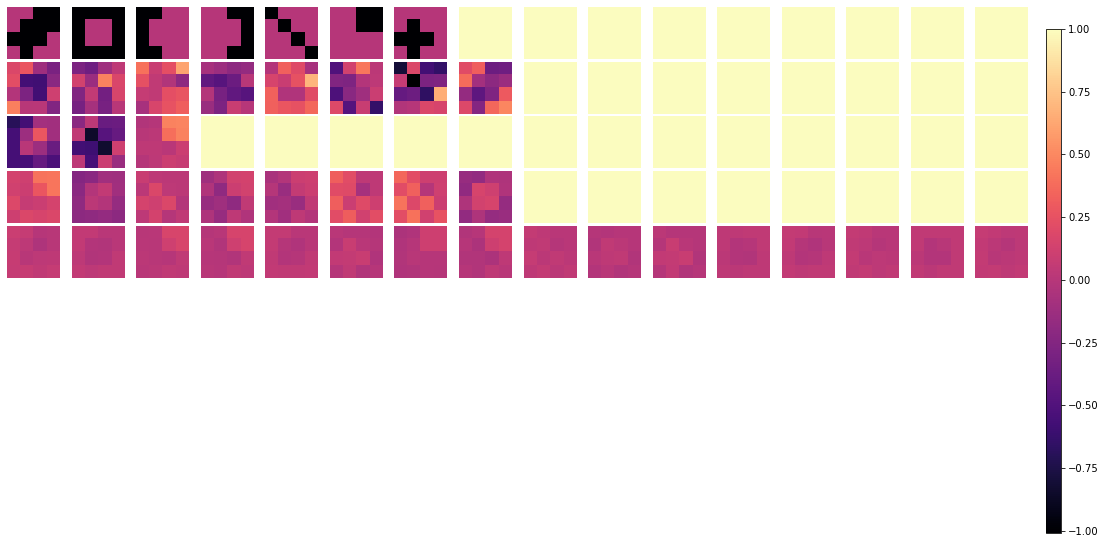

Epoch:  1 , Loss:  2.21353816986084 , Val Loss:  1.5580729246139526
Epoch:  50 , Loss:  0.28740012645721436 , Val Loss:  0.19803665578365326
Epoch:  100 , Loss:  0.24883295595645905 , Val Loss:  0.16122104227542877
Epoch:  150 , Loss:  0.22639961540699005 , Val Loss:  0.13813276588916779
Epoch:  200 , Loss:  0.21117806434631348 , Val Loss:  0.12479834258556366
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.001, 19, True, True, 'selu', 200, 150]
(112, 16)


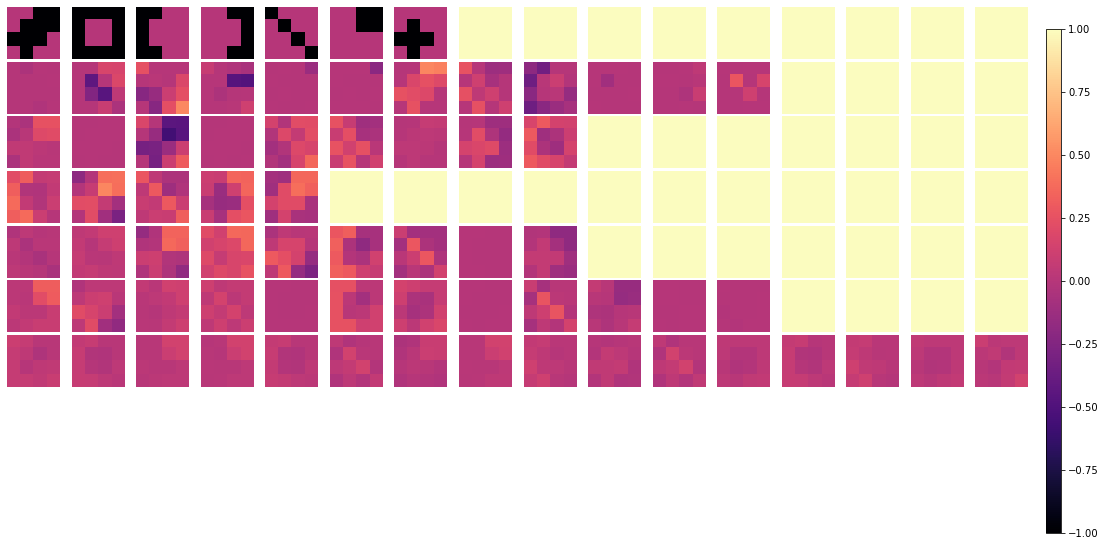

Epoch:  1 , Loss:  2.1433370113372803 , Val Loss:  1.4669636487960815
Epoch:  50 , Loss:  0.23401892185211182 , Val Loss:  0.140847310423851
Epoch:  100 , Loss:  0.20372366905212402 , Val Loss:  0.11206001788377762
Epoch:  150 , Loss:  0.18670974671840668 , Val Loss:  0.0934700220823288
Epoch:  200 , Loss:  0.176246777176857 , Val Loss:  0.07758602499961853
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.001, 19, False, True, 'selu', 200, 150]
(112, 16)


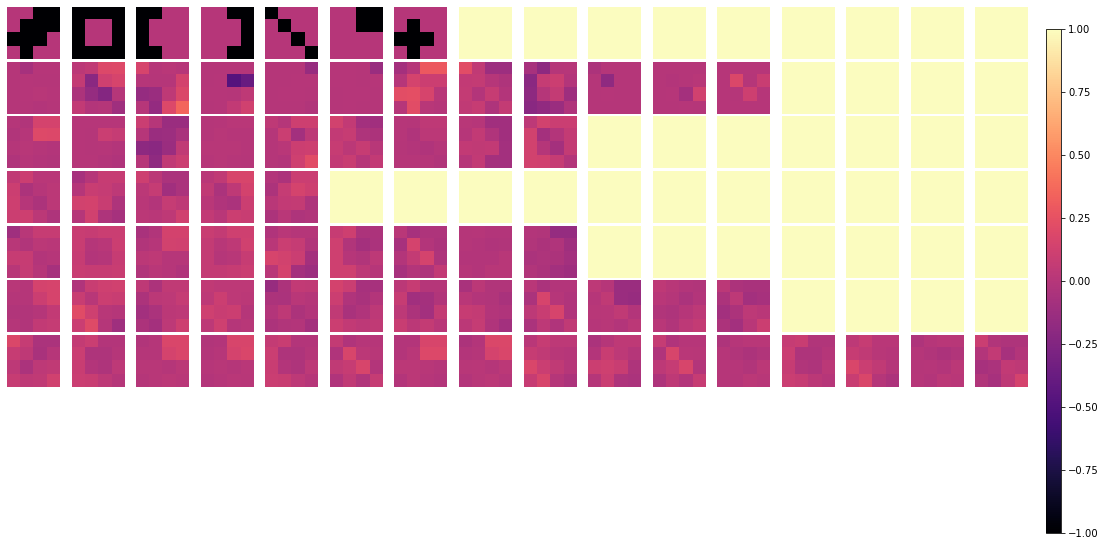

Epoch:  1 , Loss:  2.135169744491577 , Val Loss:  1.4716321229934692
Epoch:  50 , Loss:  0.2197967767715454 , Val Loss:  0.129316046833992
Epoch:  100 , Loss:  0.19358885288238525 , Val Loss:  0.10637762397527695
Epoch:  150 , Loss:  0.18302389979362488 , Val Loss:  0.09481360763311386
Epoch:  200 , Loss:  0.17257007956504822 , Val Loss:  0.08359004557132721
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.001, 19, True, False, 'selu', 200, 150]
(112, 16)


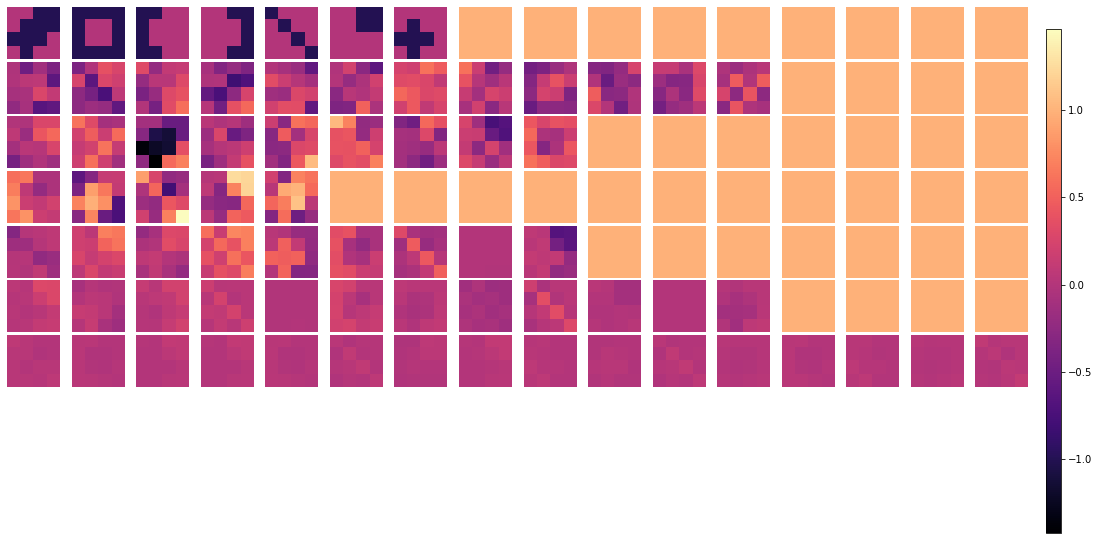

Epoch:  1 , Loss:  2.051632881164551 , Val Loss:  1.3982783555984497
Epoch:  50 , Loss:  0.16655948758125305 , Val Loss:  0.0733213722705841
Epoch:  100 , Loss:  0.161752387881279 , Val Loss:  0.06554459780454636
Epoch:  150 , Loss:  0.1496805101633072 , Val Loss:  0.05384562164545059
Epoch:  200 , Loss:  0.15135808289051056 , Val Loss:  0.048557598143815994
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.001, 19, False, False, 'selu', 200, 150]
(112, 16)


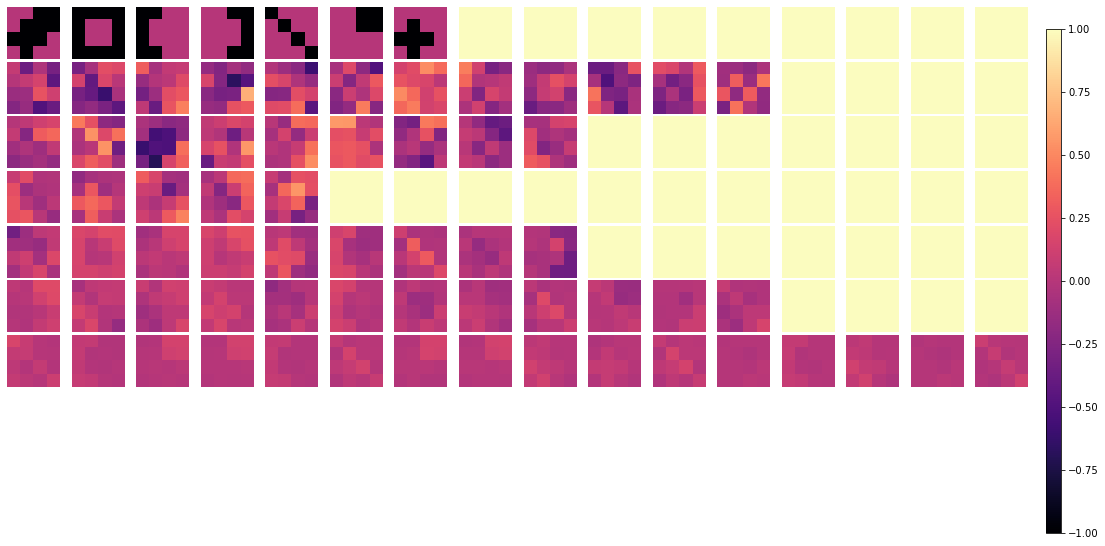

Epoch:  1 , Loss:  2.1382198333740234 , Val Loss:  1.4763437509536743
Epoch:  50 , Loss:  0.23618830740451813 , Val Loss:  0.14394038915634155
Epoch:  100 , Loss:  0.21525675058364868 , Val Loss:  0.1260945200920105
Epoch:  150 , Loss:  0.19994503259658813 , Val Loss:  0.11259382218122482
Epoch:  200 , Loss:  0.18608412146568298 , Val Loss:  0.09409521520137787
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, True, True, 'selu', 200, 150]
(112, 16)


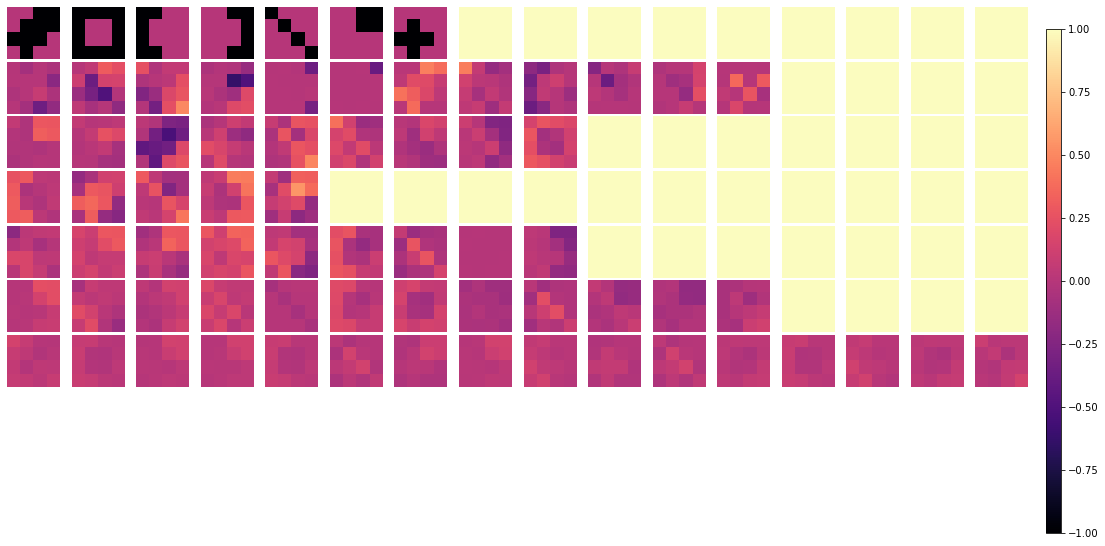

Epoch:  1 , Loss:  2.08617901802063 , Val Loss:  1.4207708835601807
Epoch:  50 , Loss:  0.20577900111675262 , Val Loss:  0.10939615964889526
Epoch:  100 , Loss:  0.18681147694587708 , Val Loss:  0.09857316315174103
Epoch:  150 , Loss:  0.17766501009464264 , Val Loss:  0.07426377385854721
Epoch:  200 , Loss:  0.1673383265733719 , Val Loss:  0.06492990255355835
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, False, True, 'selu', 200, 150]
(112, 16)


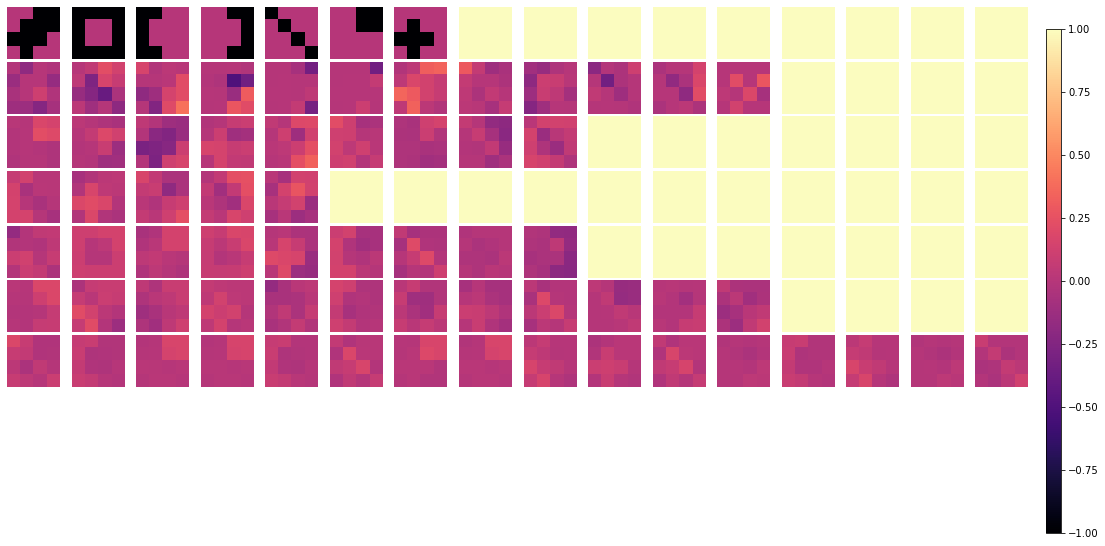

Epoch:  1 , Loss:  2.098536729812622 , Val Loss:  1.419523000717163
Epoch:  50 , Loss:  0.20032408833503723 , Val Loss:  0.10664468258619308
Epoch:  100 , Loss:  0.1834055483341217 , Val Loss:  0.09156162291765213
Epoch:  150 , Loss:  0.17374588549137115 , Val Loss:  0.07676617056131363
Epoch:  200 , Loss:  0.1655913144350052 , Val Loss:  0.06788507103919983
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, True, False, 'selu', 200, 150]
(112, 16)


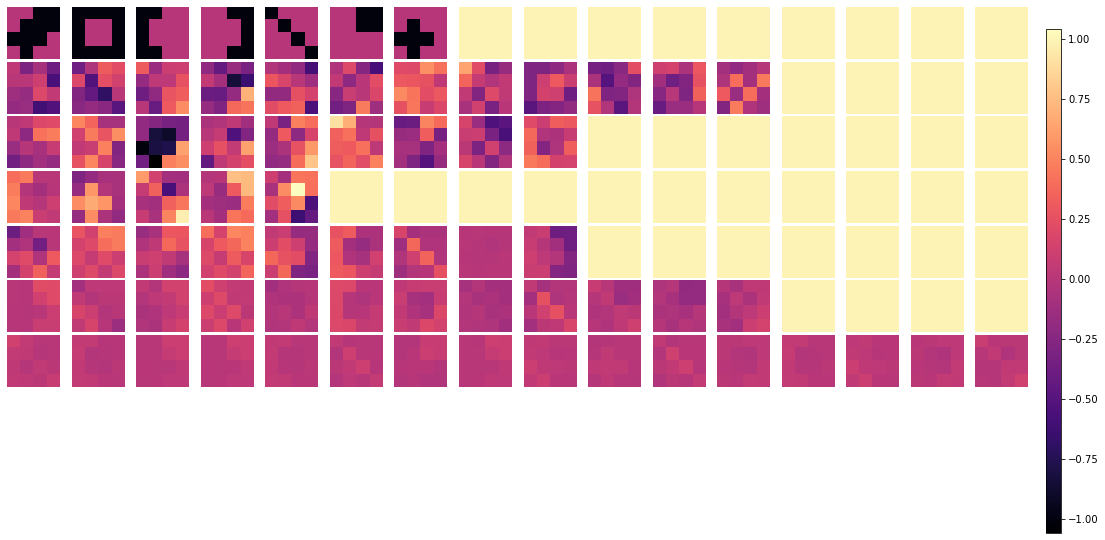

Epoch:  1 , Loss:  2.033480167388916 , Val Loss:  1.3796719312667847
Epoch:  50 , Loss:  0.1701051890850067 , Val Loss:  0.0720260739326477
Epoch:  100 , Loss:  0.15959002077579498 , Val Loss:  0.06512298434972763
Epoch:  150 , Loss:  0.1521061360836029 , Val Loss:  0.05461758002638817
Epoch:  200 , Loss:  0.14790663123130798 , Val Loss:  0.047729432582855225
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, False, False, 'selu', 200, 150]
(112, 16)


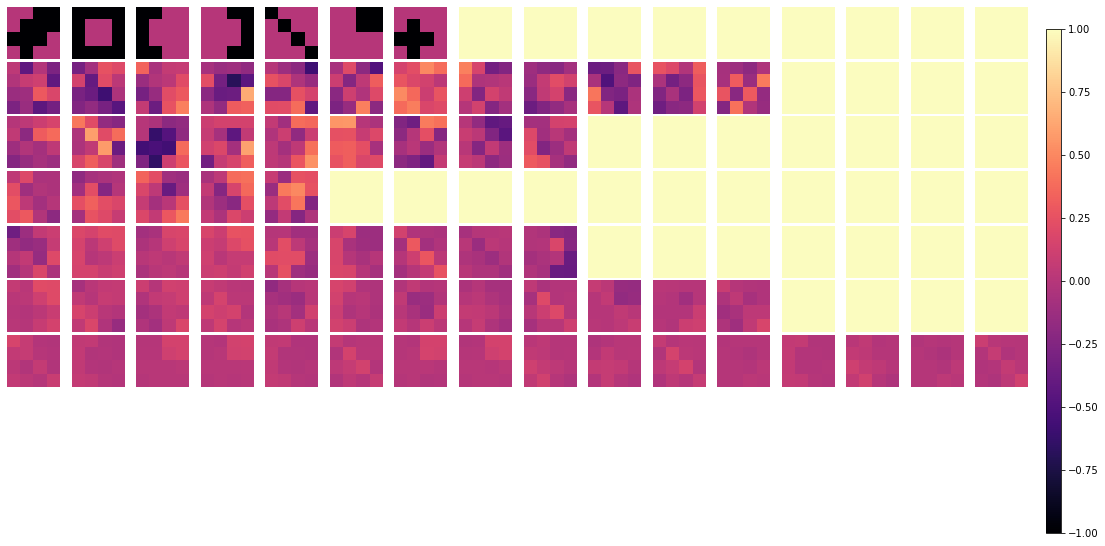

In [78]:
### Model Selection...kinda :)
arches = [[16,14,12,10,8,6,4,6,8,10,12,14,16], [16, 8, 3, 8, 16], [16, 12, 9, 5, 9, 12, 16]]
rrs = [0.001, 0.0005]
encoder_regs = [True, False]
decoder_regs = [True, False]

for arch in arches:
    for rr in rrs:
        for decoder_reg in decoder_regs:
            for encoder_reg in encoder_regs:
                encoder_ae, decoder_ae, hparams = run_autoencoder(noise=True, arch=arch, 
                                                                  decoder_reg=decoder_reg, 
                                                                  encoder_reg=encoder_reg, 
                                                                  rr=rr, seed=19, activ='selu')
                weights_ae = get_ae_weights(encoder_ae, decoder_ae)
                print(hparams)
                show_ae(weights_ae)

Epoch:  1 , Loss:  2.839505434036255 , Val Loss:  2.2390549182891846
Epoch:  50 , Loss:  0.546129047870636 , Val Loss:  0.4921986758708954
Epoch:  100 , Loss:  0.36264416575431824 , Val Loss:  0.3048207461833954
Epoch:  150 , Loss:  0.32776588201522827 , Val Loss:  0.2690708339214325
Epoch:  200 , Loss:  0.3179701566696167 , Val Loss:  0.25984326004981995
Epoch:  250 , Loss:  0.31081274151802063 , Val Loss:  0.2532312870025635
Epoch:  300 , Loss:  0.3058741092681885 , Val Loss:  0.24953991174697876
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.004, 19, True, True, 'selu', 300, 150]
(176, 16)


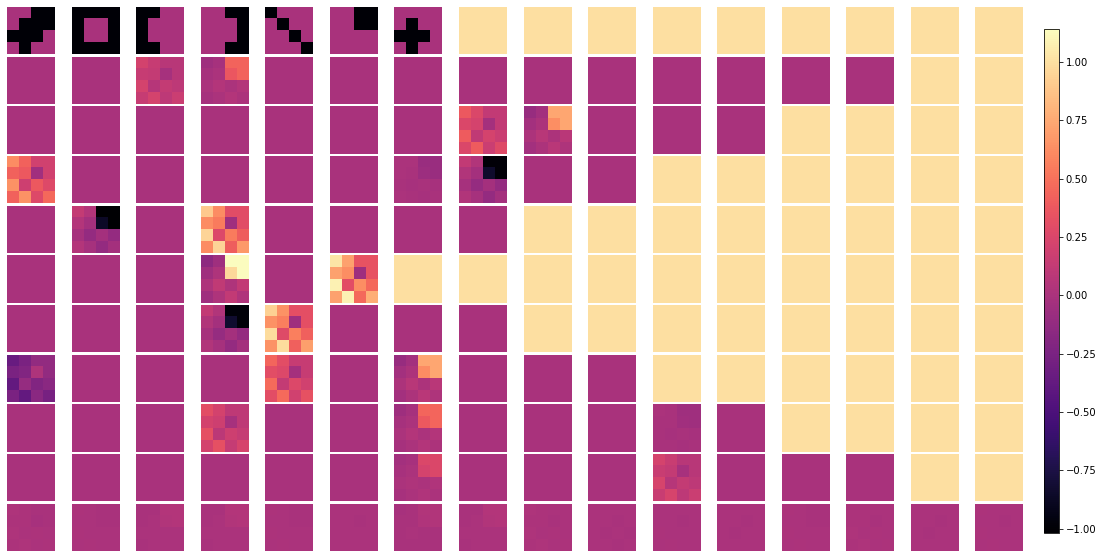

Epoch:  1 , Loss:  2.2091457843780518 , Val Loss:  1.6154299974441528
Epoch:  50 , Loss:  0.37930360436439514 , Val Loss:  0.31877589225769043
Epoch:  100 , Loss:  0.2685745358467102 , Val Loss:  0.21101798117160797
Epoch:  150 , Loss:  0.2516006529331207 , Val Loss:  0.1921107918024063
Epoch:  200 , Loss:  0.24400632083415985 , Val Loss:  0.1854129582643509
Epoch:  250 , Loss:  0.23999150097370148 , Val Loss:  0.18546178936958313
Epoch:  300 , Loss:  0.23667334020137787 , Val Loss:  0.17466412484645844
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.004, 19, False, True, 'selu', 300, 150]
(176, 16)


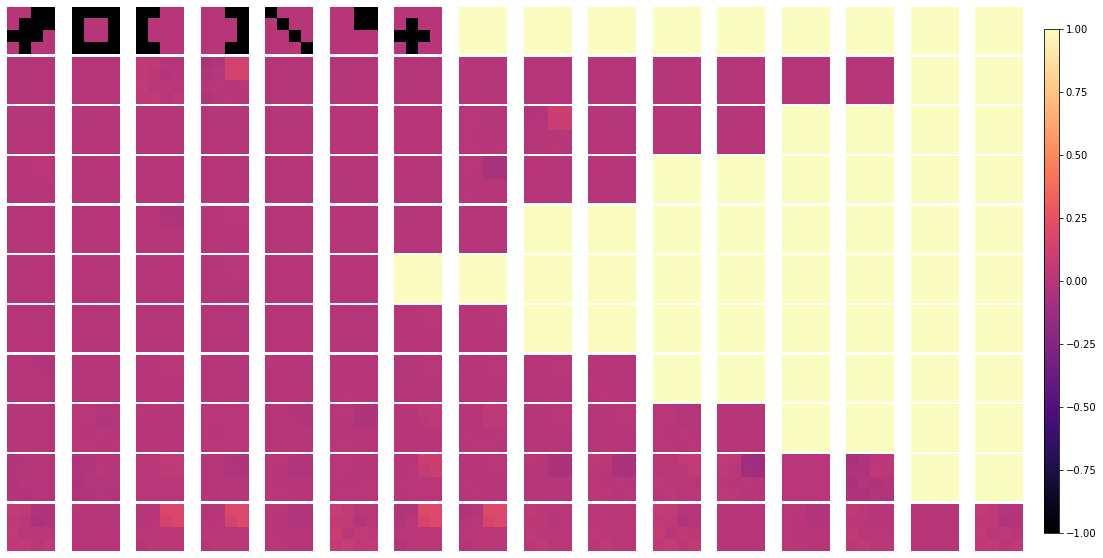

Epoch:  1 , Loss:  2.202376127243042 , Val Loss:  1.6097607612609863
Epoch:  50 , Loss:  0.2983761131763458 , Val Loss:  0.22734566032886505
Epoch:  100 , Loss:  0.23274138569831848 , Val Loss:  0.15716171264648438
Epoch:  150 , Loss:  0.2129516452550888 , Val Loss:  0.13467973470687866
Epoch:  200 , Loss:  0.20240579545497894 , Val Loss:  0.12567973136901855
Epoch:  250 , Loss:  0.19880668818950653 , Val Loss:  0.12178682535886765
Epoch:  300 , Loss:  0.19887752830982208 , Val Loss:  0.12485465407371521
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.004, 19, True, False, 'selu', 300, 150]
(176, 16)


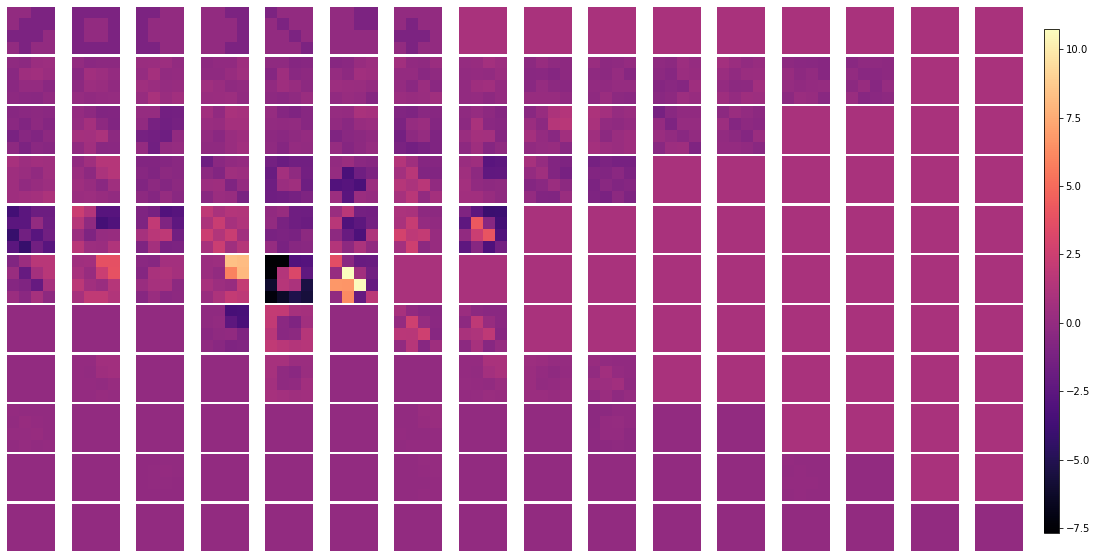

Epoch:  1 , Loss:  1.5661225318908691 , Val Loss:  0.9743146896362305
Epoch:  50 , Loss:  0.17173947393894196 , Val Loss:  0.08171970397233963
Epoch:  100 , Loss:  0.15273569524288177 , Val Loss:  0.056348979473114014
Epoch:  150 , Loss:  0.1488121896982193 , Val Loss:  0.04076632484793663
Epoch:  200 , Loss:  0.14218463003635406 , Val Loss:  0.03659499064087868
Epoch:  250 , Loss:  0.14184784889221191 , Val Loss:  0.03625022619962692
Epoch:  300 , Loss:  0.14369513094425201 , Val Loss:  0.03309137374162674
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.004, 19, False, False, 'selu', 300, 150]
(176, 16)


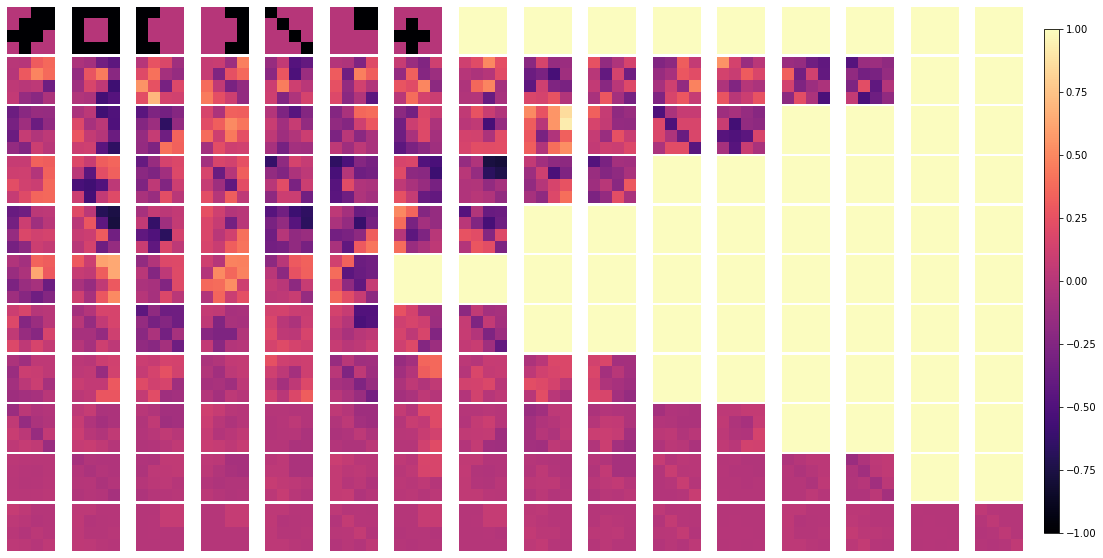

Epoch:  1 , Loss:  2.193859577178955 , Val Loss:  1.600633978843689
Epoch:  50 , Loss:  0.4649556279182434 , Val Loss:  0.39328378438949585
Epoch:  100 , Loss:  0.3457268178462982 , Val Loss:  0.26867833733558655
Epoch:  150 , Loss:  0.2909804880619049 , Val Loss:  0.21632464230060577
Epoch:  200 , Loss:  0.27334293723106384 , Val Loss:  0.19513674080371857
Epoch:  250 , Loss:  0.25547951459884644 , Val Loss:  0.17779512703418732
Epoch:  300 , Loss:  0.24540996551513672 , Val Loss:  0.16701053082942963
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.002, 19, True, True, 'selu', 300, 150]
(176, 16)


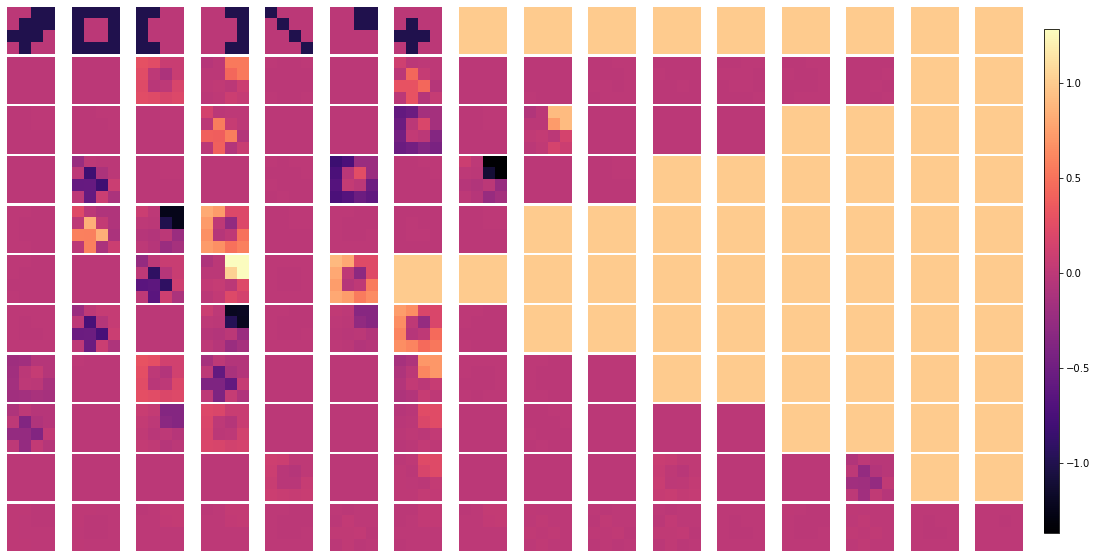

Epoch:  1 , Loss:  1.8829841613769531 , Val Loss:  1.285618543624878
Epoch:  50 , Loss:  0.3590344190597534 , Val Loss:  0.29858851432800293
Epoch:  100 , Loss:  0.2507484555244446 , Val Loss:  0.17411240935325623
Epoch:  150 , Loss:  0.21915997564792633 , Val Loss:  0.14103655517101288
Epoch:  200 , Loss:  0.21302556991577148 , Val Loss:  0.13031432032585144
Epoch:  250 , Loss:  0.20263534784317017 , Val Loss:  0.12399476766586304
Epoch:  300 , Loss:  0.202220156788826 , Val Loss:  0.1216481551527977
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.002, 19, False, True, 'selu', 300, 150]
(176, 16)


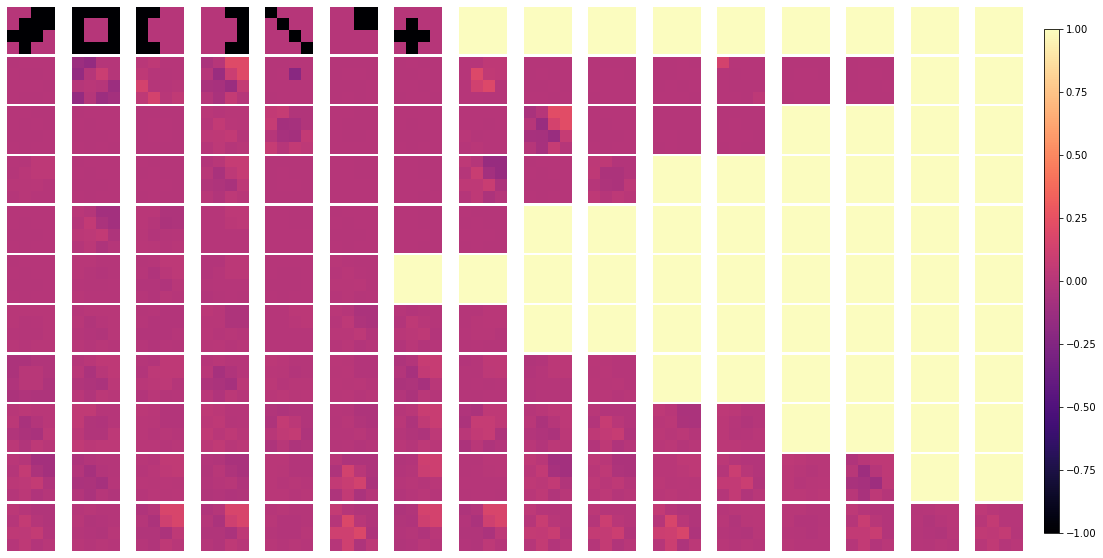

Epoch:  1 , Loss:  1.8765023946762085 , Val Loss:  1.288140892982483
Epoch:  50 , Loss:  0.2816515862941742 , Val Loss:  0.1834736466407776
Epoch:  100 , Loss:  0.21967945992946625 , Val Loss:  0.13510194420814514
Epoch:  150 , Loss:  0.20264886319637299 , Val Loss:  0.11010536551475525
Epoch:  200 , Loss:  0.19059625267982483 , Val Loss:  0.10226167738437653
Epoch:  250 , Loss:  0.18543797731399536 , Val Loss:  0.10179032385349274
Epoch:  300 , Loss:  0.18340417742729187 , Val Loss:  0.08809449523687363
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.002, 19, True, False, 'selu', 300, 150]
(176, 16)


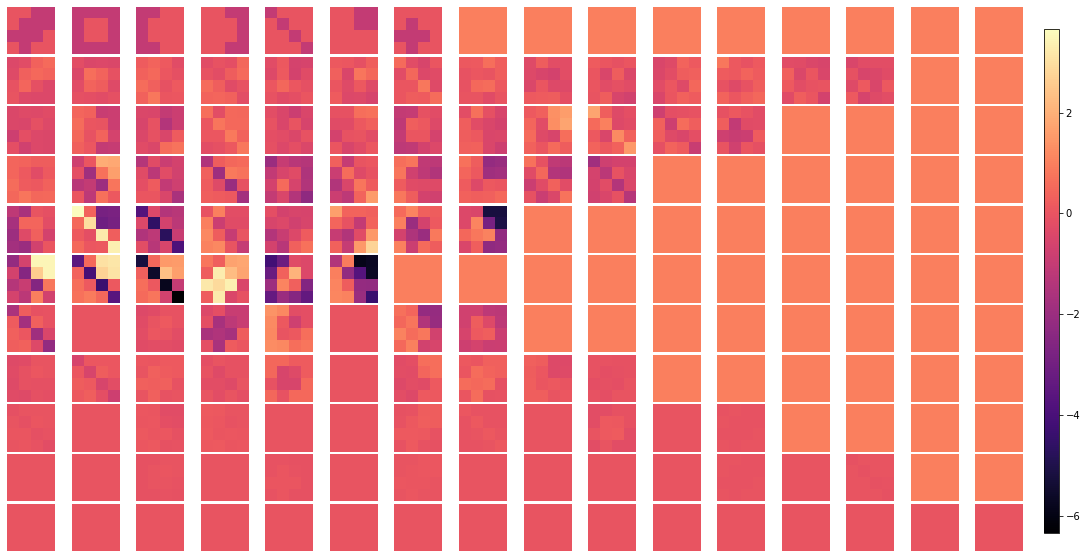

Epoch:  1 , Loss:  1.5569850206375122 , Val Loss:  0.9694897532463074
Epoch:  50 , Loss:  0.16328886151313782 , Val Loss:  0.06744489818811417
Epoch:  100 , Loss:  0.1491965353488922 , Val Loss:  0.04822421818971634
Epoch:  150 , Loss:  0.1461324840784073 , Val Loss:  0.03676360473036766
Epoch:  200 , Loss:  0.14335525035858154 , Val Loss:  0.03964250907301903
Epoch:  250 , Loss:  0.14071746170520782 , Val Loss:  0.032608892768621445
Epoch:  300 , Loss:  0.1398266702890396 , Val Loss:  0.028916552662849426
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.002, 19, False, False, 'selu', 300, 150]
(176, 16)


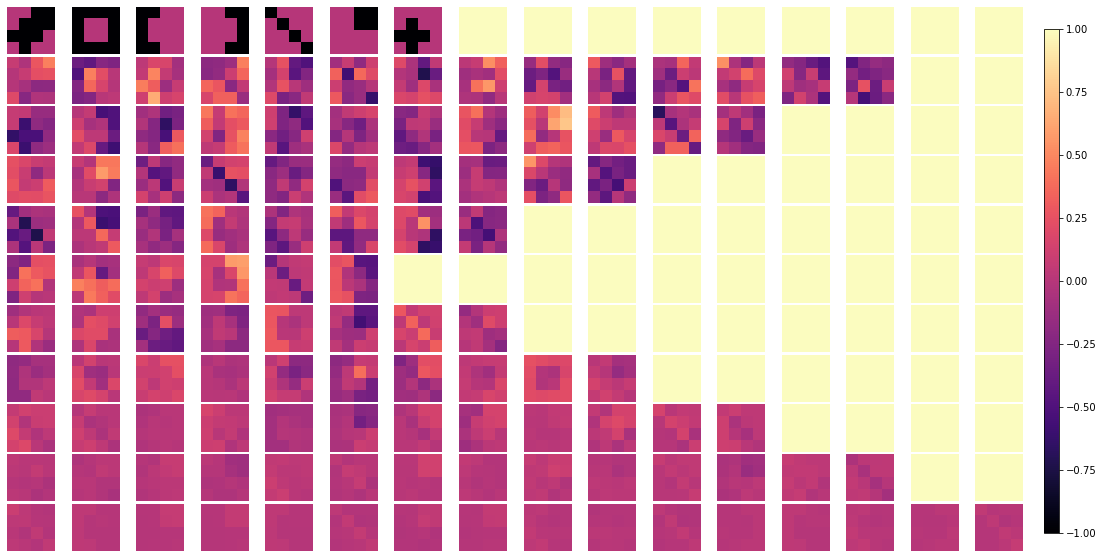

Epoch:  1 , Loss:  1.8469703197479248 , Val Loss:  1.2514011859893799
Epoch:  50 , Loss:  0.36049142479896545 , Val Loss:  0.2747957706451416
Epoch:  100 , Loss:  0.2901792824268341 , Val Loss:  0.19661332666873932
Epoch:  150 , Loss:  0.2554658055305481 , Val Loss:  0.16637367010116577
Epoch:  200 , Loss:  0.23729893565177917 , Val Loss:  0.14301611483097076
Epoch:  250 , Loss:  0.22468188405036926 , Val Loss:  0.13137231767177582
Epoch:  300 , Loss:  0.21745362877845764 , Val Loss:  0.12132944911718369
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0009, 19, True, True, 'selu', 300, 150]
(176, 16)


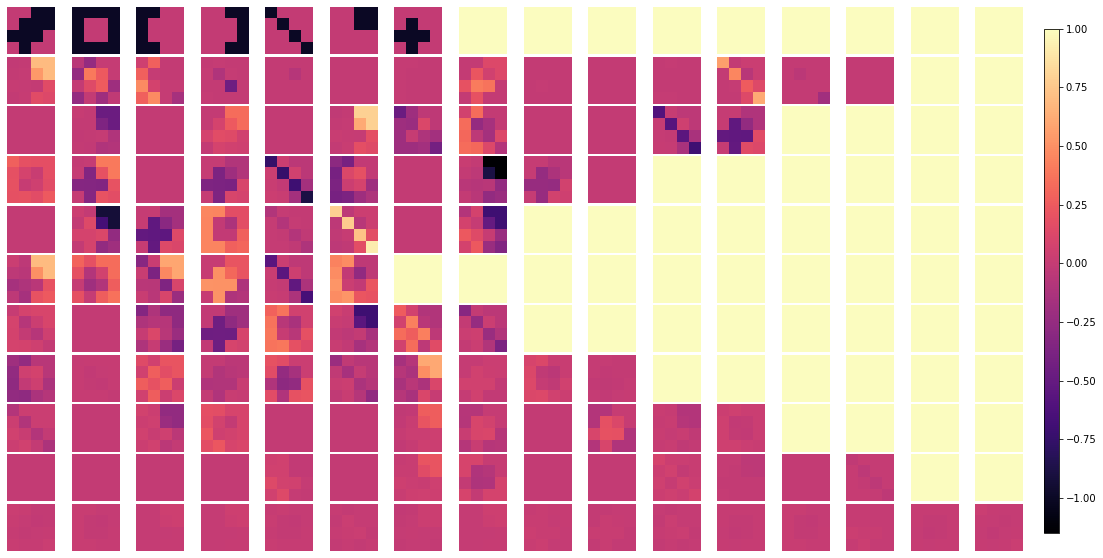

Epoch:  1 , Loss:  1.6924686431884766 , Val Loss:  1.09157133102417
Epoch:  50 , Loss:  0.2714572846889496 , Val Loss:  0.1844639629125595
Epoch:  100 , Loss:  0.2283230572938919 , Val Loss:  0.13025140762329102
Epoch:  150 , Loss:  0.20879150927066803 , Val Loss:  0.1105128675699234
Epoch:  200 , Loss:  0.19289404153823853 , Val Loss:  0.09421400725841522
Epoch:  250 , Loss:  0.18479762971401215 , Val Loss:  0.08404870331287384
Epoch:  300 , Loss:  0.17841501533985138 , Val Loss:  0.0706753358244896
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0009, 19, False, True, 'selu', 300, 150]
(176, 16)


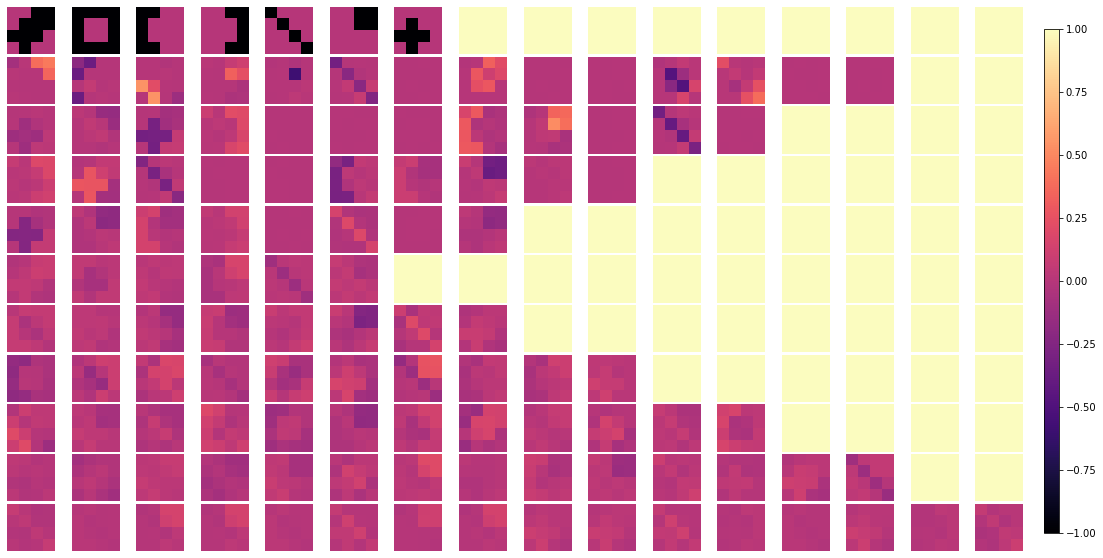

Epoch:  1 , Loss:  1.6937551498413086 , Val Loss:  1.1054526567459106
Epoch:  50 , Loss:  0.24357132613658905 , Val Loss:  0.15102353692054749
Epoch:  100 , Loss:  0.20953050255775452 , Val Loss:  0.1144523099064827
Epoch:  150 , Loss:  0.1905013769865036 , Val Loss:  0.09656179696321487
Epoch:  200 , Loss:  0.18040761351585388 , Val Loss:  0.08948911726474762
Epoch:  250 , Loss:  0.17372456192970276 , Val Loss:  0.07780591398477554
Epoch:  300 , Loss:  0.17012783885002136 , Val Loss:  0.0673050507903099
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0009, 19, True, False, 'selu', 300, 150]
(176, 16)


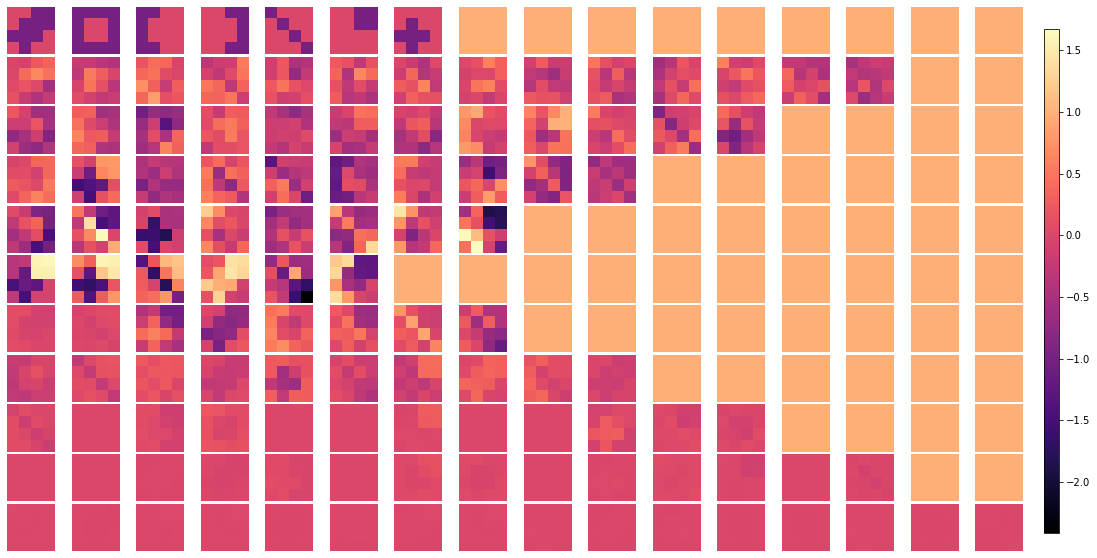

Epoch:  1 , Loss:  1.5671420097351074 , Val Loss:  0.9825697541236877
Epoch:  50 , Loss:  0.1654587835073471 , Val Loss:  0.06639771163463593
Epoch:  100 , Loss:  0.1517302244901657 , Val Loss:  0.05990459769964218
Epoch:  150 , Loss:  0.1457124948501587 , Val Loss:  0.03868630528450012
Epoch:  200 , Loss:  0.14444611966609955 , Val Loss:  0.03537940979003906
Epoch:  250 , Loss:  0.1436266303062439 , Val Loss:  0.032562173902988434
Epoch:  300 , Loss:  0.14339038729667664 , Val Loss:  0.03046264313161373
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0009, 19, False, False, 'selu', 300, 150]
(176, 16)


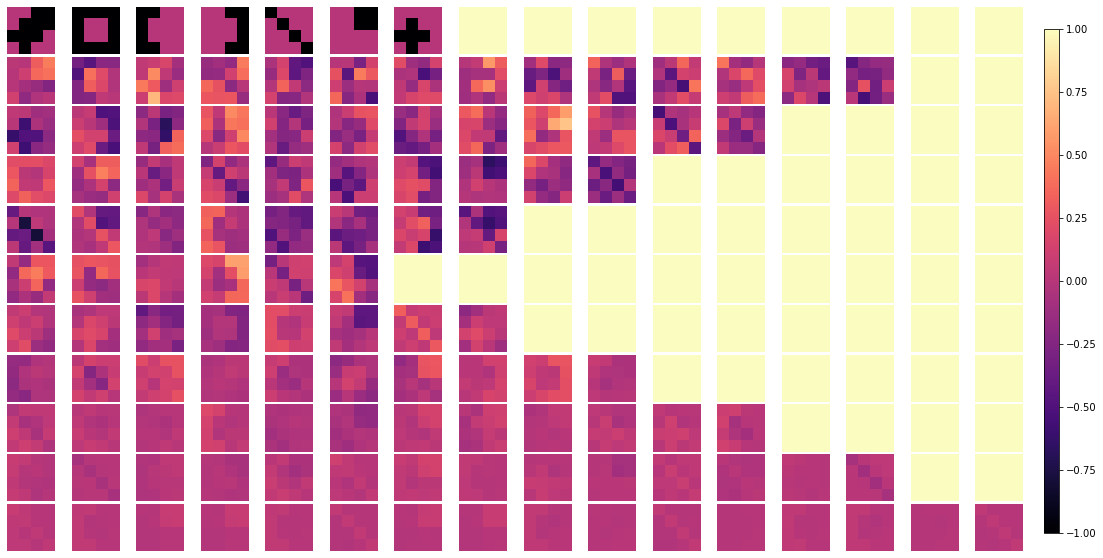

Epoch:  1 , Loss:  2.737231969833374 , Val Loss:  2.0701911449432373
Epoch:  50 , Loss:  0.4760122001171112 , Val Loss:  0.40870991349220276
Epoch:  100 , Loss:  0.358229398727417 , Val Loss:  0.29112574458122253
Epoch:  150 , Loss:  0.31700262427330017 , Val Loss:  0.24112188816070557
Epoch:  200 , Loss:  0.29839906096458435 , Val Loss:  0.22018349170684814
Epoch:  250 , Loss:  0.2867441177368164 , Val Loss:  0.20204217731952667
Epoch:  300 , Loss:  0.28552353382110596 , Val Loss:  0.19636529684066772
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.004, 19, True, True, 'selu', 300, 150]
(112, 16)


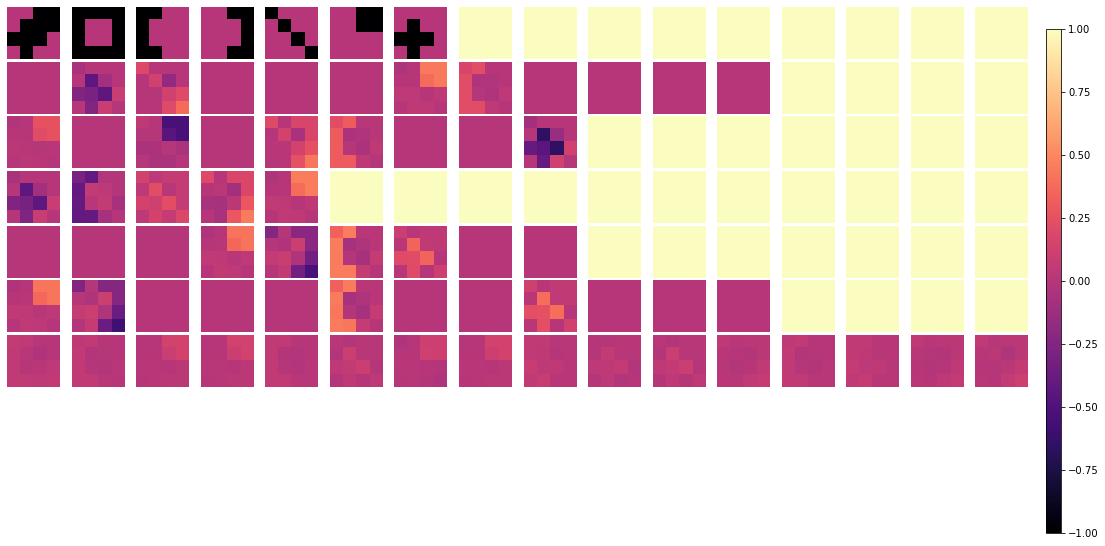

Epoch:  1 , Loss:  2.407698631286621 , Val Loss:  1.746648907661438
Epoch:  50 , Loss:  0.3236510753631592 , Val Loss:  0.23872053623199463
Epoch:  100 , Loss:  0.23215042054653168 , Val Loss:  0.14865447580814362
Epoch:  150 , Loss:  0.20029981434345245 , Val Loss:  0.1141660287976265
Epoch:  200 , Loss:  0.18712083995342255 , Val Loss:  0.09885591268539429
Epoch:  250 , Loss:  0.188322514295578 , Val Loss:  0.09452402591705322
Epoch:  300 , Loss:  0.17924898862838745 , Val Loss:  0.08897750824689865
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.004, 19, False, True, 'selu', 300, 150]
(112, 16)


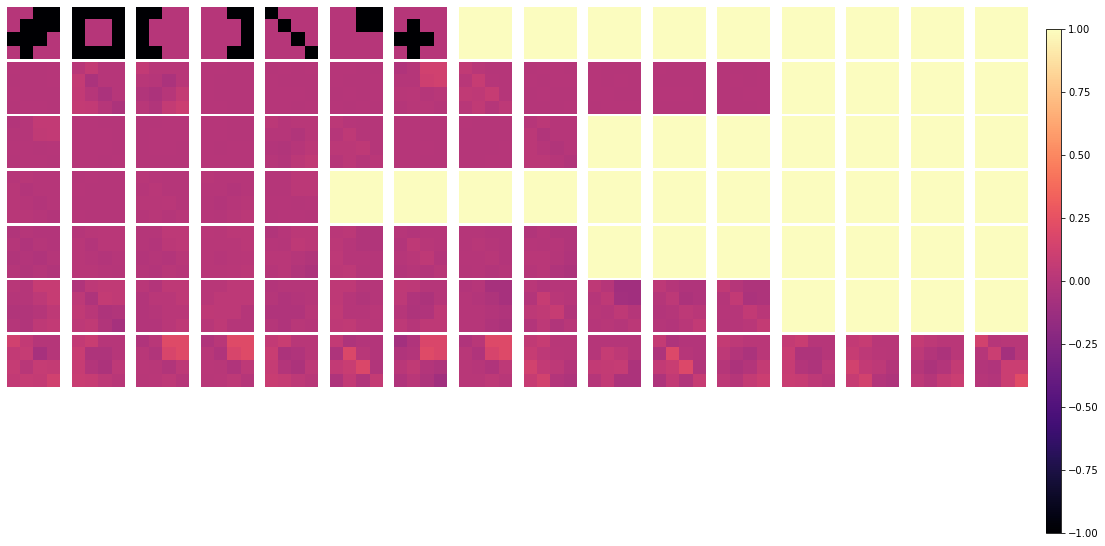

Epoch:  1 , Loss:  2.3896281719207764 , Val Loss:  1.7054524421691895
Epoch:  50 , Loss:  0.27762022614479065 , Val Loss:  0.19461722671985626
Epoch:  100 , Loss:  0.21038088202476501 , Val Loss:  0.12930577993392944
Epoch:  150 , Loss:  0.18705090880393982 , Val Loss:  0.10138186812400818
Epoch:  200 , Loss:  0.17896217107772827 , Val Loss:  0.09155075997114182
Epoch:  250 , Loss:  0.1764577031135559 , Val Loss:  0.09015840291976929
Epoch:  300 , Loss:  0.1735033392906189 , Val Loss:  0.08527104556560516
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.004, 19, True, False, 'selu', 300, 150]
(112, 16)


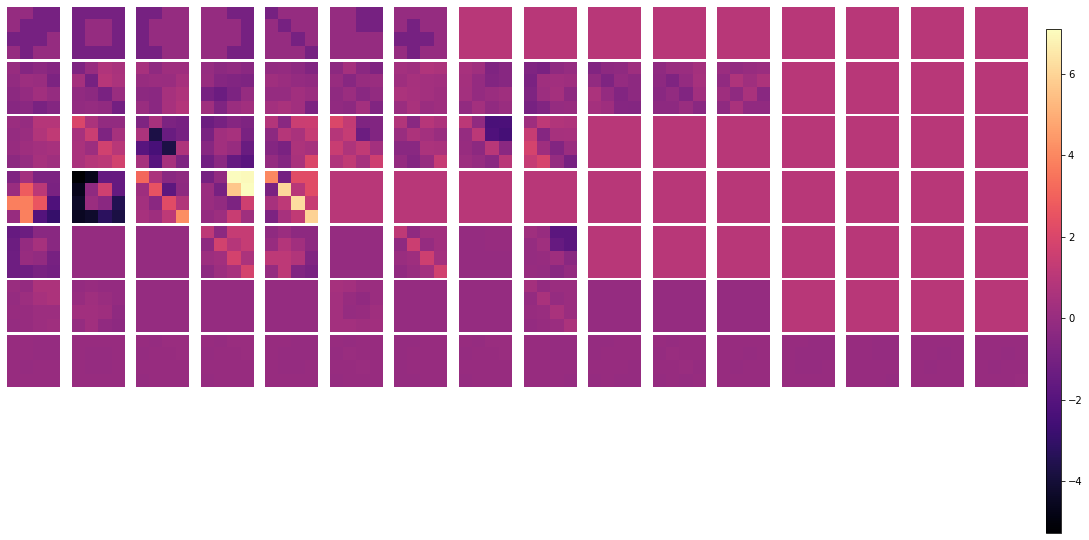

Epoch:  1 , Loss:  2.043307304382324 , Val Loss:  1.3773468732833862
Epoch:  50 , Loss:  0.1682070791721344 , Val Loss:  0.07399067282676697
Epoch:  100 , Loss:  0.15856866538524628 , Val Loss:  0.06674040853977203
Epoch:  150 , Loss:  0.15599220991134644 , Val Loss:  0.05511636286973953
Epoch:  200 , Loss:  0.1490231454372406 , Val Loss:  0.05092797800898552
Epoch:  250 , Loss:  0.14588987827301025 , Val Loss:  0.04636358097195625
Epoch:  300 , Loss:  0.14185988903045654 , Val Loss:  0.04175138846039772
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.004, 19, False, False, 'selu', 300, 150]
(112, 16)


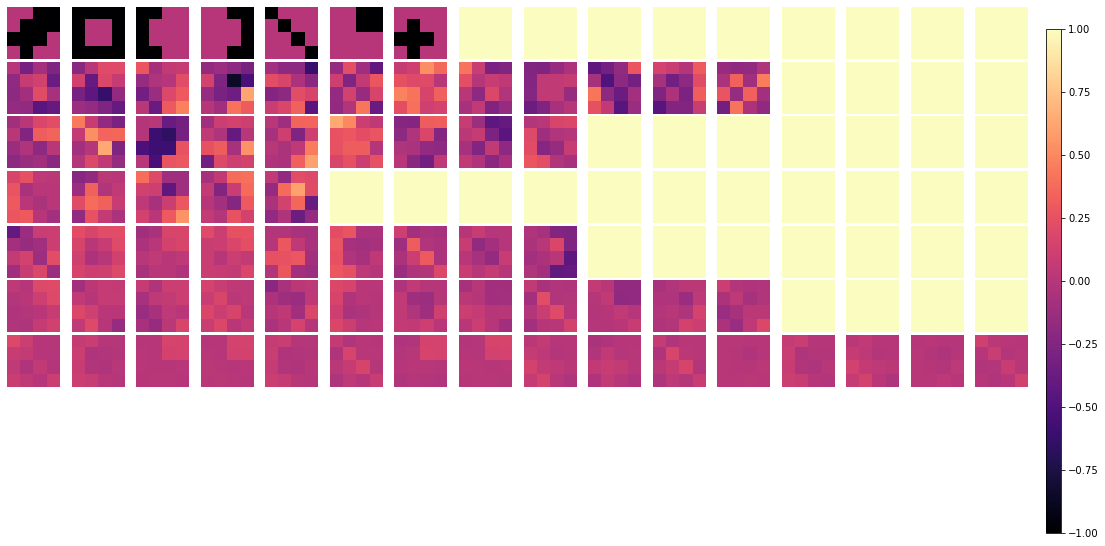

Epoch:  1 , Loss:  2.4032630920410156 , Val Loss:  1.7311217784881592
Epoch:  50 , Loss:  0.3673607110977173 , Val Loss:  0.2823162078857422
Epoch:  100 , Loss:  0.2940780520439148 , Val Loss:  0.21110746264457703
Epoch:  150 , Loss:  0.26335880160331726 , Val Loss:  0.17850326001644135
Epoch:  200 , Loss:  0.24365144968032837 , Val Loss:  0.1575760841369629
Epoch:  250 , Loss:  0.23223914206027985 , Val Loss:  0.14884641766548157
Epoch:  300 , Loss:  0.2257344126701355 , Val Loss:  0.14146095514297485
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.002, 19, True, True, 'selu', 300, 150]
(112, 16)


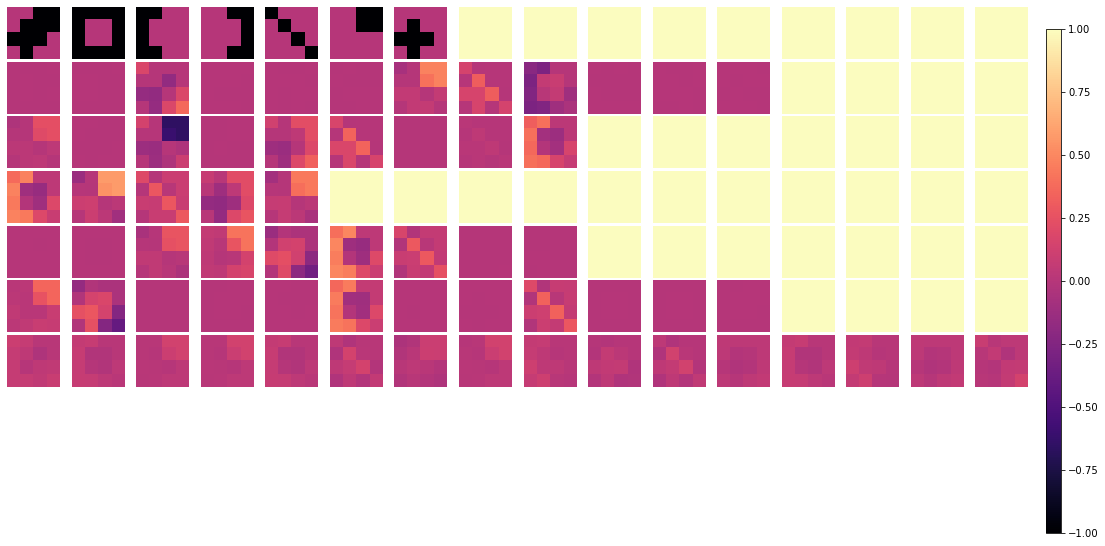

Epoch:  1 , Loss:  2.2146079540252686 , Val Loss:  1.5535790920257568
Epoch:  50 , Loss:  0.27541542053222656 , Val Loss:  0.18157383799552917
Epoch:  100 , Loss:  0.2210109680891037 , Val Loss:  0.1284247785806656
Epoch:  150 , Loss:  0.19342027604579926 , Val Loss:  0.10296665132045746
Epoch:  200 , Loss:  0.1856943517923355 , Val Loss:  0.09331362694501877
Epoch:  250 , Loss:  0.1799229234457016 , Val Loss:  0.08600658923387527
Epoch:  300 , Loss:  0.17391373217105865 , Val Loss:  0.08182309567928314
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.002, 19, False, True, 'selu', 300, 150]
(112, 16)


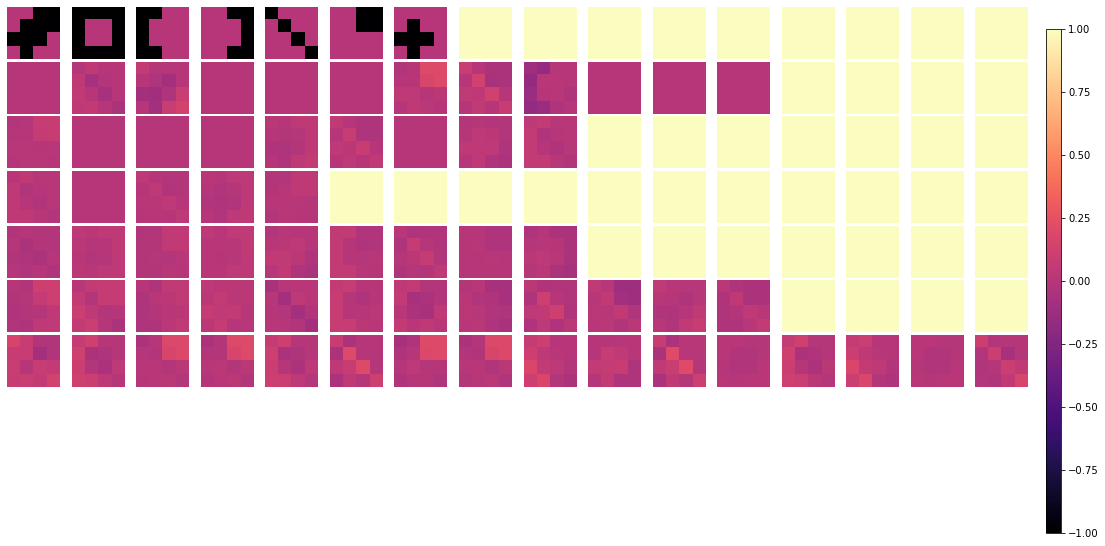

Epoch:  1 , Loss:  2.2168827056884766 , Val Loss:  1.556767463684082
Epoch:  50 , Loss:  0.24745656549930573 , Val Loss:  0.1590394228696823
Epoch:  100 , Loss:  0.20704764127731323 , Val Loss:  0.1186394989490509
Epoch:  150 , Loss:  0.18629547953605652 , Val Loss:  0.1014435663819313
Epoch:  200 , Loss:  0.17552465200424194 , Val Loss:  0.08846492320299149
Epoch:  250 , Loss:  0.17373569309711456 , Val Loss:  0.08360615372657776
Epoch:  300 , Loss:  0.16866499185562134 , Val Loss:  0.07935109734535217
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.002, 19, True, False, 'selu', 300, 150]
(112, 16)


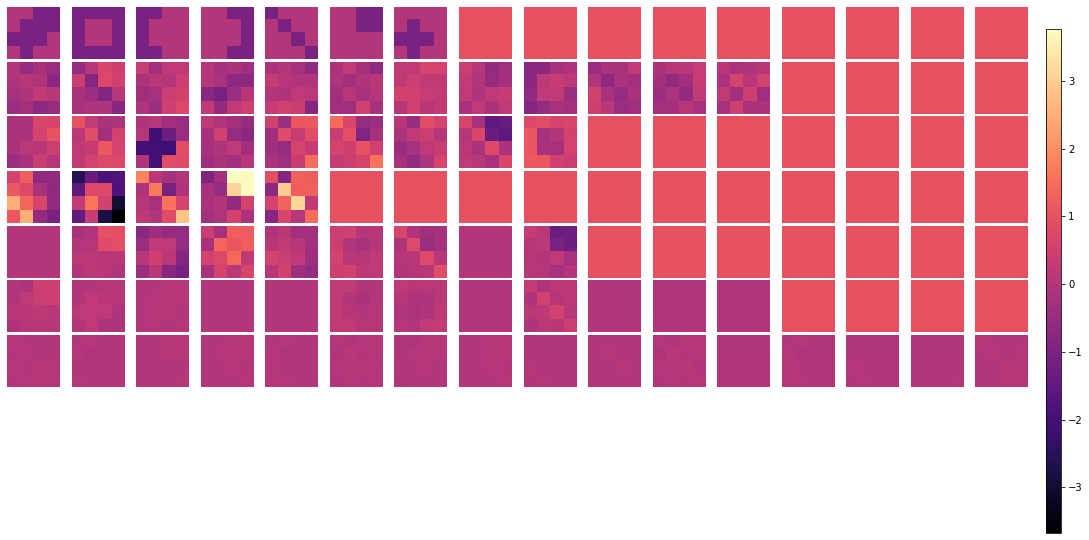

Epoch:  1 , Loss:  2.0411291122436523 , Val Loss:  1.3764139413833618
Epoch:  50 , Loss:  0.16739189624786377 , Val Loss:  0.07295860350131989
Epoch:  100 , Loss:  0.15851429104804993 , Val Loss:  0.06651590019464493
Epoch:  150 , Loss:  0.1534053236246109 , Val Loss:  0.05410733073949814
Epoch:  200 , Loss:  0.15114139020442963 , Val Loss:  0.04991135001182556
Epoch:  250 , Loss:  0.14664775133132935 , Val Loss:  0.046542346477508545
Epoch:  300 , Loss:  0.14048205316066742 , Val Loss:  0.042257413268089294
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.002, 19, False, False, 'selu', 300, 150]
(112, 16)


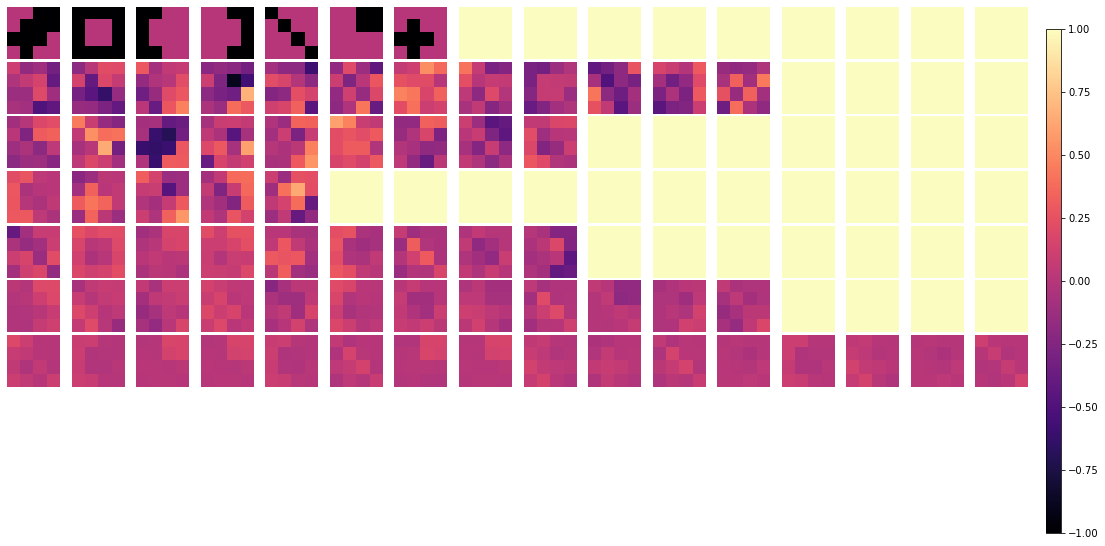

Epoch:  1 , Loss:  2.2099125385284424 , Val Loss:  1.5476781129837036
Epoch:  50 , Loss:  0.27765655517578125 , Val Loss:  0.1884358674287796
Epoch:  100 , Loss:  0.2445622980594635 , Val Loss:  0.15391293168067932
Epoch:  150 , Loss:  0.22143056988716125 , Val Loss:  0.13495153188705444
Epoch:  200 , Loss:  0.2083560675382614 , Val Loss:  0.12126506865024567
Epoch:  250 , Loss:  0.20200906693935394 , Val Loss:  0.11351650208234787
Epoch:  300 , Loss:  0.19742295145988464 , Val Loss:  0.10817258059978485
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0009, 19, True, True, 'selu', 300, 150]
(112, 16)


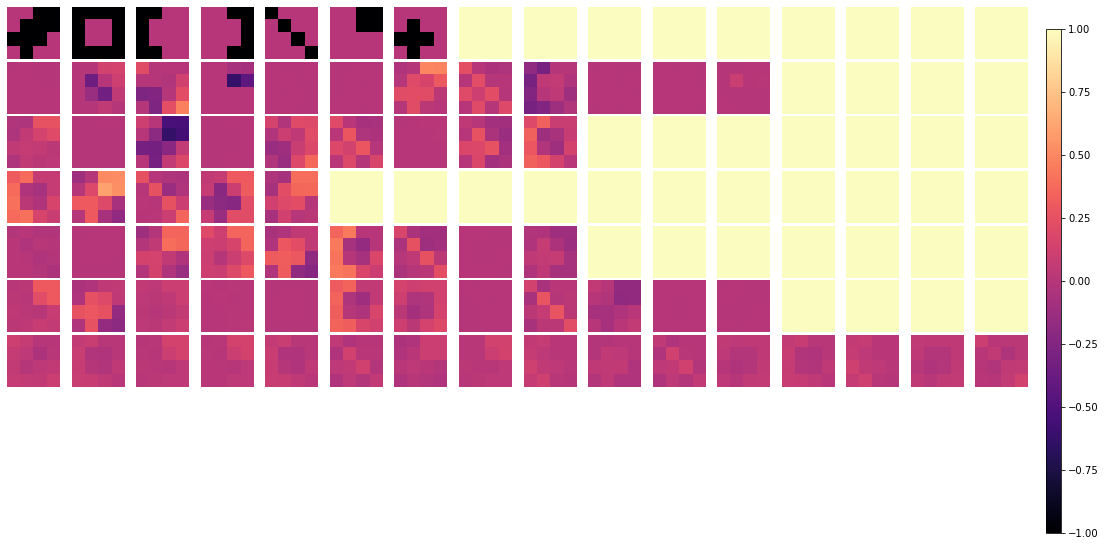

Epoch:  1 , Loss:  2.1456189155578613 , Val Loss:  1.4613027572631836
Epoch:  50 , Loss:  0.22740280628204346 , Val Loss:  0.13487155735492706
Epoch:  100 , Loss:  0.20079036056995392 , Val Loss:  0.11001270264387131
Epoch:  150 , Loss:  0.185797780752182 , Val Loss:  0.09099512547254562
Epoch:  200 , Loss:  0.1723891943693161 , Val Loss:  0.07222024351358414
Epoch:  250 , Loss:  0.16857996582984924 , Val Loss:  0.06323590129613876
Epoch:  300 , Loss:  0.1623658537864685 , Val Loss:  0.05853129178285599
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0009, 19, False, True, 'selu', 300, 150]
(112, 16)


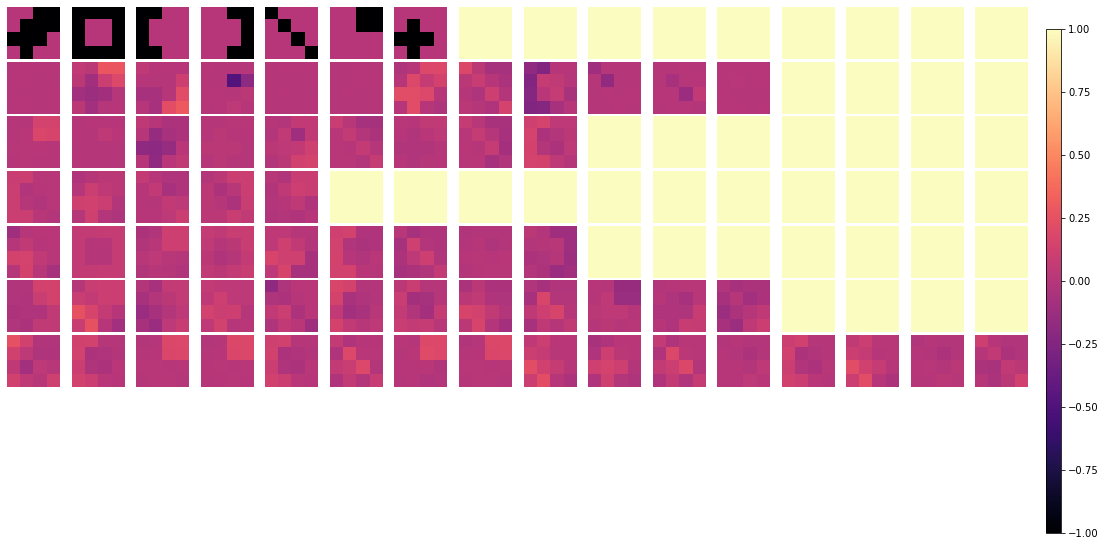

Epoch:  1 , Loss:  2.1376748085021973 , Val Loss:  1.4587750434875488
Epoch:  50 , Loss:  0.21548573672771454 , Val Loss:  0.12329742312431335
Epoch:  100 , Loss:  0.19454635679721832 , Val Loss:  0.10346608608961105
Epoch:  150 , Loss:  0.18149137496948242 , Val Loss:  0.09653492271900177
Epoch:  200 , Loss:  0.1707969307899475 , Val Loss:  0.08279844373464584
Epoch:  250 , Loss:  0.16125643253326416 , Val Loss:  0.06880321353673935
Epoch:  300 , Loss:  0.1637311577796936 , Val Loss:  0.06264487653970718
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0009, 19, True, False, 'selu', 300, 150]
(112, 16)


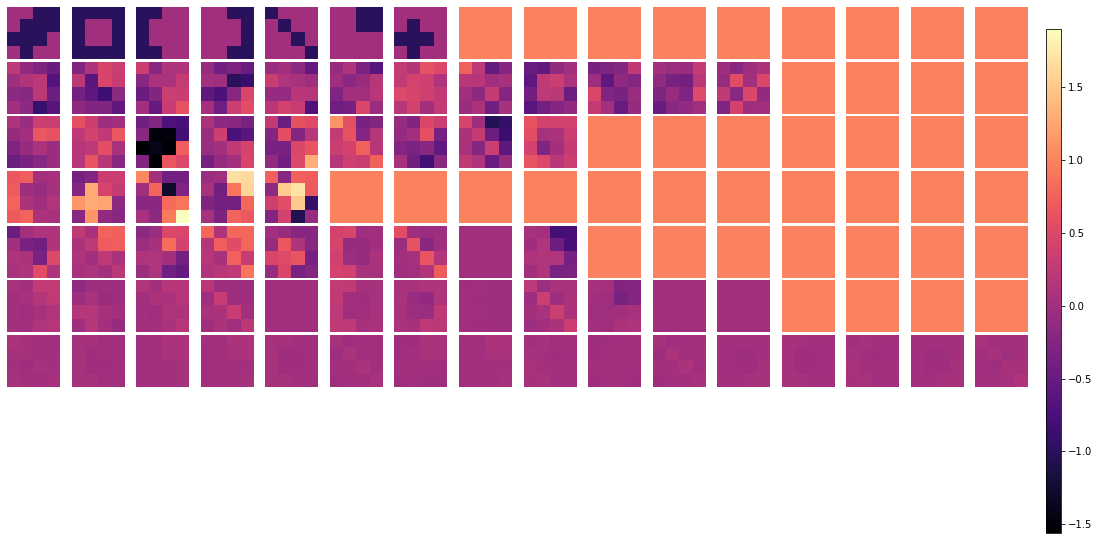

Epoch:  1 , Loss:  2.0497255325317383 , Val Loss:  1.3821556568145752
Epoch:  50 , Loss:  0.16977404057979584 , Val Loss:  0.07258789241313934
Epoch:  100 , Loss:  0.1584002822637558 , Val Loss:  0.06571199744939804
Epoch:  150 , Loss:  0.15238508582115173 , Val Loss:  0.054958563297986984
Epoch:  200 , Loss:  0.14742355048656464 , Val Loss:  0.04913505166769028
Epoch:  250 , Loss:  0.14551302790641785 , Val Loss:  0.04589614272117615
Epoch:  300 , Loss:  0.14592601358890533 , Val Loss:  0.04312651604413986
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0009, 19, False, False, 'selu', 300, 150]
(112, 16)


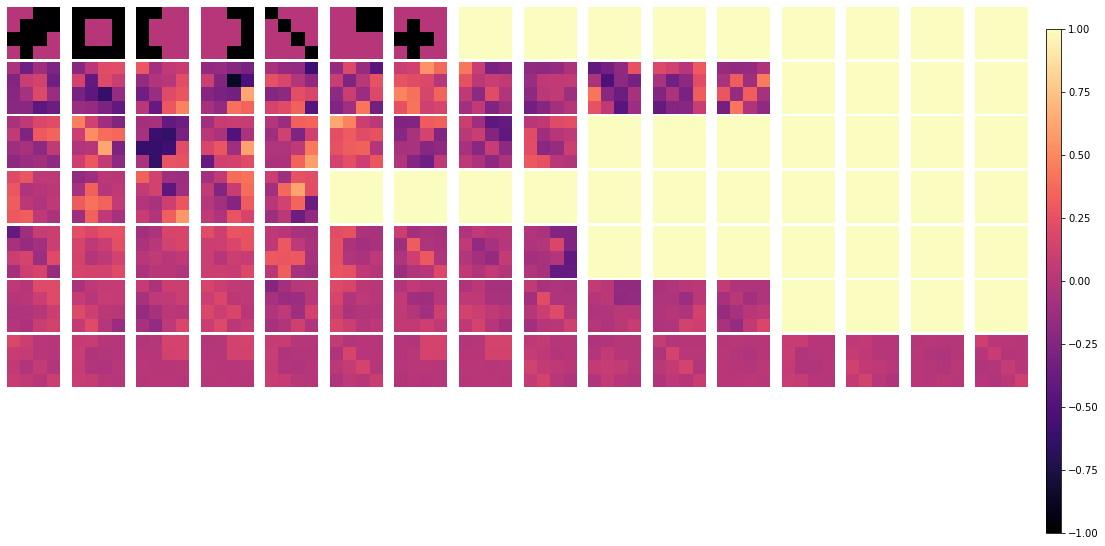

In [79]:
### Model Selection 2
arches = [[16,14,12,10,8,6,8,10,12,14,16], [16, 12, 9, 5, 9, 12, 16]]
rrs = [0.004, 0.002, 0.0009]
encoder_regs = [True, False]
decoder_regs = [True, False]
drop_rate = 0.3

for arch in arches:
    for rr in rrs:
        for decoder_reg in decoder_regs:
            for encoder_reg in encoder_regs:
                encoder_ae, decoder_ae, hparams = run_autoencoder(noise=True, arch=arch, 
                                                                  decoder_reg=decoder_reg, 
                                                                  encoder_reg=encoder_reg, 
                                                                  e=300, rr=rr, seed=19, activ='selu')
                weights_ae = get_ae_weights(encoder_ae, decoder_ae)
                print(hparams)
                show_ae(weights_ae)

# Thoughts
- dropout tends to combine ground truth nodes. 
- dropout encoder does surprisingly well. 
- can't really say one is better than other
- really need to do model selection over more random seeds. 
- for some reason, overfitting with dropout leads to more distinct patterns in hidden nodes...
- not regularizing doesn't usually lead to clear results---need to regularize to get clear patterns.
    - either both encoder and decoder should be regularized or just decoder.
- try higher dropout rate, back to 0.5, and higher gaussian noise.
- try slightly lower regularization.

<a id='sparse_ae'></a>

# Sparse Autoencoder

In [80]:
import random

def run_autoencoder(arch = [16,8,4,8,16],
                    rr = 0.001,
                    seed = random.randint(0,999999999999),
                    encoder_reg = False,
                    decoder_reg = False,
                    activ = 'relu',
                    e = 200,
                    bs = 150,
                    dropout = False,
                    drop_rate = 0.5,
                    noise = False,
                    stdev = 1,
                    sparse = False,
                    sparse_rate = 0.001
                    ):
    
    if dropout and noise:
        print('Error! Choose either dropout or gaussian noise, but not both.')
        return False
    
    hyperparams = [arch,rr,seed,encoder_reg,decoder_reg,activ,e,bs,sparse_rate]
    tf.random.set_seed(seed)
    mid_index = int(len(arch)/2)

    ### ENCODER
    stacked_encoder = keras.Sequential()
    if dropout:
        stacked_encoder.add(keras.layers.Dropout(drop_rate))
    elif noise:
        stacked_encoder.add(keras.layers.GaussianNoise(stdev))
        
    for i in range(1, mid_index+1):
        if i == mid_index and sparse:
            if encoder_reg:
                stacked_encoder.add(keras.layers.Dense(arch[i], activation='sigmoid', 
                                                       kernel_regularizer=keras.regularizers.l1(rr),
                                                       activity_regularizer=keras.regularizers.l1(sparse_rate)))
            else:
                stacked_encoder.add(keras.layers.Dense(arch[i], activation='sigmoid',
                                                       activity_regularizer=keras.regularizers.l1(sparse_rate)))
        else:    
            if encoder_reg:
                stacked_encoder.add(keras.layers.Dense(arch[i], activation=activ, 
                                                       kernel_regularizer=keras.regularizers.l1(rr)))
            else:
                stacked_encoder.add(keras.layers.Dense(arch[i], activation=activ))

    ### DECODER    
    stacked_decoder = keras.Sequential()
    for i in range(mid_index+1, len(arch)-1):
        if decoder_reg:
            stacked_decoder.add(keras.layers.Dense(arch[i], activation=activ, 
                                                   kernel_regularizer=keras.regularizers.l1(rr)))
        else:
            stacked_decoder.add(keras.layers.Dense(arch[i], activation=activ))
    if decoder_reg:       
        stacked_decoder.add(keras.layers.Dense(arch[-1], kernel_regularizer=keras.regularizers.l1(rr)))
    else:
        stacked_decoder.add(keras.layers.Dense(arch[-1]))

    ### BOTH
    stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss='mse', optimizer='adam')
    # stacked_ae.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=lr))
    history = stacked_ae.fit(train_dataset.labels, train_dataset.labels, 
                        epochs=e, batch_size=bs, verbose=0, callbacks=[PrintEvery50Epochs(), early_stopping],
                        validation_data=(validation_dataset.labels, validation_dataset.labels))
    
    return stacked_encoder, stacked_decoder, hyperparams

Epoch:  1 , Loss:  1.2658755779266357 , Val Loss:  0.9365805387496948
Epoch:  50 , Loss:  0.14108061790466309 , Val Loss:  0.1434907168149948
Epoch:  100 , Loss:  0.10444101691246033 , Val Loss:  0.1067255362868309
Epoch:  150 , Loss:  0.07765097171068192 , Val Loss:  0.07843678444623947
Epoch:  200 , Loss:  0.060842059552669525 , Val Loss:  0.06124419718980789
Epoch:  250 , Loss:  0.05068479850888252 , Val Loss:  0.05083571746945381
Epoch:  300 , Loss:  0.04437170550227165 , Val Loss:  0.044539473950862885
Epoch:  350 , Loss:  0.04091336950659752 , Val Loss:  0.040937505662441254
Epoch:  400 , Loss:  0.03810037672519684 , Val Loss:  0.038089655339717865
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0005, 19, True, True, 'selu', 400, 150, 0.001]
(176, 16)


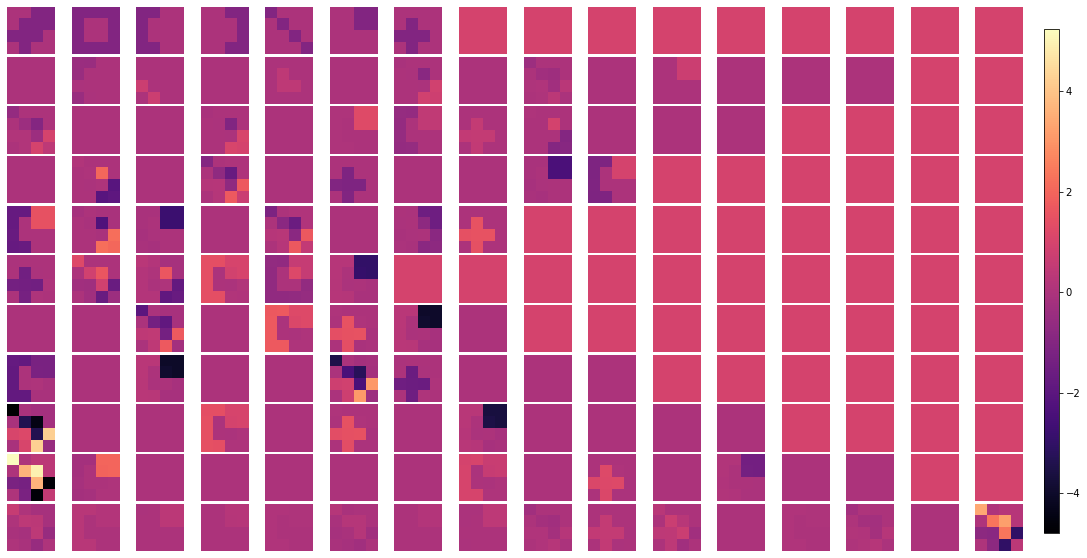

Epoch:  1 , Loss:  1.2647387981414795 , Val Loss:  0.9356529712677002
Epoch:  50 , Loss:  0.13921406865119934 , Val Loss:  0.141566663980484
Epoch:  100 , Loss:  0.10266800969839096 , Val Loss:  0.10504740476608276
Epoch:  150 , Loss:  0.07636890560388565 , Val Loss:  0.07708324491977692
Epoch:  200 , Loss:  0.059994857758283615 , Val Loss:  0.060297057032585144
Epoch:  250 , Loss:  0.04928627610206604 , Val Loss:  0.049374327063560486
Epoch:  300 , Loss:  0.044883158057928085 , Val Loss:  0.04503847658634186
Epoch:  350 , Loss:  0.04097897559404373 , Val Loss:  0.04104295000433922
Epoch:  400 , Loss:  0.038376618176698685 , Val Loss:  0.03840174525976181
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0005, 19, True, True, 'selu', 400, 150, 0.0005]
(176, 16)


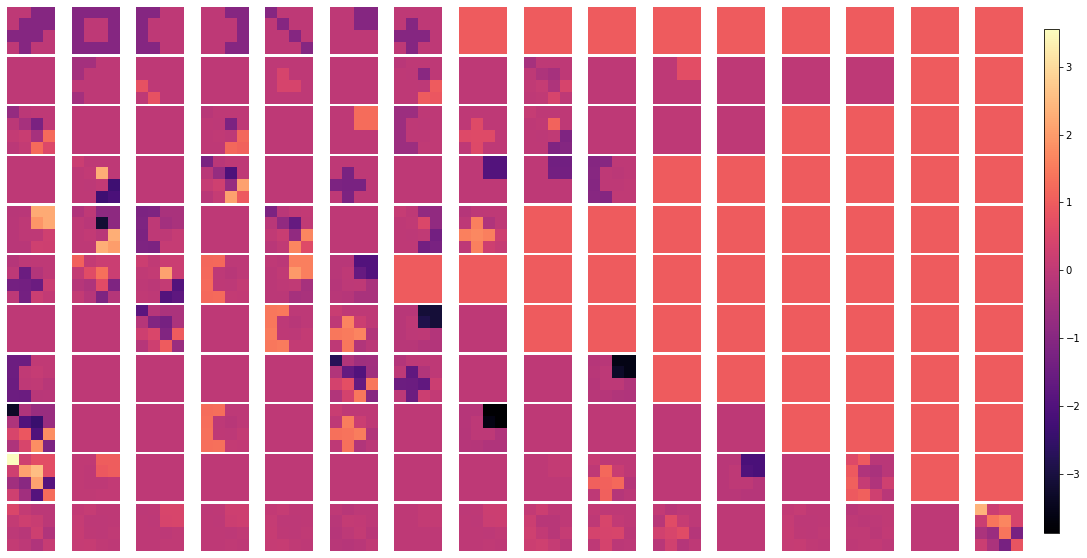

Epoch:  1 , Loss:  1.1865549087524414 , Val Loss:  0.85739666223526
Epoch:  50 , Loss:  0.09678015112876892 , Val Loss:  0.0988771989941597
Epoch:  100 , Loss:  0.060217346996068954 , Val Loss:  0.06014975160360336
Epoch:  150 , Loss:  0.0453692302107811 , Val Loss:  0.045349568128585815
Epoch:  200 , Loss:  0.03346473351120949 , Val Loss:  0.033372264355421066
Epoch:  250 , Loss:  0.023069068789482117 , Val Loss:  0.02301260456442833
Epoch:  300 , Loss:  0.020282506942749023 , Val Loss:  0.020229147747159004
Epoch:  350 , Loss:  0.01963922753930092 , Val Loss:  0.019589196890592575
Epoch:  400 , Loss:  0.019576292484998703 , Val Loss:  0.01953457109630108
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0005, 19, False, True, 'selu', 400, 150, 0.001]
(176, 16)


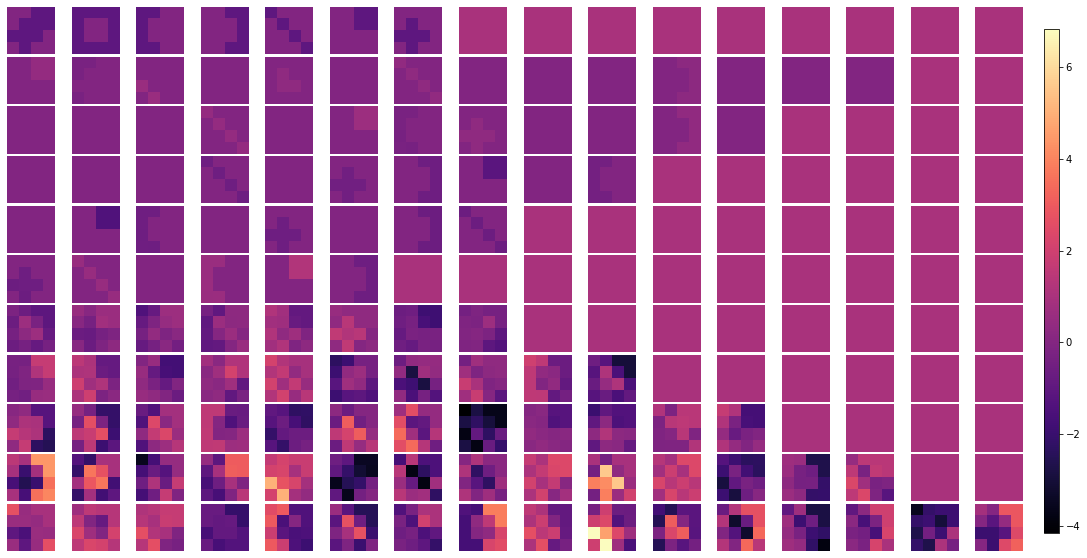

Epoch:  1 , Loss:  1.1854102611541748 , Val Loss:  0.856500506401062
Epoch:  50 , Loss:  0.0950821042060852 , Val Loss:  0.09730780124664307
Epoch:  100 , Loss:  0.05871795490384102 , Val Loss:  0.05862351879477501
Epoch:  150 , Loss:  0.04377716779708862 , Val Loss:  0.04372485727071762
Epoch:  200 , Loss:  0.03285035490989685 , Val Loss:  0.032762281596660614
Epoch:  250 , Loss:  0.024186093360185623 , Val Loss:  0.024143463000655174
Epoch:  300 , Loss:  0.019055286422371864 , Val Loss:  0.018996424973011017
Epoch:  350 , Loss:  0.018352635204792023 , Val Loss:  0.018329909071326256
Epoch:  400 , Loss:  0.021897081285715103 , Val Loss:  0.019726017490029335
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0005, 19, False, True, 'selu', 400, 150, 0.0005]
(176, 16)


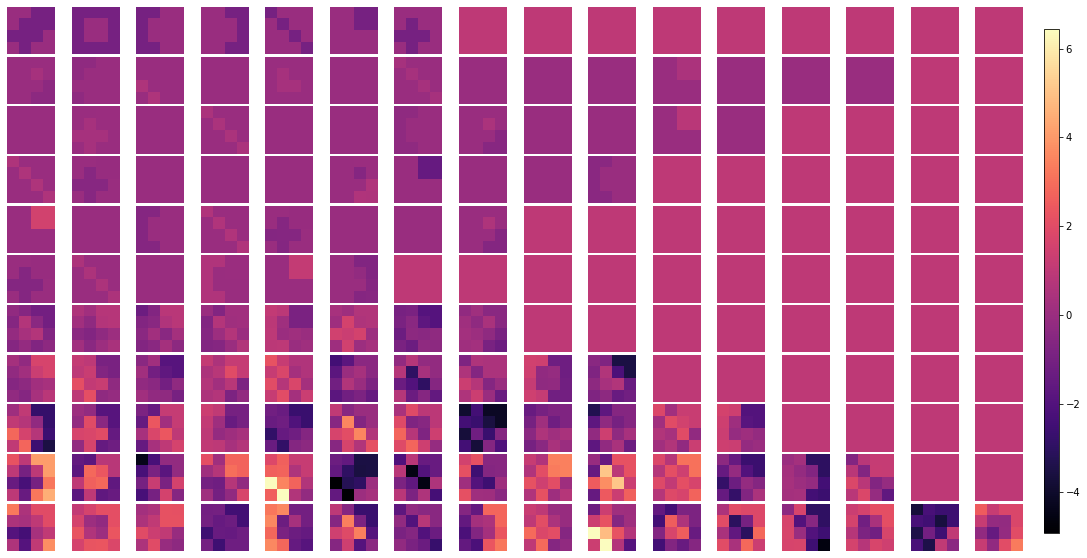

Epoch:  1 , Loss:  1.1848329305648804 , Val Loss:  0.8556100130081177
Epoch:  50 , Loss:  0.06473404169082642 , Val Loss:  0.06719162315130234
Epoch:  100 , Loss:  0.03759511187672615 , Val Loss:  0.039452552795410156
Epoch:  150 , Loss:  0.018830670043826103 , Val Loss:  0.018978072330355644
Epoch:  200 , Loss:  0.014877229928970337 , Val Loss:  0.015024312771856785
Epoch:  250 , Loss:  0.012874770909547806 , Val Loss:  0.012977555394172668
Epoch:  300 , Loss:  0.011550371535122395 , Val Loss:  0.011568078771233559
Epoch:  350 , Loss:  0.011190833523869514 , Val Loss:  0.011007619090378284
Epoch:  400 , Loss:  0.01070375181734562 , Val Loss:  0.010414734482765198
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0005, 19, True, False, 'selu', 400, 150, 0.001]
(176, 16)


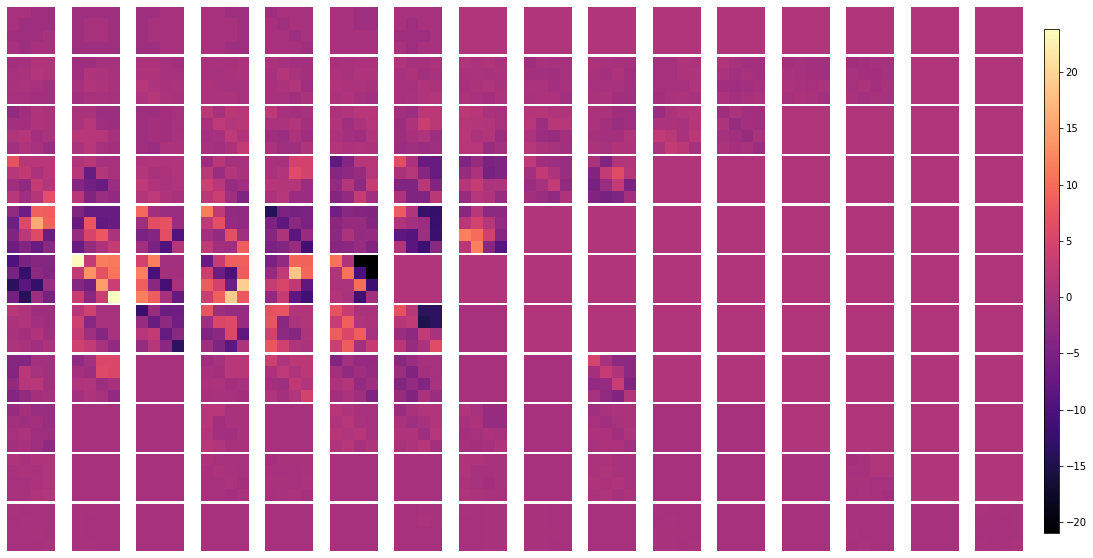

Epoch:  1 , Loss:  1.18359375 , Val Loss:  0.8544387221336365
Epoch:  50 , Loss:  0.06382069736719131 , Val Loss:  0.06626522541046143
Epoch:  100 , Loss:  0.0374373123049736 , Val Loss:  0.03985908627510071
Epoch:  150 , Loss:  0.017875542864203453 , Val Loss:  0.01802661456167698
Epoch:  200 , Loss:  0.013623947277665138 , Val Loss:  0.013717303052544594
Epoch:  250 , Loss:  0.01166750118136406 , Val Loss:  0.011658916249871254
Epoch:  300 , Loss:  0.010358693078160286 , Val Loss:  0.010366484522819519
Epoch:  350 , Loss:  0.009706276468932629 , Val Loss:  0.009668330661952496
Epoch:  400 , Loss:  0.008822686970233917 , Val Loss:  0.008796757087111473
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0005, 19, True, False, 'selu', 400, 150, 0.0005]
(176, 16)


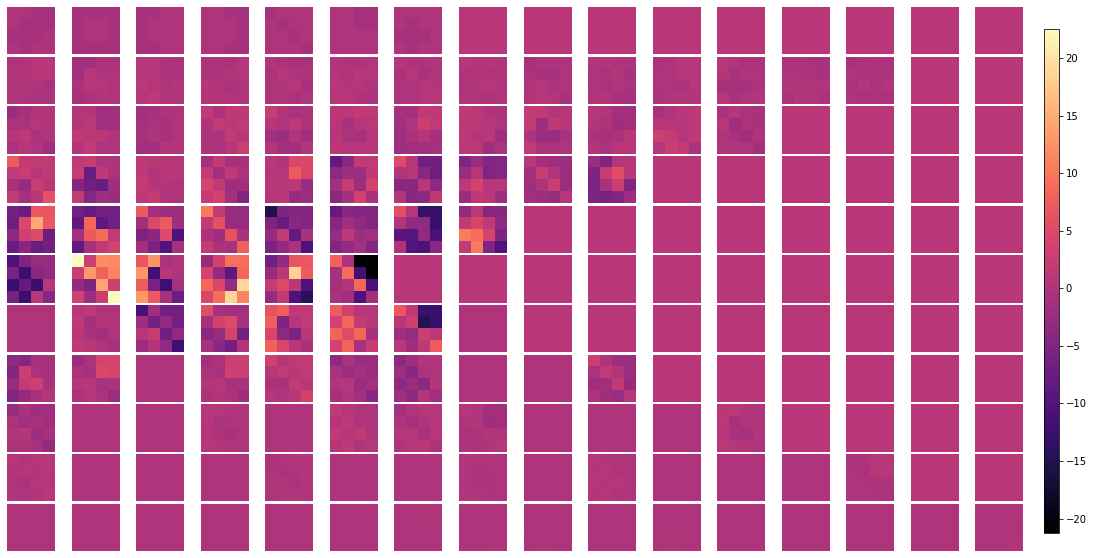

Epoch:  1 , Loss:  1.1055314540863037 , Val Loss:  0.7764876484870911
Epoch:  50 , Loss:  0.023356279358267784 , Val Loss:  0.025569923222064972
Epoch:  100 , Loss:  0.0034191564191132784 , Val Loss:  0.003381496760994196
Epoch:  150 , Loss:  0.002528713783249259 , Val Loss:  0.002526769181713462
Epoch:  200 , Loss:  0.0019377650460228324 , Val Loss:  0.0019614568445831537
Epoch:  250 , Loss:  0.0015237551415339112 , Val Loss:  0.0015352045884355903
Epoch:  300 , Loss:  0.0012261437950655818 , Val Loss:  0.001235893927514553
Epoch:  350 , Loss:  0.001009611296467483 , Val Loss:  0.0009834358934313059
Epoch:  400 , Loss:  0.0009024530882015824 , Val Loss:  0.0008234435808844864
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0005, 19, False, False, 'selu', 400, 150, 0.001]
(176, 16)


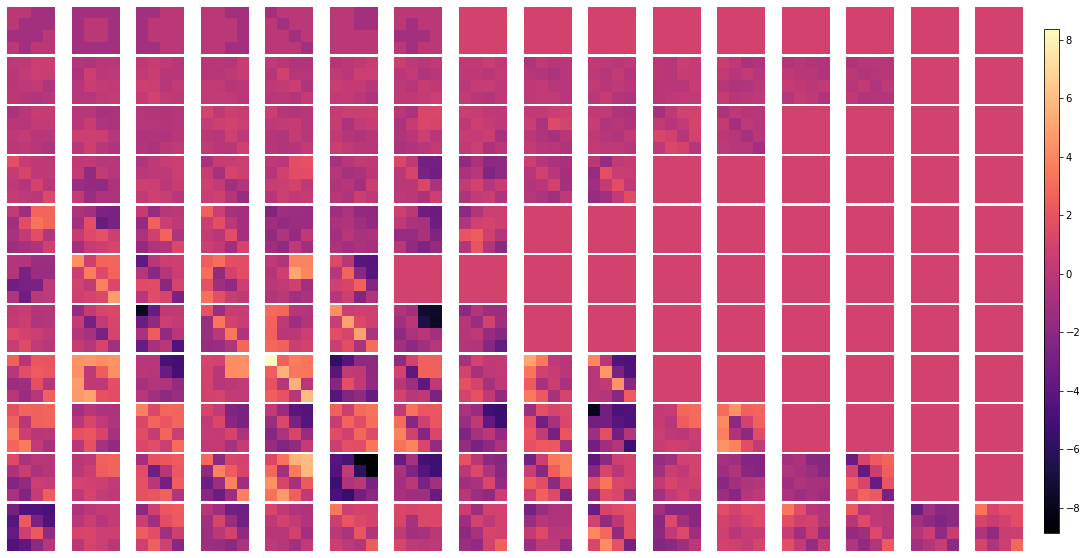

Epoch:  1 , Loss:  1.1043657064437866 , Val Loss:  0.7755211591720581
Epoch:  50 , Loss:  0.02140958048403263 , Val Loss:  0.023540392518043518
Epoch:  100 , Loss:  0.0020598703995347023 , Val Loss:  0.002125539118424058
Epoch:  150 , Loss:  0.001594969886355102 , Val Loss:  0.00162634311709553
Epoch:  200 , Loss:  0.001387314172461629 , Val Loss:  0.0014137264806777239
Epoch:  250 , Loss:  0.001247880980372429 , Val Loss:  0.0012646506074815989
Epoch:  300 , Loss:  0.0015002073487266898 , Val Loss:  0.0013772157253697515
Epoch:  350 , Loss:  0.0010136411292478442 , Val Loss:  0.0010351036908105016
Epoch:  400 , Loss:  0.0009334775386378169 , Val Loss:  0.0009263501269742846
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0005, 19, False, False, 'selu', 400, 150, 0.0005]
(176, 16)


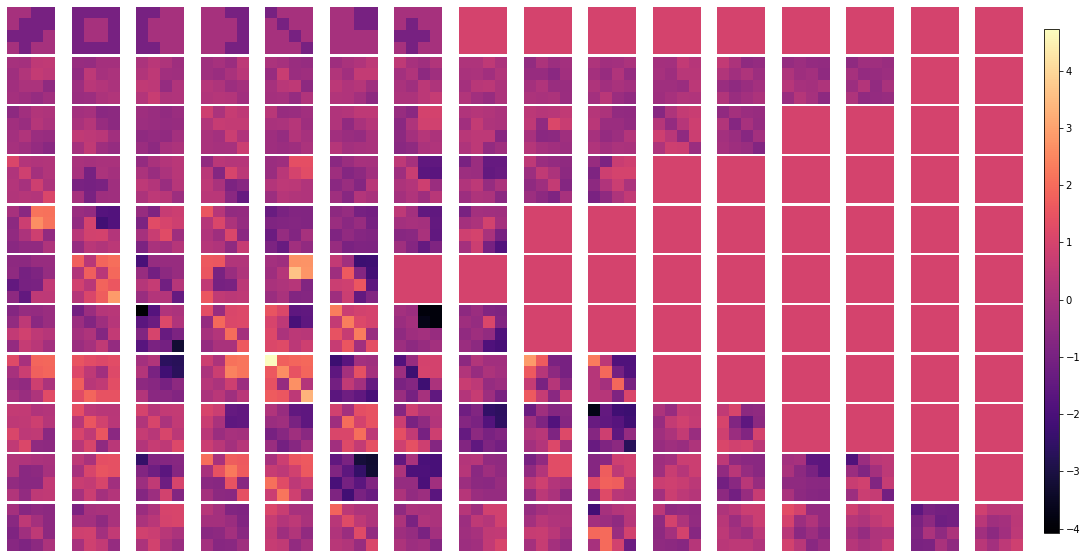

Epoch:  1 , Loss:  1.1376672983169556 , Val Loss:  0.8085456490516663
Epoch:  50 , Loss:  0.054963912814855576 , Val Loss:  0.05737999454140663
Epoch:  100 , Loss:  0.031460829079151154 , Val Loss:  0.03151991218328476
Epoch:  150 , Loss:  0.026845967397093773 , Val Loss:  0.026851598173379898
Epoch:  200 , Loss:  0.023078616708517075 , Val Loss:  0.0230611190199852
Epoch:  250 , Loss:  0.019897349178791046 , Val Loss:  0.019877508282661438
Epoch:  300 , Loss:  0.017170321196317673 , Val Loss:  0.017170904204249382
Epoch:  350 , Loss:  0.015165495686233044 , Val Loss:  0.01534558366984129
Epoch:  400 , Loss:  0.013713040389120579 , Val Loss:  0.0137164406478405
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0001, 19, True, True, 'selu', 400, 150, 0.001]
(176, 16)


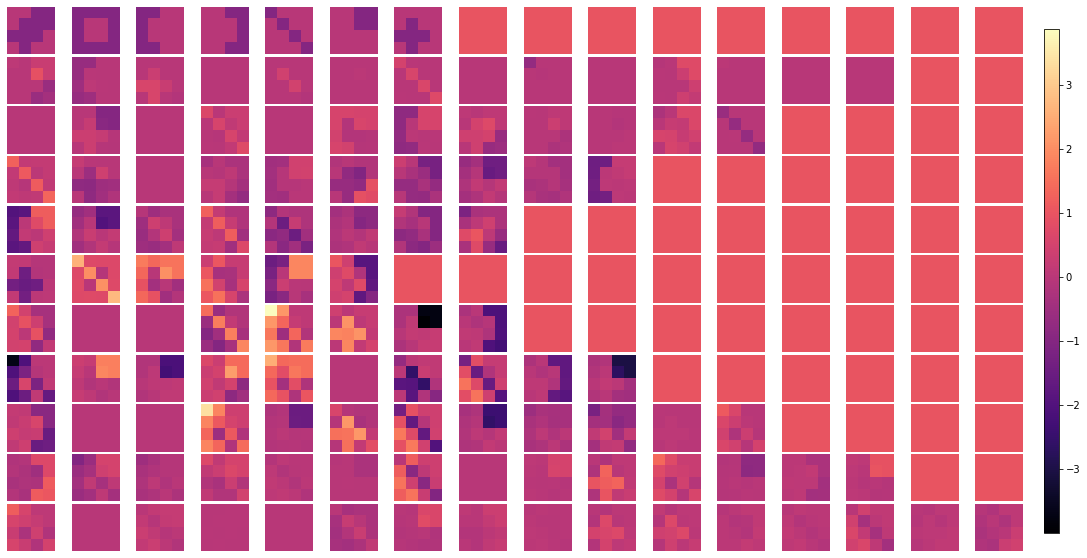

Epoch:  1 , Loss:  1.1365314722061157 , Val Loss:  0.8076964616775513
Epoch:  50 , Loss:  0.053621672093868256 , Val Loss:  0.05611710995435715
Epoch:  100 , Loss:  0.030409466475248337 , Val Loss:  0.030456453561782837
Epoch:  150 , Loss:  0.02562285214662552 , Val Loss:  0.025611627846956253
Epoch:  200 , Loss:  0.021530834957957268 , Val Loss:  0.021515993401408195
Epoch:  250 , Loss:  0.01827198825776577 , Val Loss:  0.018273523077368736
Epoch:  300 , Loss:  0.015597013756632805 , Val Loss:  0.01563948765397072
Epoch:  350 , Loss:  0.01352706179022789 , Val Loss:  0.013540809974074364
Epoch:  400 , Loss:  0.012331154197454453 , Val Loss:  0.012327403761446476
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0001, 19, True, True, 'selu', 400, 150, 0.0005]
(176, 16)


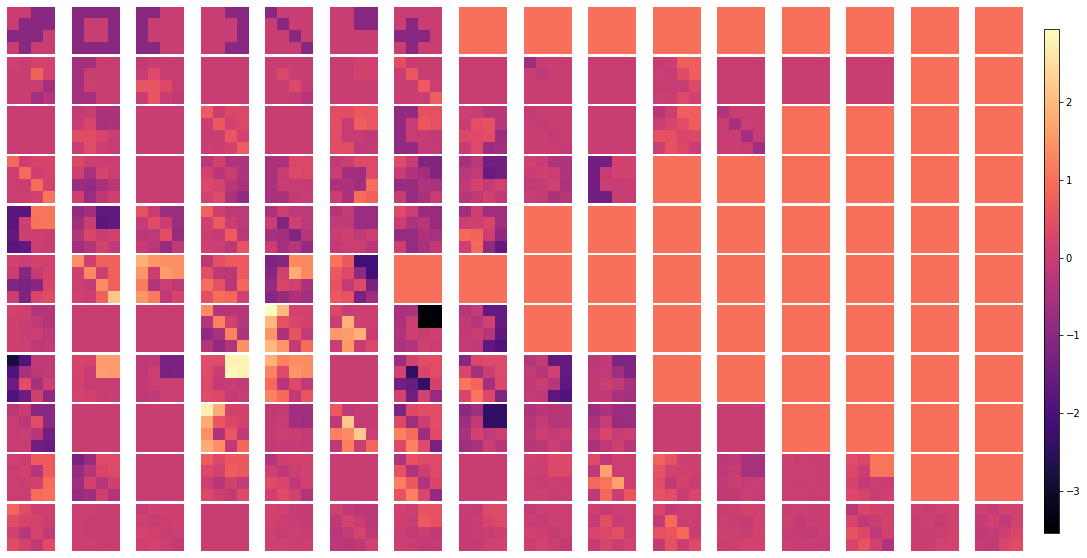

Epoch:  1 , Loss:  1.1217490434646606 , Val Loss:  0.792698085308075
Epoch:  50 , Loss:  0.04060877859592438 , Val Loss:  0.042918626219034195
Epoch:  100 , Loss:  0.019136205315589905 , Val Loss:  0.01915077306330204
Epoch:  150 , Loss:  0.016510965302586555 , Val Loss:  0.016496799886226654
Epoch:  200 , Loss:  0.014064264483749866 , Val Loss:  0.014063483104109764
Epoch:  250 , Loss:  0.01210102066397667 , Val Loss:  0.012067184783518314
Epoch:  300 , Loss:  0.010431651026010513 , Val Loss:  0.010486767627298832
Epoch:  350 , Loss:  0.008895546197891235 , Val Loss:  0.008878416381776333
Epoch:  400 , Loss:  0.007968718186020851 , Val Loss:  0.007950886152684689
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0001, 19, False, True, 'selu', 400, 150, 0.001]
(176, 16)


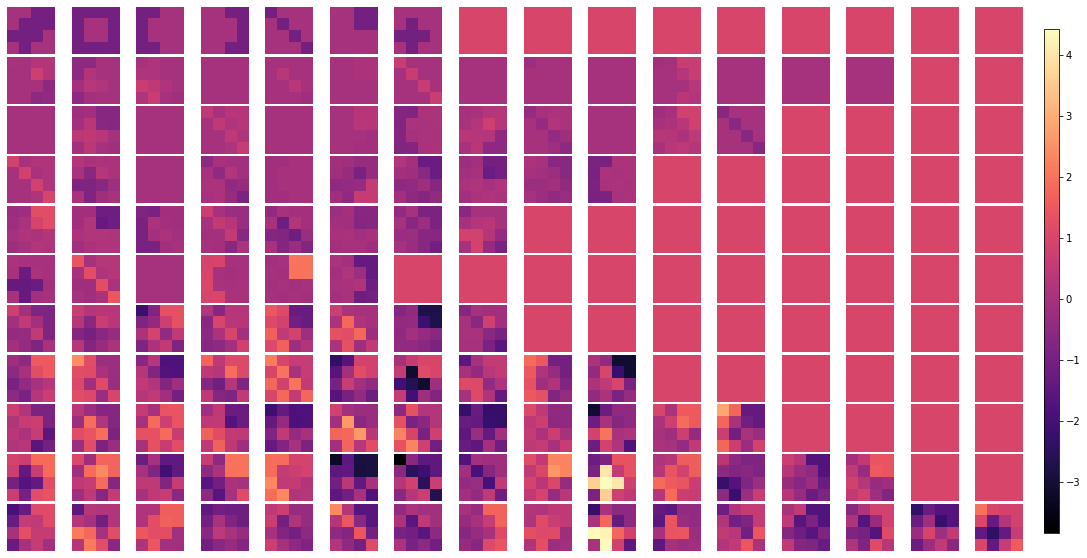

Epoch:  1 , Loss:  1.1205790042877197 , Val Loss:  0.791715681552887
Epoch:  50 , Loss:  0.03865183889865875 , Val Loss:  0.04093515872955322
Epoch:  100 , Loss:  0.01791343465447426 , Val Loss:  0.018018396571278572
Epoch:  150 , Loss:  0.015476346015930176 , Val Loss:  0.015490413643419743
Epoch:  200 , Loss:  0.013212434947490692 , Val Loss:  0.013213105499744415
Epoch:  250 , Loss:  0.011149566620588303 , Val Loss:  0.01116862241178751
Epoch:  300 , Loss:  0.009301736019551754 , Val Loss:  0.009316116571426392
Epoch:  350 , Loss:  0.007709546480327845 , Val Loss:  0.007707143202424049
Epoch:  400 , Loss:  0.006536915898323059 , Val Loss:  0.006533509120345116
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0001, 19, False, True, 'selu', 400, 150, 0.0005]
(176, 16)


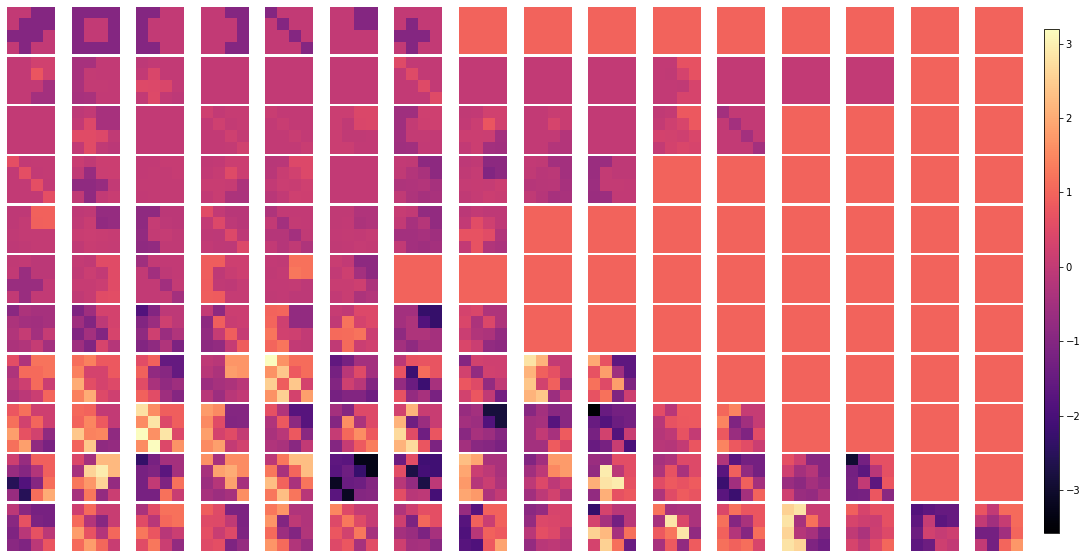

Epoch:  1 , Loss:  1.121427297592163 , Val Loss:  0.7922822833061218
Epoch:  50 , Loss:  0.037898823618888855 , Val Loss:  0.0404399074614048
Epoch:  100 , Loss:  0.015089479275047779 , Val Loss:  0.015076051466166973
Epoch:  150 , Loss:  0.012141881510615349 , Val Loss:  0.012148657813668251
Epoch:  200 , Loss:  0.009998593479394913 , Val Loss:  0.009920870885252953
Epoch:  250 , Loss:  0.008254428394138813 , Val Loss:  0.008259777911007404
Epoch:  300 , Loss:  0.0071581085212528706 , Val Loss:  0.007243578787893057
Epoch:  350 , Loss:  0.006367065943777561 , Val Loss:  0.006484461482614279
Epoch:  400 , Loss:  0.0057461997494101524 , Val Loss:  0.0057786996476352215
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0001, 19, True, False, 'selu', 400, 150, 0.001]
(176, 16)


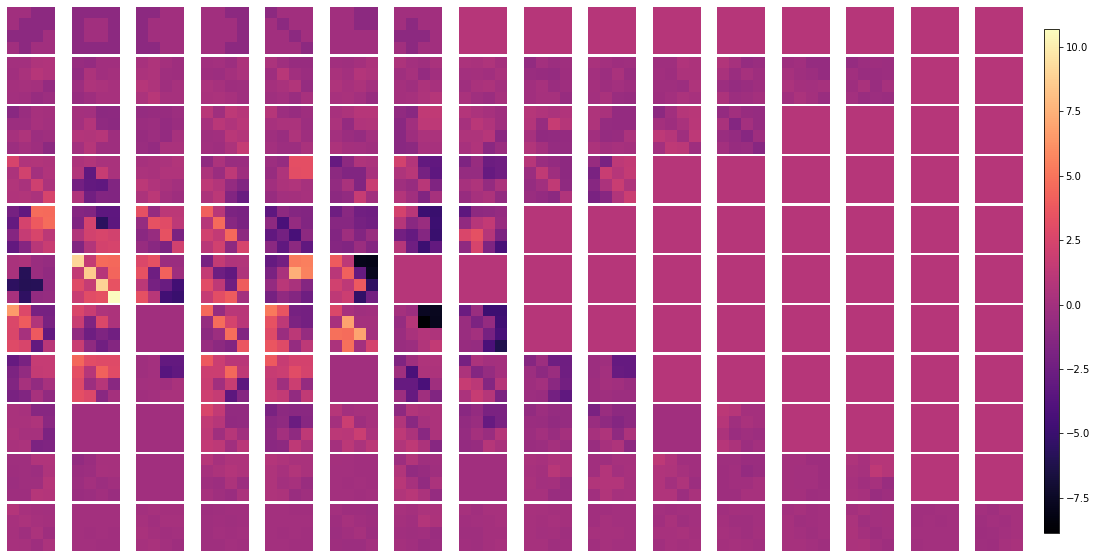

Epoch:  1 , Loss:  1.1202924251556396 , Val Loss:  0.7914454936981201
Epoch:  50 , Loss:  0.03665870428085327 , Val Loss:  0.03907383233308792
Epoch:  100 , Loss:  0.013817320577800274 , Val Loss:  0.013945958577096462
Epoch:  150 , Loss:  0.011067402549088001 , Val Loss:  0.01104195136576891
Epoch:  200 , Loss:  0.00920476671308279 , Val Loss:  0.009196050465106964
Epoch:  250 , Loss:  0.007890990003943443 , Val Loss:  0.00790619757026434
Epoch:  300 , Loss:  0.006831382401287556 , Val Loss:  0.006893965415656567
Epoch:  350 , Loss:  0.006070645991712809 , Val Loss:  0.0060587795451283455
Epoch:  400 , Loss:  0.005649481900036335 , Val Loss:  0.0058268229477107525
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0001, 19, True, False, 'selu', 400, 150, 0.0005]
(176, 16)


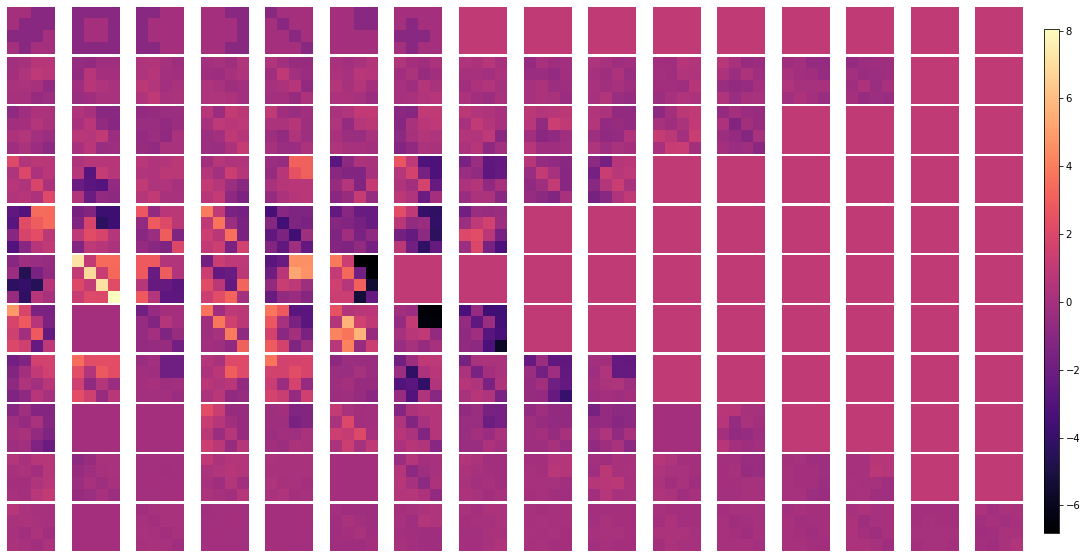

Epoch:  1 , Loss:  1.1055314540863037 , Val Loss:  0.7764876484870911
Epoch:  50 , Loss:  0.023356279358267784 , Val Loss:  0.025569923222064972
Epoch:  100 , Loss:  0.0034191564191132784 , Val Loss:  0.003381496760994196
Epoch:  150 , Loss:  0.002528713783249259 , Val Loss:  0.002526769181713462
Epoch:  200 , Loss:  0.0019377650460228324 , Val Loss:  0.0019614568445831537
Epoch:  250 , Loss:  0.0015237551415339112 , Val Loss:  0.0015352045884355903
Epoch:  300 , Loss:  0.0012261437950655818 , Val Loss:  0.001235893927514553
Epoch:  350 , Loss:  0.001009611296467483 , Val Loss:  0.0009834358934313059
Epoch:  400 , Loss:  0.0009024530882015824 , Val Loss:  0.0008234435808844864
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0001, 19, False, False, 'selu', 400, 150, 0.001]
(176, 16)


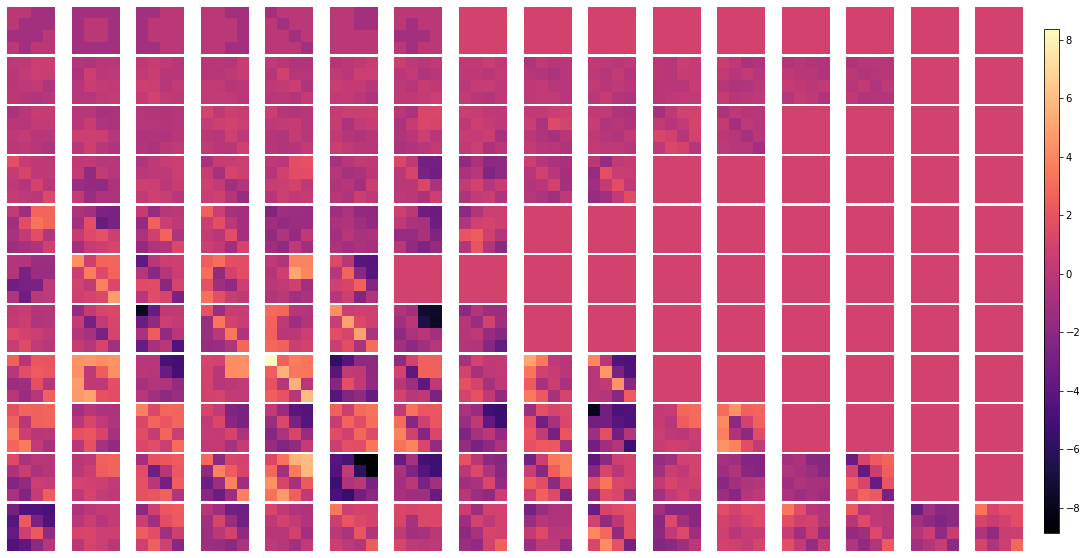

Epoch:  1 , Loss:  1.1043657064437866 , Val Loss:  0.7755211591720581
Epoch:  50 , Loss:  0.02140958048403263 , Val Loss:  0.023540392518043518
Epoch:  100 , Loss:  0.0020598703995347023 , Val Loss:  0.002125539118424058
Epoch:  150 , Loss:  0.001594969886355102 , Val Loss:  0.00162634311709553
Epoch:  200 , Loss:  0.001387314172461629 , Val Loss:  0.0014137264806777239
Epoch:  250 , Loss:  0.001247880980372429 , Val Loss:  0.0012646506074815989
Epoch:  300 , Loss:  0.0015002073487266898 , Val Loss:  0.0013772157253697515
Epoch:  350 , Loss:  0.0010136411292478442 , Val Loss:  0.0010351036908105016
Epoch:  400 , Loss:  0.0009334775386378169 , Val Loss:  0.0009263501269742846
(16, 14)
(14, 12)
(12, 10)
(10, 8)
(8, 6)
(6, 8)
(8, 10)
(10, 12)
(12, 14)
(14, 16)

[[16, 14, 12, 10, 8, 6, 8, 10, 12, 14, 16], 0.0001, 19, False, False, 'selu', 400, 150, 0.0005]
(176, 16)


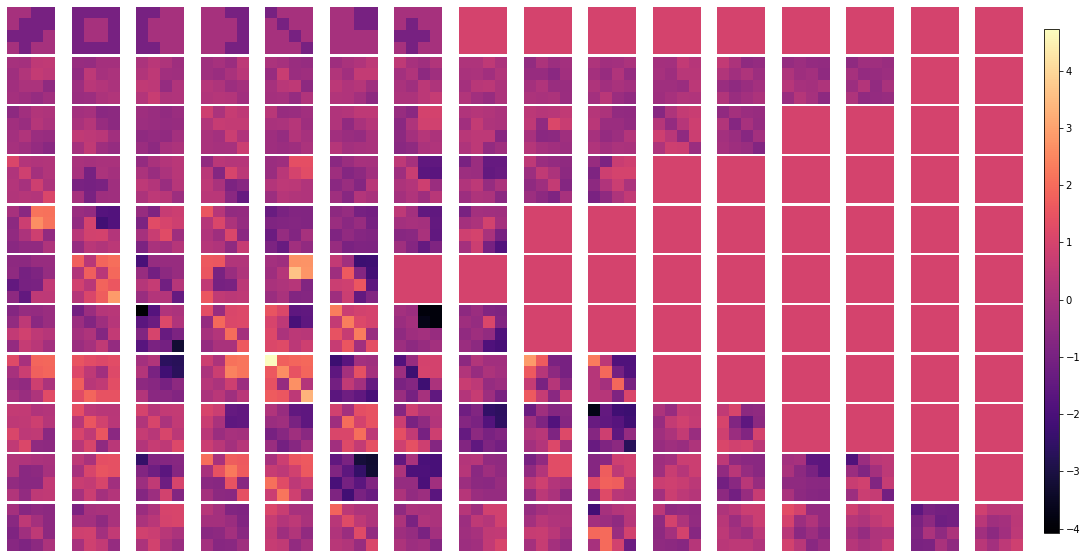

Epoch:  1 , Loss:  1.5798200368881226 , Val Loss:  1.252037763595581
Epoch:  50 , Loss:  0.09896968305110931 , Val Loss:  0.10107101500034332
Epoch:  100 , Loss:  0.08100514858961105 , Val Loss:  0.08350959420204163
Epoch:  150 , Loss:  0.06973883509635925 , Val Loss:  0.07244117558002472
Epoch:  200 , Loss:  0.058601461350917816 , Val Loss:  0.061628520488739014
Epoch:  250 , Loss:  0.04991750791668892 , Val Loss:  0.05269433557987213
Epoch:  300 , Loss:  0.04519367590546608 , Val Loss:  0.047381769865751266
Epoch:  350 , Loss:  0.04086645692586899 , Val Loss:  0.041992008686065674
Epoch:  400 , Loss:  0.039406705647706985 , Val Loss:  0.04033784195780754
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, True, True, 'selu', 400, 150, 0.001]
(112, 16)


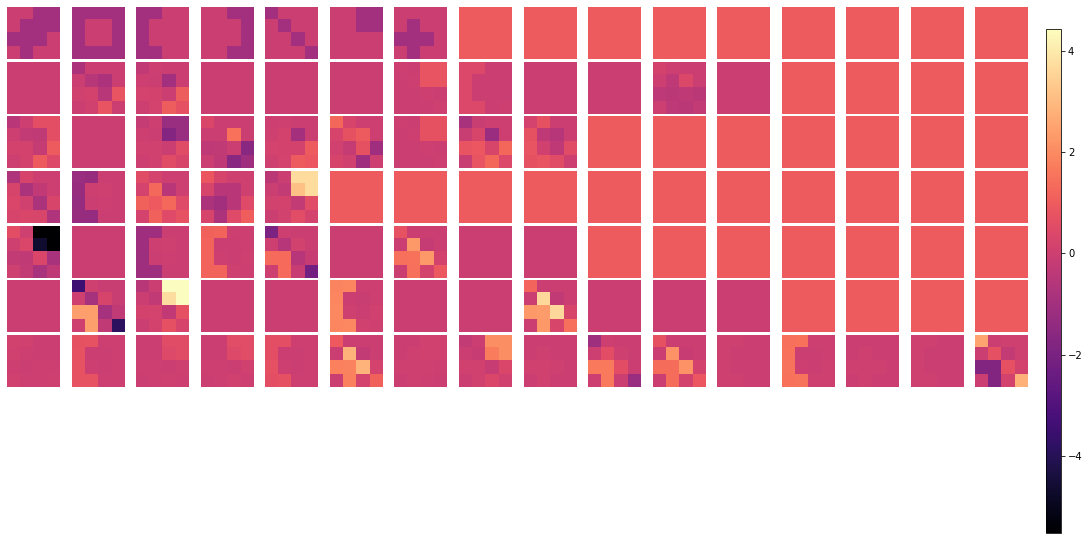

Epoch:  1 , Loss:  1.5782607793807983 , Val Loss:  1.2504392862319946
Epoch:  50 , Loss:  0.0976724922657013 , Val Loss:  0.09978494048118591
Epoch:  100 , Loss:  0.0797671303153038 , Val Loss:  0.08226875960826874
Epoch:  150 , Loss:  0.06857040524482727 , Val Loss:  0.07127345353364944
Epoch:  200 , Loss:  0.0575600229203701 , Val Loss:  0.06052510440349579
Epoch:  250 , Loss:  0.04868630692362785 , Val Loss:  0.0513242743909359
Epoch:  300 , Loss:  0.04392894729971886 , Val Loss:  0.04590767249464989
Epoch:  350 , Loss:  0.03965847194194794 , Val Loss:  0.040729179978370667
Epoch:  400 , Loss:  0.03826479986310005 , Val Loss:  0.03918454051017761
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, True, True, 'selu', 400, 150, 0.0005]
(112, 16)


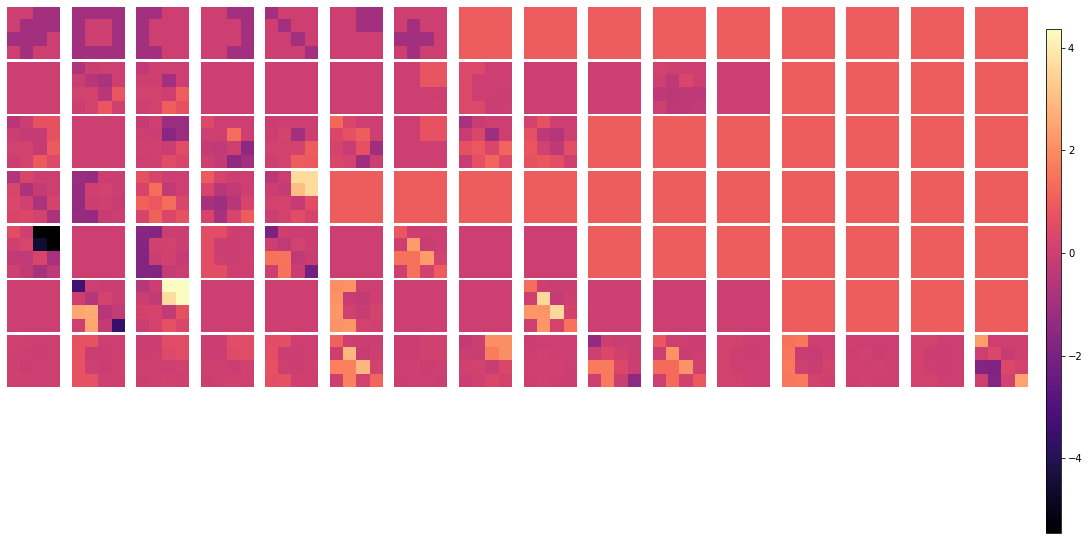

Epoch:  1 , Loss:  1.5372061729431152 , Val Loss:  1.2097033262252808
Epoch:  50 , Loss:  0.07186220586299896 , Val Loss:  0.07393565028905869
Epoch:  100 , Loss:  0.05990401655435562 , Val Loss:  0.06231324374675751
Epoch:  150 , Loss:  0.03556780889630318 , Val Loss:  0.03561272472143173
Epoch:  200 , Loss:  0.02777129039168358 , Val Loss:  0.02778792381286621
Epoch:  250 , Loss:  0.021470261737704277 , Val Loss:  0.02146916277706623
Epoch:  300 , Loss:  0.01829286478459835 , Val Loss:  0.018314646556973457
Epoch:  350 , Loss:  0.016996819525957108 , Val Loss:  0.01703578606247902
Epoch:  400 , Loss:  0.01671297289431095 , Val Loss:  0.01675182394683361
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, False, True, 'selu', 400, 150, 0.001]
(112, 16)


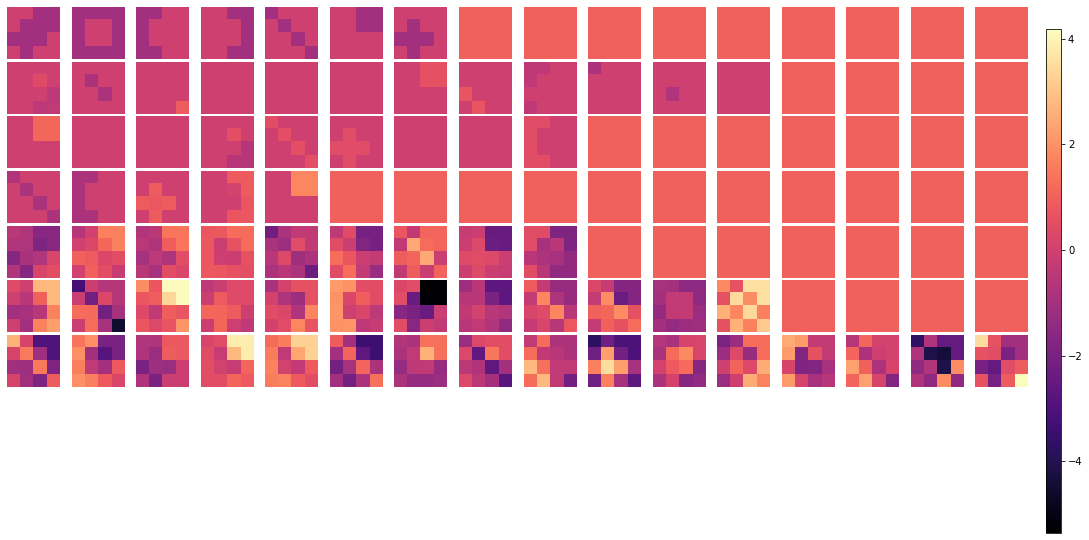

Epoch:  1 , Loss:  1.535630226135254 , Val Loss:  1.2080777883529663
Epoch:  50 , Loss:  0.07060352712869644 , Val Loss:  0.07267354428768158
Epoch:  100 , Loss:  0.058936405926942825 , Val Loss:  0.061431270092725754
Epoch:  150 , Loss:  0.03486476093530655 , Val Loss:  0.03492173179984093
Epoch:  200 , Loss:  0.02663479559123516 , Val Loss:  0.026625802740454674
Epoch:  250 , Loss:  0.020190972834825516 , Val Loss:  0.020186204463243484
Epoch:  300 , Loss:  0.01699504628777504 , Val Loss:  0.01697741635143757
Epoch:  350 , Loss:  0.015353476628661156 , Val Loss:  0.015365954488515854
Epoch:  400 , Loss:  0.014554888010025024 , Val Loss:  0.014575237408280373
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, False, True, 'selu', 400, 150, 0.0005]
(112, 16)


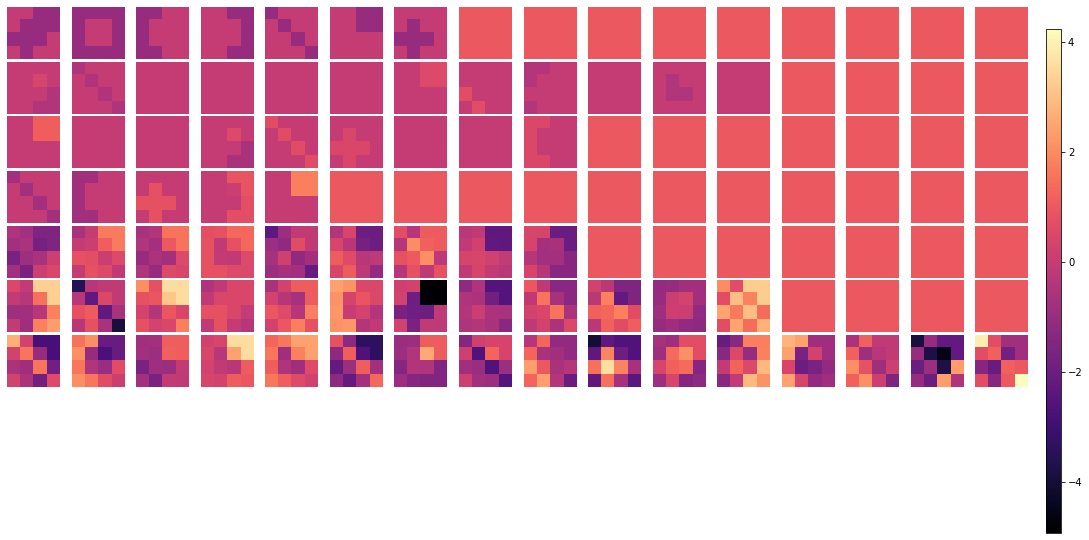

Epoch:  1 , Loss:  1.5344042778015137 , Val Loss:  1.2068032026290894
Epoch:  50 , Loss:  0.05133292078971863 , Val Loss:  0.05338136851787567
Epoch:  100 , Loss:  0.03764009103178978 , Val Loss:  0.040222082287073135
Epoch:  150 , Loss:  0.03264463320374489 , Val Loss:  0.03528725728392601
Epoch:  200 , Loss:  0.028894323855638504 , Val Loss:  0.031664103269577026
Epoch:  250 , Loss:  0.024333057925105095 , Val Loss:  0.02698352374136448
Epoch:  300 , Loss:  0.018623169511556625 , Val Loss:  0.02142132818698883
Epoch:  350 , Loss:  0.01309246476739645 , Val Loss:  0.013913837261497974
Epoch:  400 , Loss:  0.01076555997133255 , Val Loss:  0.011101537384092808
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, True, False, 'selu', 400, 150, 0.001]
(112, 16)


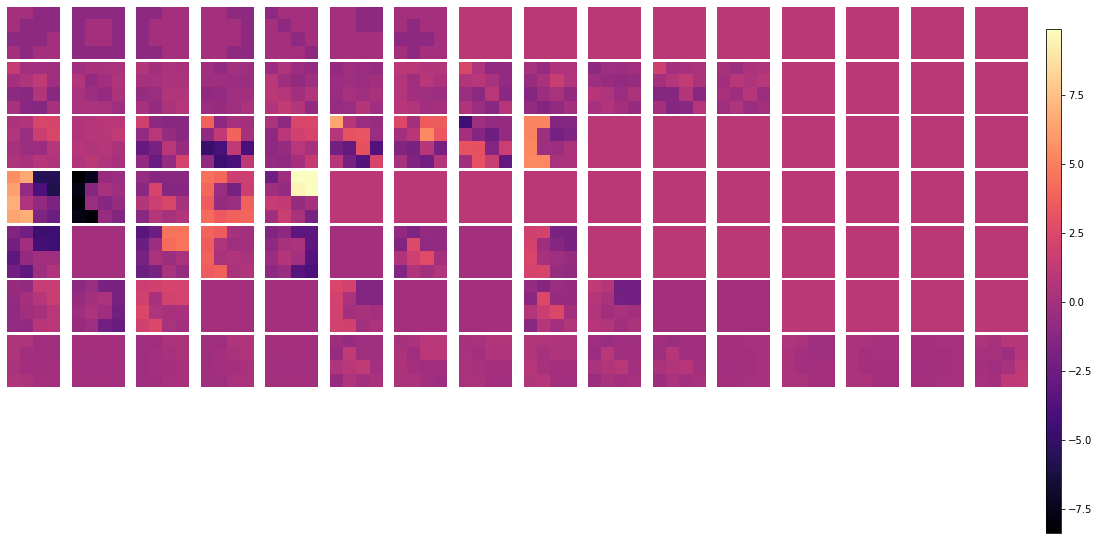

Epoch:  1 , Loss:  1.5328457355499268 , Val Loss:  1.2052087783813477
Epoch:  50 , Loss:  0.05004338547587395 , Val Loss:  0.05210049822926521
Epoch:  100 , Loss:  0.036487601697444916 , Val Loss:  0.03906511887907982
Epoch:  150 , Loss:  0.031469833105802536 , Val Loss:  0.03411852940917015
Epoch:  200 , Loss:  0.027797898277640343 , Val Loss:  0.030521975830197334
Epoch:  250 , Loss:  0.023049592971801758 , Val Loss:  0.02565547451376915
Epoch:  300 , Loss:  0.017040405422449112 , Val Loss:  0.0196992214769125
Epoch:  350 , Loss:  0.012663408182561398 , Val Loss:  0.01405383087694645
Epoch:  400 , Loss:  0.010465728119015694 , Val Loss:  0.011216866783797741
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, True, False, 'selu', 400, 150, 0.0005]
(112, 16)


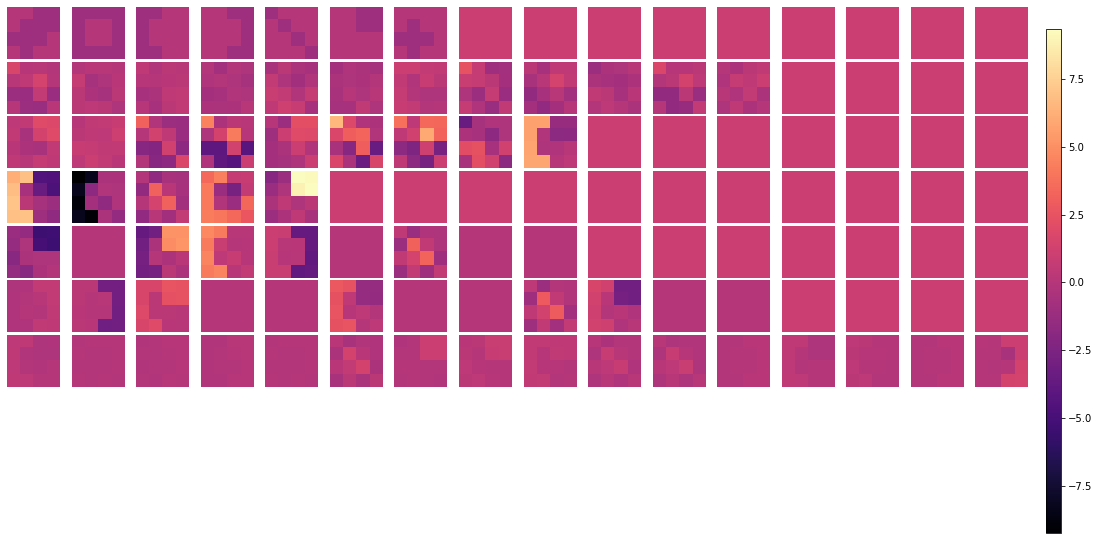

Epoch:  1 , Loss:  1.491791844367981 , Val Loss:  1.1644762754440308
Epoch:  50 , Loss:  0.02699877694249153 , Val Loss:  0.02910752035677433
Epoch:  100 , Loss:  0.008174479007720947 , Val Loss:  0.008544865064322948
Epoch:  150 , Loss:  0.00279251835308969 , Val Loss:  0.002854512305930257
Epoch:  200 , Loss:  0.002380750374868512 , Val Loss:  0.002494081621989608
Epoch:  250 , Loss:  0.002116433810442686 , Val Loss:  0.0021510100923478603
Epoch:  300 , Loss:  0.0018707896815612912 , Val Loss:  0.0019202989060431719
Epoch:  350 , Loss:  0.0016621449030935764 , Val Loss:  0.0017422001110389829
Epoch:  400 , Loss:  0.0014531501801684499 , Val Loss:  0.0015868718037381768
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, False, False, 'selu', 400, 150, 0.001]
(112, 16)


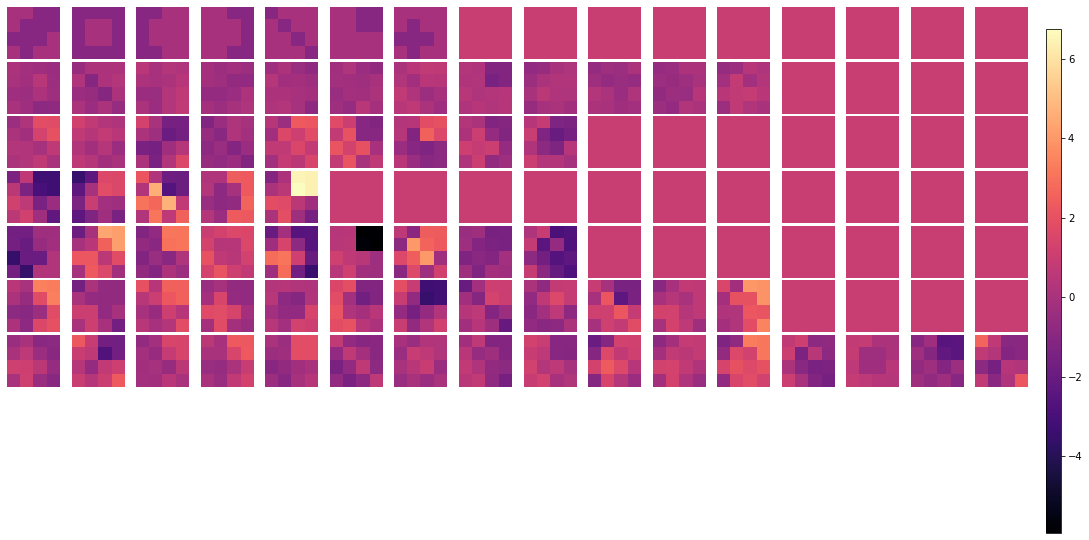

Epoch:  1 , Loss:  1.49021577835083 , Val Loss:  1.1628496646881104
Epoch:  50 , Loss:  0.025841357186436653 , Val Loss:  0.02795194834470749
Epoch:  100 , Loss:  0.008340943604707718 , Val Loss:  0.008828946389257908
Epoch:  150 , Loss:  0.0017939736135303974 , Val Loss:  0.0018826366867870092
Epoch:  200 , Loss:  0.001450293348170817 , Val Loss:  0.00152955437079072
Epoch:  250 , Loss:  0.0012704975670203567 , Val Loss:  0.0013177660293877125
Epoch:  300 , Loss:  0.0011725100921466947 , Val Loss:  0.0012041768059134483
Epoch:  350 , Loss:  0.0011100016999989748 , Val Loss:  0.0011149157071486115
Epoch:  400 , Loss:  0.000977621879428625 , Val Loss:  0.001000833697617054
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0005, 19, False, False, 'selu', 400, 150, 0.0005]
(112, 16)


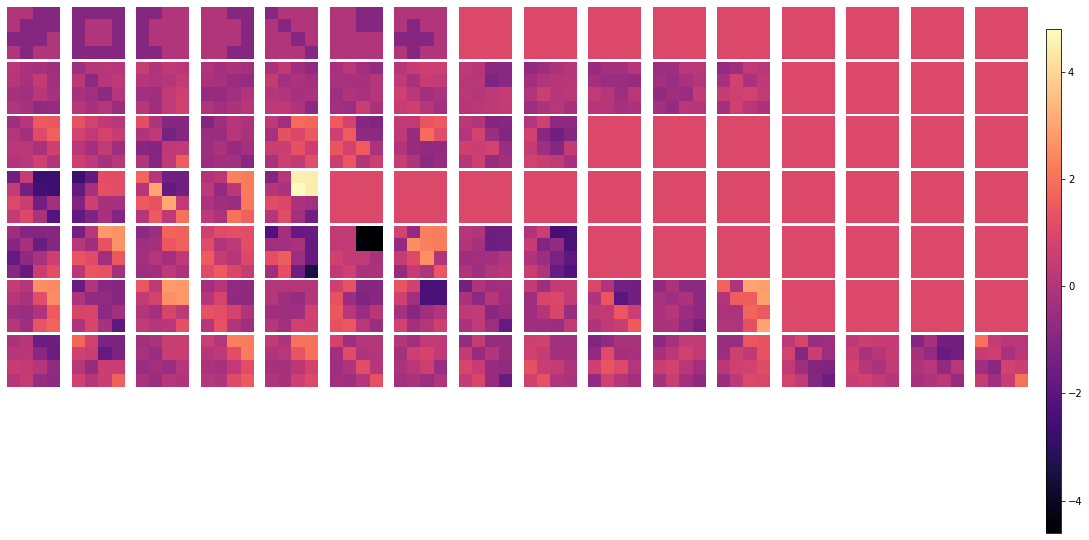

Epoch:  1 , Loss:  1.5093904733657837 , Val Loss:  1.181986927986145
Epoch:  50 , Loss:  0.04454515501856804 , Val Loss:  0.04664922133088112
Epoch:  100 , Loss:  0.037605565041303635 , Val Loss:  0.03995898738503456
Epoch:  150 , Loss:  0.018122147768735886 , Val Loss:  0.018238527700304985
Epoch:  200 , Loss:  0.01628192327916622 , Val Loss:  0.01636350341141224
Epoch:  250 , Loss:  0.014678236097097397 , Val Loss:  0.014758750796318054
Epoch:  300 , Loss:  0.013335959985852242 , Val Loss:  0.013394982554018497
Epoch:  350 , Loss:  0.01235282700508833 , Val Loss:  0.012384257279336452
Epoch:  400 , Loss:  0.011580819264054298 , Val Loss:  0.011611493304371834
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0001, 19, True, True, 'selu', 400, 150, 0.001]
(112, 16)


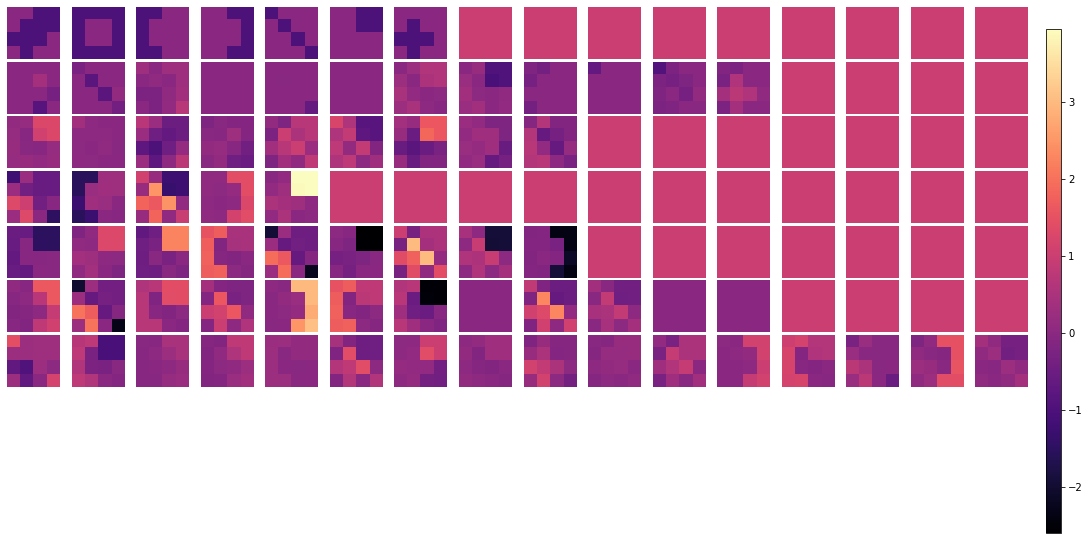

Epoch:  1 , Loss:  1.5078150033950806 , Val Loss:  1.180361270904541
Epoch:  50 , Loss:  0.043336838483810425 , Val Loss:  0.045438170433044434
Epoch:  100 , Loss:  0.037241578102111816 , Val Loss:  0.03974147513508797
Epoch:  150 , Loss:  0.01708865351974964 , Val Loss:  0.017198003828525543
Epoch:  200 , Loss:  0.01516516599804163 , Val Loss:  0.01523654442280531
Epoch:  250 , Loss:  0.013555051758885384 , Val Loss:  0.01360184233635664
Epoch:  300 , Loss:  0.012269989587366581 , Val Loss:  0.012300997041165829
Epoch:  350 , Loss:  0.0112795764580369 , Val Loss:  0.011304259300231934
Epoch:  400 , Loss:  0.010462436825037003 , Val Loss:  0.010492732748389244
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0001, 19, True, True, 'selu', 400, 150, 0.0005]
(112, 16)


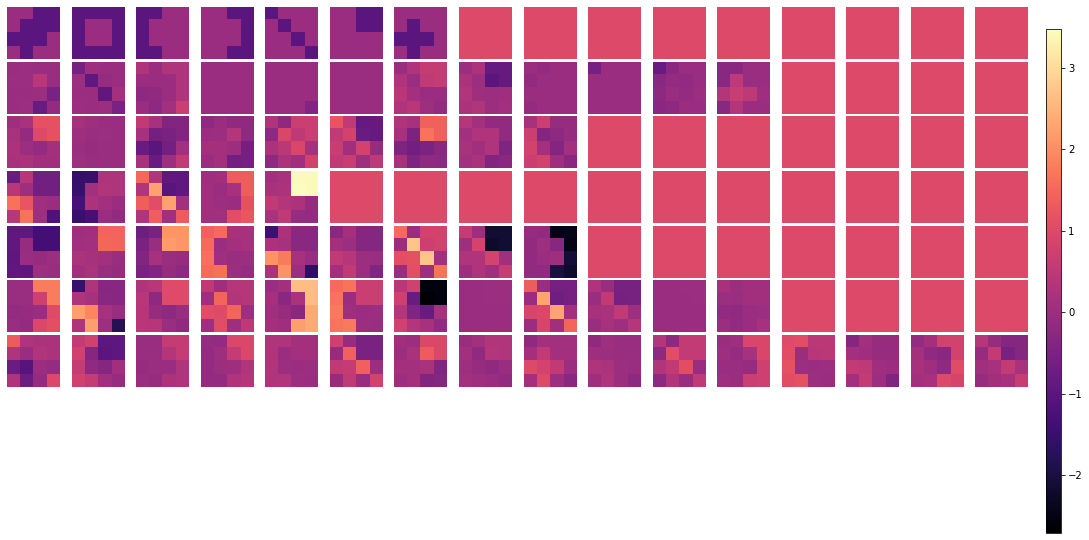

Epoch:  1 , Loss:  1.5008797645568848 , Val Loss:  1.1735420227050781
Epoch:  50 , Loss:  0.03702910616993904 , Val Loss:  0.03914983570575714
Epoch:  100 , Loss:  0.01739346608519554 , Val Loss:  0.017715344205498695
Epoch:  150 , Loss:  0.012547503225505352 , Val Loss:  0.012681220658123493
Epoch:  200 , Loss:  0.011236071586608887 , Val Loss:  0.011339528486132622
Epoch:  250 , Loss:  0.009989140555262566 , Val Loss:  0.01005446258932352
Epoch:  300 , Loss:  0.008837230503559113 , Val Loss:  0.008901749737560749
Epoch:  350 , Loss:  0.007885076105594635 , Val Loss:  0.00794287770986557
Epoch:  400 , Loss:  0.007173719350248575 , Val Loss:  0.007221363019198179
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0001, 19, False, True, 'selu', 400, 150, 0.001]
(112, 16)


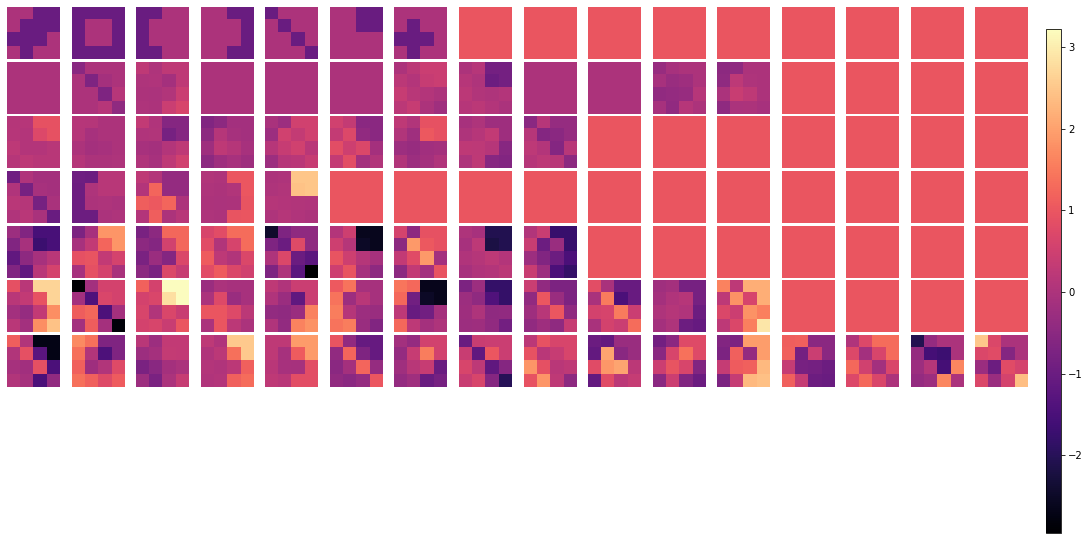

Epoch:  1 , Loss:  1.499303936958313 , Val Loss:  1.1719154119491577
Epoch:  50 , Loss:  0.03585170581936836 , Val Loss:  0.03795674070715904
Epoch:  100 , Loss:  0.01907438226044178 , Val Loss:  0.01956874318420887
Epoch:  150 , Loss:  0.011476289480924606 , Val Loss:  0.011607334949076176
Epoch:  200 , Loss:  0.01016991212964058 , Val Loss:  0.010251205414533615
Epoch:  250 , Loss:  0.00893147848546505 , Val Loss:  0.00899716280400753
Epoch:  300 , Loss:  0.007930469699203968 , Val Loss:  0.007974179461598396
Epoch:  350 , Loss:  0.0070402976125478745 , Val Loss:  0.007073563989251852
Epoch:  400 , Loss:  0.00639727059751749 , Val Loss:  0.006422024220228195
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0001, 19, False, True, 'selu', 400, 150, 0.0005]
(112, 16)


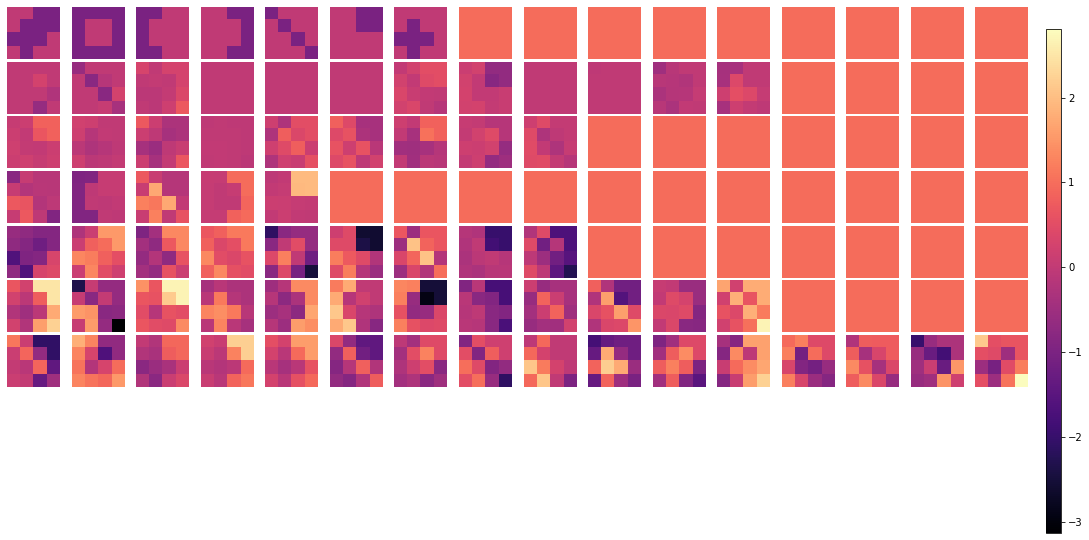

Epoch:  1 , Loss:  1.5003018379211426 , Val Loss:  1.172921061515808
Epoch:  50 , Loss:  0.034384243190288544 , Val Loss:  0.03648073598742485
Epoch:  100 , Loss:  0.026928262785077095 , Val Loss:  0.029101435095071793
Epoch:  150 , Loss:  0.007641440257430077 , Val Loss:  0.00779423164203763
Epoch:  200 , Loss:  0.006296978332102299 , Val Loss:  0.006364707835018635
Epoch:  250 , Loss:  0.0053657665848731995 , Val Loss:  0.005435720551759005
Epoch:  300 , Loss:  0.004677283111959696 , Val Loss:  0.0047189295291900635
Epoch:  350 , Loss:  0.004183886107057333 , Val Loss:  0.00423833355307579
Epoch:  400 , Loss:  0.003807324217632413 , Val Loss:  0.0038646250031888485
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0001, 19, True, False, 'selu', 400, 150, 0.001]
(112, 16)


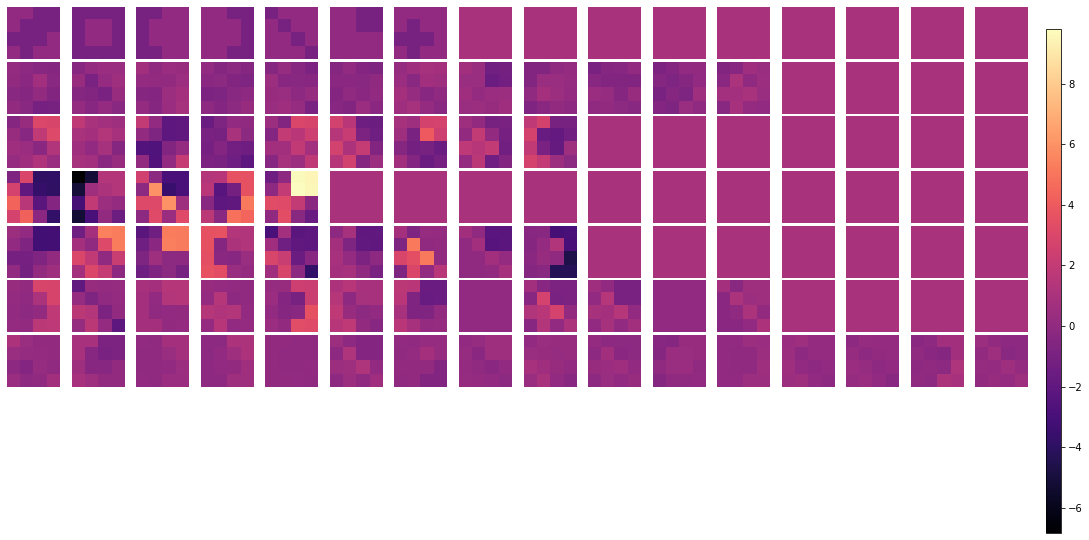

Epoch:  1 , Loss:  1.4987269639968872 , Val Loss:  1.1712921857833862
Epoch:  50 , Loss:  0.03314264491200447 , Val Loss:  0.03524104133248329
Epoch:  100 , Loss:  0.027079878374934196 , Val Loss:  0.02951342985033989
Epoch:  150 , Loss:  0.006638978607952595 , Val Loss:  0.006765557453036308
Epoch:  200 , Loss:  0.005301586352288723 , Val Loss:  0.005364515818655491
Epoch:  250 , Loss:  0.00456045288592577 , Val Loss:  0.0045954082161188126
Epoch:  300 , Loss:  0.004062819294631481 , Val Loss:  0.0041135698556900024
Epoch:  350 , Loss:  0.0037045071367174387 , Val Loss:  0.003739204490557313
Epoch:  400 , Loss:  0.003411632962524891 , Val Loss:  0.0034371570218354464
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0001, 19, True, False, 'selu', 400, 150, 0.0005]
(112, 16)


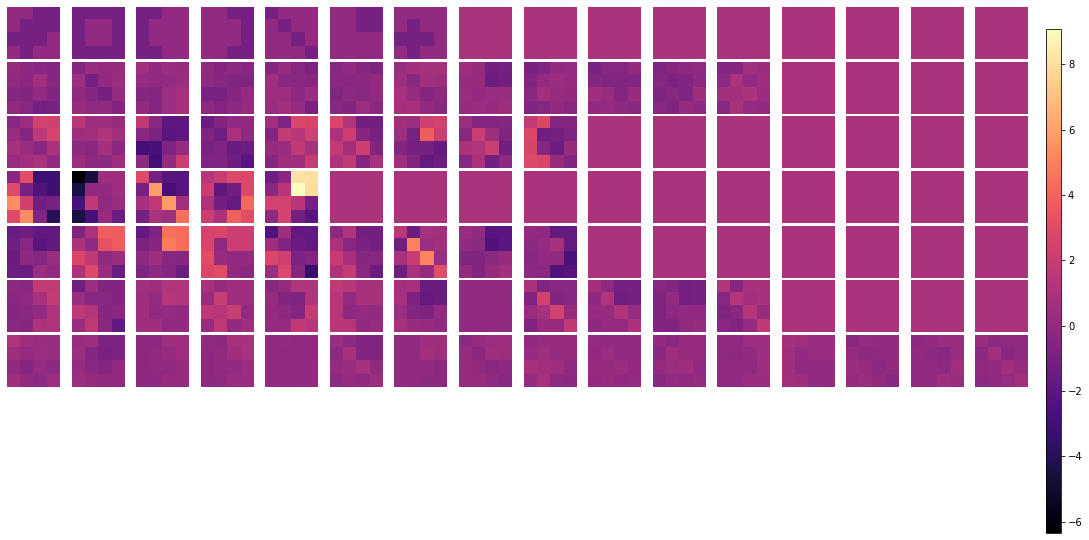

Epoch:  1 , Loss:  1.491791844367981 , Val Loss:  1.1644762754440308
Epoch:  50 , Loss:  0.02699877694249153 , Val Loss:  0.02910752035677433
Epoch:  100 , Loss:  0.008174479007720947 , Val Loss:  0.008544865064322948
Epoch:  150 , Loss:  0.00279251835308969 , Val Loss:  0.002854512305930257
Epoch:  200 , Loss:  0.002380750374868512 , Val Loss:  0.002494081621989608
Epoch:  250 , Loss:  0.002116433810442686 , Val Loss:  0.0021510100923478603
Epoch:  300 , Loss:  0.0018707896815612912 , Val Loss:  0.0019202989060431719
Epoch:  350 , Loss:  0.0016621449030935764 , Val Loss:  0.0017422001110389829
Epoch:  400 , Loss:  0.0014531501801684499 , Val Loss:  0.0015868718037381768
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0001, 19, False, False, 'selu', 400, 150, 0.001]
(112, 16)


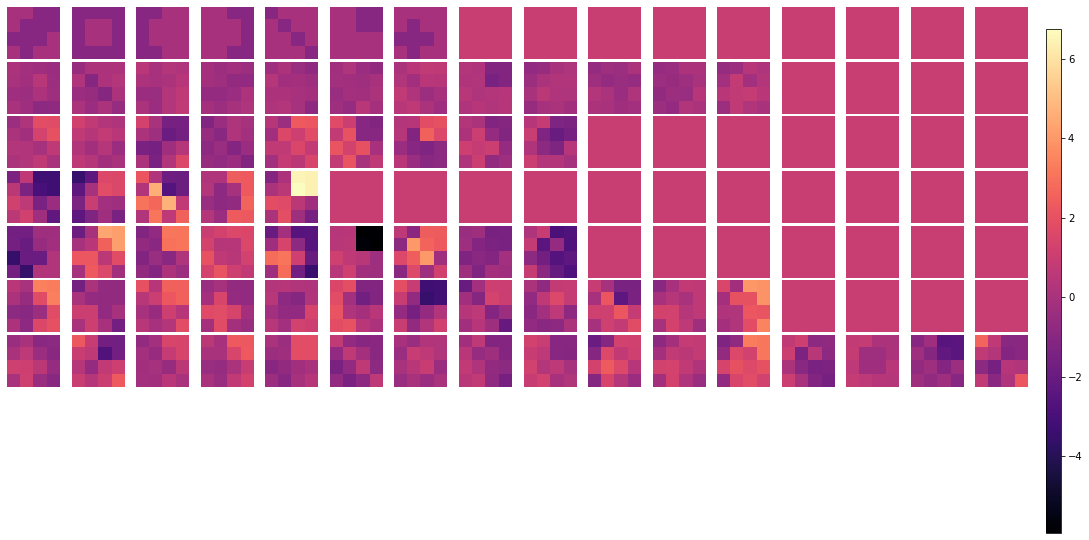

Epoch:  1 , Loss:  1.49021577835083 , Val Loss:  1.1628496646881104
Epoch:  50 , Loss:  0.025841357186436653 , Val Loss:  0.02795194834470749
Epoch:  100 , Loss:  0.008340943604707718 , Val Loss:  0.008828946389257908
Epoch:  150 , Loss:  0.0017939736135303974 , Val Loss:  0.0018826366867870092
Epoch:  200 , Loss:  0.001450293348170817 , Val Loss:  0.00152955437079072
Epoch:  250 , Loss:  0.0012704975670203567 , Val Loss:  0.0013177660293877125
Epoch:  300 , Loss:  0.0011725100921466947 , Val Loss:  0.0012041768059134483
Epoch:  350 , Loss:  0.0011100016999989748 , Val Loss:  0.0011149157071486115
Epoch:  400 , Loss:  0.000977621879428625 , Val Loss:  0.001000833697617054
(16, 12)
(12, 9)
(9, 5)
(5, 9)
(9, 12)
(12, 16)

[[16, 12, 9, 5, 9, 12, 16], 0.0001, 19, False, False, 'selu', 400, 150, 0.0005]
(112, 16)


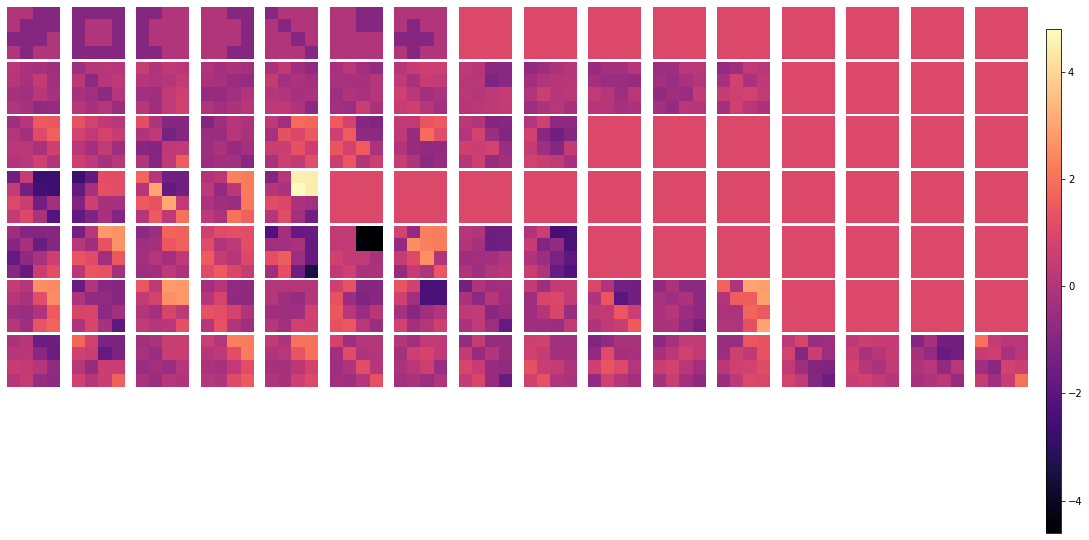

In [82]:
### Model Selection
arches = [[16,14,12,10,8,6,8,10,12,14,16], [16, 12, 9, 5, 9, 12, 16]]
rrs = [0.0005, 0.0001]
encoder_regs = [True, False]
decoder_regs = [True, False]
sparse_rates = [0.001, 0.0005]

for arch in arches:
    for rr in rrs:
        for decoder_reg in decoder_regs:
            for encoder_reg in encoder_regs:
                for sparse_rate in sparse_rates:
                    encoder_ae, decoder_ae, hparams = run_autoencoder(sparse=True, sparse_rate=sparse_rate, 
                                                                      arch=arch, 
                                                                      decoder_reg=decoder_reg, 
                                                                      encoder_reg=encoder_reg, 
                                                                      e=400, rr=rr, seed=19, activ='selu')
                    weights_ae = get_ae_weights(encoder_ae, decoder_ae)
                    print(hparams)
                    show_ae(weights_ae)

# Thoughts 
- so far stacked autoencoder and sparse autoencoder look pretty great
- TODO more sparse autoencoders and VAE 

# Table of Contents
1.  [Redundant Input Neural Network (RINN)](#rinn)
2.  [Hidden Causal Structure Ground Truth Patterns in Simulated Data](#patterns)
3.  [Stacked Autoencoder](#ae)
4.  [Dropout Denoising Autoencoder](#drop_ae)
5.  [Gaussian Noise Denoising Autoencoder](#gaussian_ae)
6.  [Sparse Autoencoder](#sparse_ae)
7.  TODO (other sparse autoencoders and VAE)